
## Problem Statement

- Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
- Write a single notebook file to run all the 3 models above for 20 epochs each
- Create these graphs:
  Graph 1: Test/Validation Loss for all 3 models together
  Graph 2: Test/Validation Accuracy for 3 models together
  graphs must have proper annotation

- Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

# Import Libraries

In [1]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from definitions import *


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Check for GPU availability

In [4]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's import the model with configurable normalization layers incldued

In [6]:
from model import Net

# Check GPU Availability

In [7]:
# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# Model Summaries

In [8]:
!pip install torchsummary
from torchsummary import summary

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]

for norm in norm_options:
  
  print(f"\nModel Summary with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Check model summary
  summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Model Summary with NormalizationType => NormType.BATCH_NORM

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,080
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 15, 24, 24]             225
        MaxPool2d-10           [-1, 15, 12, 12]               0
           Conv2d-11           [-1, 15, 10, 10]           2,025
      

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [9]:
# define train & test APIs

# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate model prediction loss
    loss = F.nll_loss(y_pred, target)

    # Handle for L1 loss
    if RegularizerType.L1 == regularizer_type:
      l1 = 0
      for p in model.parameters():
        # absolute sum of all weights
        l1 += p.abs().sum()
      
      # Total loss is sum of model prediction loss + L1 loss
      loss += (regularizer_lambda * l1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [10]:
# Invoke train & evaluate the model 

from torch.optim.lr_scheduler import StepLR

def train_test_model(model, epochs=20, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):

  # create an optimizer (SGD) with required parameters, 
  # model.parameters() - these are the model parameters to optimize, 
  # learning-rate lr=0.01 and momentum-0.9
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

  prev_train_acc = -1
  prev_test_acc = -1
  train_accuracy = 0
  test_accuracy = 0

  # run single epoch as of now.
  for epoch in range(epochs):
      print(f'Epoch: {epoch+1}')

      # train the model loaded on the device with the required optimizer
      train_accuracy = train(
                          model, device, train_loader, 
                          optimizer,
                          regularizer_lambda, 
                          regularizer_type)

      # set to the next lr params
      scheduler.step()

      # we need to evaluate on test data
      test_accuracy = test(model, device, test_loader)


      # check difference from previous accuracies for better understanding
      if -1 == prev_train_acc:
        prev_train_acc = train_accuracy
      if -1 == prev_test_acc:
        prev_test_acc = test_accuracy

      print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
      prev_train_acc = train_accuracy
      prev_test_acc = test_accuracy

  # update model metric
  model_metric = [train_losses, test_losses, train_acc, test_acc]
  return model_metric

In [11]:
import copy

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]
norm_name = ["BATCH_NORM", "LAYER_NORM", "GROUP_NORM"]

# evaluation metrics for different models
evaluation_metrics = {}
model_metric = []

print(f"\nTrain & Evaluate different model\n")

for ndx, norm in enumerate(norm_options):
  
  print(f"\nTrain & Test Model with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Map regularizer type as per the problem statement.
  regularizer = RegularizerType.NONE
  if NormType.BATCH_NORM == norm:
    regularizer = RegularizerType.NONE #To change to L1

  # reset to update metics for new model training
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # train the test model
  model_metric = train_test_model(
                        model, epochs=20, 
                        regularizer_lambda=0.01, 
                        regularizer_type=regularizer)

  # update final evaluation metrics for this model
  evaluation_metrics[norm_name[ndx]] = model_metric


Train & Evaluate different model


Train & Test Model with NormalizationType => NormType.BATCH_NORM

Epoch: 1


Loss=0.06467451900243759 Batch_id=468 Accuracy=92.38: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0844, Accuracy: 9711/10000 (97.11%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 4.735

Epoch: 2


Loss=0.022633029147982597 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0431, Accuracy: 9862/10000 (98.62%)

train_acc_diff: 5.522 test_acc_diff: 1.510 test_train_diff: 0.723

Epoch: 3


Loss=0.052728042006492615 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]



Test set: Average loss: 0.0350, Accuracy: 9898/10000 (98.98%)

train_acc_diff: 0.402 test_acc_diff: 0.360 test_train_diff: 0.682

Epoch: 4


Loss=0.11020954698324203 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]



Test set: Average loss: 0.0335, Accuracy: 9899/10000 (98.99%)

train_acc_diff: 0.192 test_acc_diff: 0.010 test_train_diff: 0.500

Epoch: 5


Loss=0.024273646995425224 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]



Test set: Average loss: 0.0327, Accuracy: 9897/10000 (98.97%)

train_acc_diff: 0.062 test_acc_diff: -0.020 test_train_diff: 0.418

Epoch: 6


Loss=0.0807897076010704 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99.14%)

train_acc_diff: 0.110 test_acc_diff: 0.170 test_train_diff: 0.478

Epoch: 7


Loss=0.016398737207055092 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

train_acc_diff: 0.238 test_acc_diff: 0.060 test_train_diff: 0.300

Epoch: 8


Loss=0.056749213486909866 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]



Test set: Average loss: 0.0287, Accuracy: 9895/10000 (98.95%)

train_acc_diff: 0.037 test_acc_diff: -0.250 test_train_diff: 0.013

Epoch: 9


Loss=0.049216341227293015 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

train_acc_diff: 0.023 test_acc_diff: 0.350 test_train_diff: 0.340

Epoch: 10


Loss=0.0421118438243866 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.008 test_acc_diff: 0.020 test_train_diff: 0.352

Epoch: 11


Loss=0.06250658631324768 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

train_acc_diff: -0.005 test_acc_diff: -0.150 test_train_diff: 0.207

Epoch: 12


Loss=0.008650189265608788 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

train_acc_diff: 0.057 test_acc_diff: 0.060 test_train_diff: 0.210

Epoch: 13


Loss=0.014128250069916248 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

train_acc_diff: 0.090 test_acc_diff: 0.010 test_train_diff: 0.130

Epoch: 14


Loss=0.014245621860027313 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

train_acc_diff: 0.040 test_acc_diff: 0.030 test_train_diff: 0.120

Epoch: 15


Loss=0.015848308801651 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

train_acc_diff: 0.005 test_acc_diff: 0.040 test_train_diff: 0.155

Epoch: 16


Loss=0.0061509995721280575 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

train_acc_diff: -0.010 test_acc_diff: 0.050 test_train_diff: 0.215

Epoch: 17


Loss=0.06762217730283737 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

train_acc_diff: 0.022 test_acc_diff: 0.010 test_train_diff: 0.203

Epoch: 18


Loss=0.007862561382353306 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.000 test_acc_diff: -0.050 test_train_diff: 0.153

Epoch: 19


Loss=0.08870356529951096 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

train_acc_diff: 0.083 test_acc_diff: 0.010 test_train_diff: 0.080

Epoch: 20


Loss=0.02923138625919819 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

train_acc_diff: -0.052 test_acc_diff: -0.020 test_train_diff: 0.112


Train & Test Model with NormalizationType => NormType.LAYER_NORM

Epoch: 1


Loss=0.06439396739006042 Batch_id=468 Accuracy=90.02: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0746, Accuracy: 9808/10000 (98.08%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 8.060

Epoch: 2


Loss=0.08990007638931274 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]



Test set: Average loss: 0.0493, Accuracy: 9877/10000 (98.77%)

train_acc_diff: 7.677 test_acc_diff: 0.690 test_train_diff: 1.073

Epoch: 3


Loss=0.03299877792596817 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]



Test set: Average loss: 0.0367, Accuracy: 9894/10000 (98.94%)

train_acc_diff: 0.427 test_acc_diff: 0.170 test_train_diff: 0.817

Epoch: 4


Loss=0.032600287348032 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]



Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

train_acc_diff: 0.198 test_acc_diff: 0.170 test_train_diff: 0.788

Epoch: 5


Loss=0.04797477647662163 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]



Test set: Average loss: 0.0313, Accuracy: 9898/10000 (98.98%)

train_acc_diff: 0.135 test_acc_diff: -0.130 test_train_diff: 0.523

Epoch: 6


Loss=0.02048938162624836 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

train_acc_diff: 0.140 test_acc_diff: 0.210 test_train_diff: 0.593

Epoch: 7


Loss=0.0677110105752945 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]



Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

train_acc_diff: 0.278 test_acc_diff: -0.150 test_train_diff: 0.165

Epoch: 8


Loss=0.049145132303237915 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]



Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

train_acc_diff: 0.008 test_acc_diff: 0.120 test_train_diff: 0.277

Epoch: 9


Loss=0.047152429819107056 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]



Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.032 test_acc_diff: 0.050 test_train_diff: 0.295

Epoch: 10


Loss=0.044316232204437256 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)

train_acc_diff: -0.042 test_acc_diff: 0.040 test_train_diff: 0.377

Epoch: 11


Loss=0.03105560503900051 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

train_acc_diff: 0.118 test_acc_diff: -0.100 test_train_diff: 0.158

Epoch: 12


Loss=0.01633976213634014 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

train_acc_diff: -0.030 test_acc_diff: 0.090 test_train_diff: 0.278

Epoch: 13


Loss=0.03714241459965706 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]



Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.103 test_acc_diff: 0.080 test_train_diff: 0.255

Epoch: 14


Loss=0.013731200248003006 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

train_acc_diff: 0.020 test_acc_diff: 0.010 test_train_diff: 0.245

Epoch: 15


Loss=0.026444951072335243 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]



Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

train_acc_diff: -0.025 test_acc_diff: -0.110 test_train_diff: 0.160

Epoch: 16


Loss=0.023834267631173134 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

train_acc_diff: 0.083 test_acc_diff: 0.090 test_train_diff: 0.167

Epoch: 17


Loss=0.007328613195568323 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]



Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

train_acc_diff: -0.003 test_acc_diff: 0.010 test_train_diff: 0.180

Epoch: 18


Loss=0.0298417080193758 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

train_acc_diff: -0.030 test_acc_diff: 0.020 test_train_diff: 0.230

Epoch: 19


Loss=0.04673244431614876 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.112 test_acc_diff: 0.010 test_train_diff: 0.128

Epoch: 20


Loss=0.050506215542554855 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

train_acc_diff: -0.022 test_acc_diff: -0.010 test_train_diff: 0.140


Train & Test Model with NormalizationType => NormType.GROUP_NORM

Epoch: 1


Loss=0.10301374644041061 Batch_id=468 Accuracy=89.12: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0646, Accuracy: 9817/10000 (98.17%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 9.047

Epoch: 2


Loss=0.07870224863290787 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0533, Accuracy: 9831/10000 (98.31%)

train_acc_diff: 8.253 test_acc_diff: 0.140 test_train_diff: 0.933

Epoch: 3


Loss=0.13175204396247864 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]



Test set: Average loss: 0.0372, Accuracy: 9888/10000 (98.88%)

train_acc_diff: 0.740 test_acc_diff: 0.570 test_train_diff: 0.763

Epoch: 4


Loss=0.031243955716490746 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0319, Accuracy: 9898/10000 (98.98%)

train_acc_diff: 0.160 test_acc_diff: 0.100 test_train_diff: 0.703

Epoch: 5


Loss=0.04144078120589256 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]



Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)

train_acc_diff: 0.203 test_acc_diff: 0.100 test_train_diff: 0.600

Epoch: 6


Loss=0.017119308933615685 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]



Test set: Average loss: 0.0291, Accuracy: 9904/10000 (99.04%)

train_acc_diff: 0.007 test_acc_diff: -0.040 test_train_diff: 0.553

Epoch: 7


Loss=0.039836447685956955 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.370 test_acc_diff: 0.250 test_train_diff: 0.433

Epoch: 8


Loss=0.018713826313614845 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss: 0.0234, Accuracy: 9916/10000 (99.16%)

train_acc_diff: 0.112 test_acc_diff: -0.130 test_train_diff: 0.192

Epoch: 9


Loss=0.015832003206014633 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss: 0.0191, Accuracy: 9929/10000 (99.29%)

train_acc_diff: -0.003 test_acc_diff: 0.130 test_train_diff: 0.325

Epoch: 10


Loss=0.00667273486033082 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0227, Accuracy: 9919/10000 (99.19%)

train_acc_diff: 0.030 test_acc_diff: -0.100 test_train_diff: 0.195

Epoch: 11


Loss=0.059480905532836914 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]



Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

train_acc_diff: -0.008 test_acc_diff: 0.120 test_train_diff: 0.323

Epoch: 12


Loss=0.012126907706260681 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0194, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.023 test_acc_diff: 0.010 test_train_diff: 0.310

Epoch: 13


Loss=0.0034794716630131006 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]



Test set: Average loss: 0.0196, Accuracy: 9931/10000 (99.31%)

train_acc_diff: 0.150 test_acc_diff: -0.010 test_train_diff: 0.150

Epoch: 14


Loss=0.004300659988075495 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

train_acc_diff: 0.007 test_acc_diff: 0.060 test_train_diff: 0.203

Epoch: 15


Loss=0.04191434010863304 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]



Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

train_acc_diff: -0.022 test_acc_diff: 0.030 test_train_diff: 0.255

Epoch: 16


Loss=0.0071525308303534985 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]



Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

train_acc_diff: 0.028 test_acc_diff: -0.040 test_train_diff: 0.187

Epoch: 17


Loss=0.009475802071392536 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]



Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)

train_acc_diff: 0.005 test_acc_diff: -0.020 test_train_diff: 0.162

Epoch: 18


Loss=0.050785768777132034 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

train_acc_diff: 0.032 test_acc_diff: -0.010 test_train_diff: 0.120

Epoch: 19


Loss=0.021535024046897888 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]



Test set: Average loss: 0.0185, Accuracy: 9933/10000 (99.33%)

train_acc_diff: 0.078 test_acc_diff: 0.000 test_train_diff: 0.042

Epoch: 20


Loss=0.012544207274913788 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0175, Accuracy: 9936/10000 (99.36%)

train_acc_diff: -0.008 test_acc_diff: 0.030 test_train_diff: 0.080



# Plot the model's learning progress

- Plot training and test accuracies of all models

<ipython-input-12-d4840e90c6c3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2, 1)
<ipython-input-12-d4840e90c6c3>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


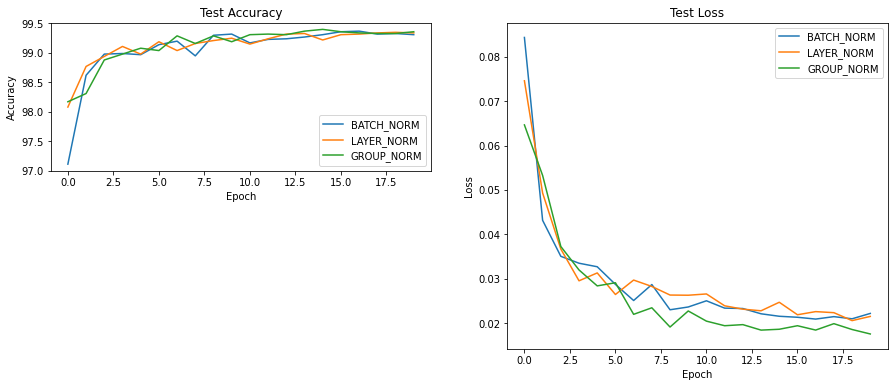

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for name in norm_name:
  
  train_losses  = evaluation_metrics[name][0]
  test_losses   = evaluation_metrics[name][1]
  train_acc     = evaluation_metrics[name][2]
  test_acc      = evaluation_metrics[name][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_name)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_name)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()

In [13]:
import numpy as np

def display_misclassified_images(model):
  print("\n\n\n********* Misclassified Images **************\n\n\n")
  model.eval()

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      
      # Get the indexes of images that are incorrectly classified
      indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

      # Plot the misclassified images
      rows = np.ceil(len(indexes)/2)
      fig = plt.figure(figsize=(15, rows*4))
      for i, idx in enumerate(indexes[:10]):
        ax = fig.add_subplot(rows, 5, i+1)
        ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
        ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")

      plt.show()


Display misclassified Files

---------------------------------------------------------------

Misclassified files => Model with NormalizationType => NormType.BATCH_NORM

---------------------------------------------------------------



********* Misclassified Images **************





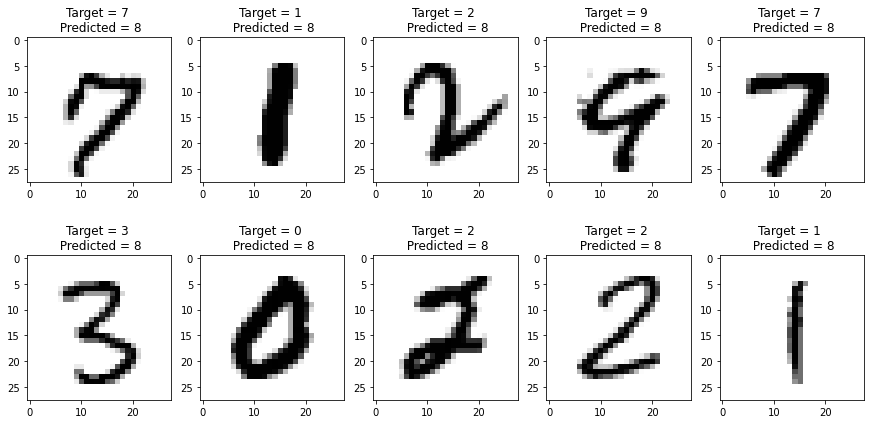

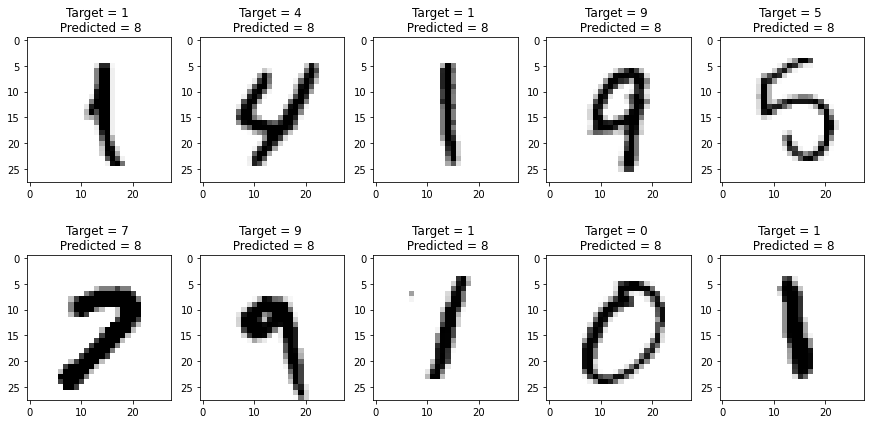

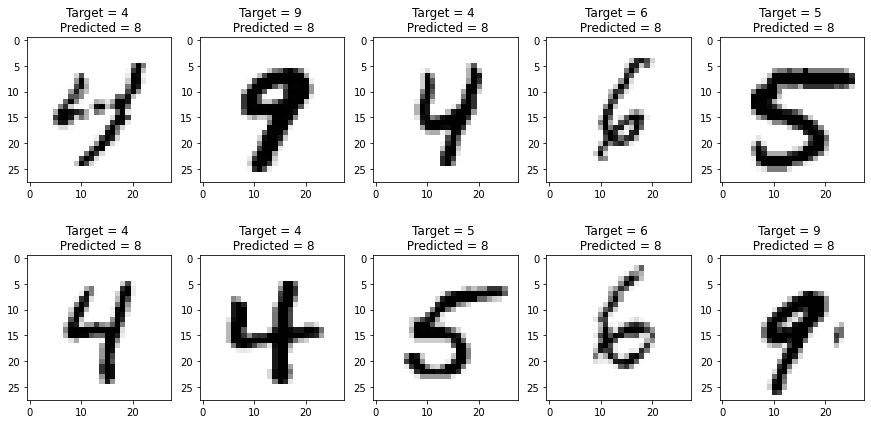

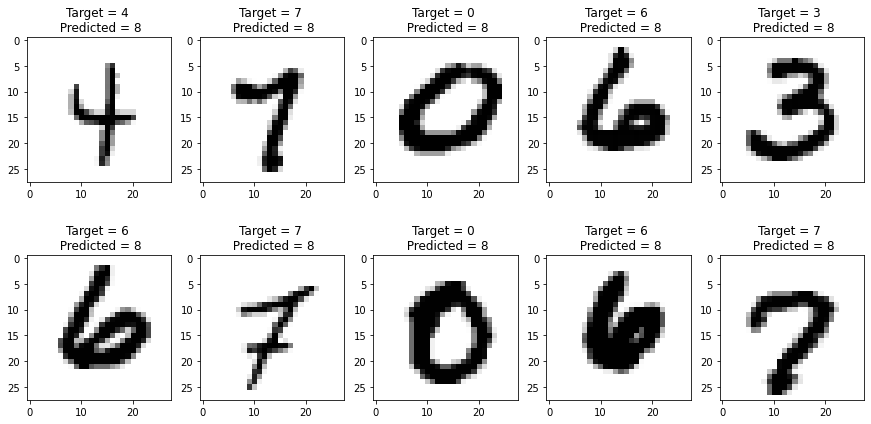

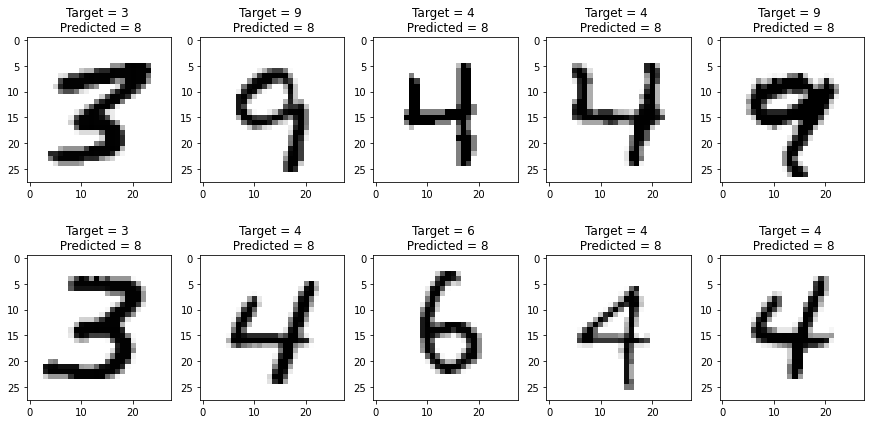

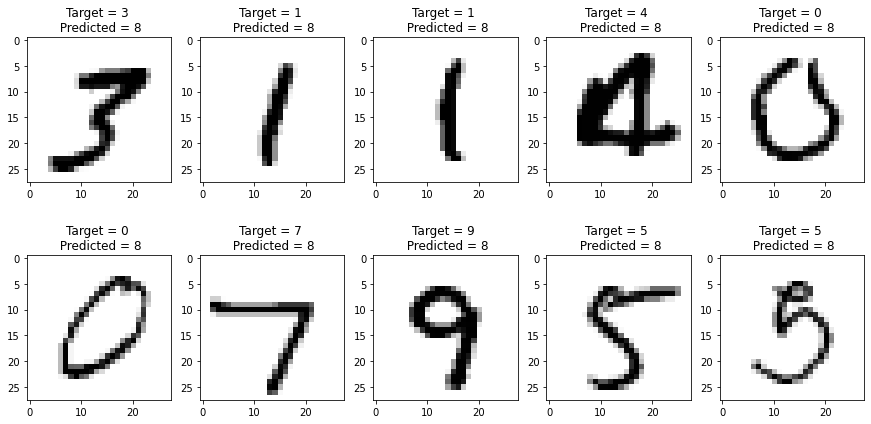

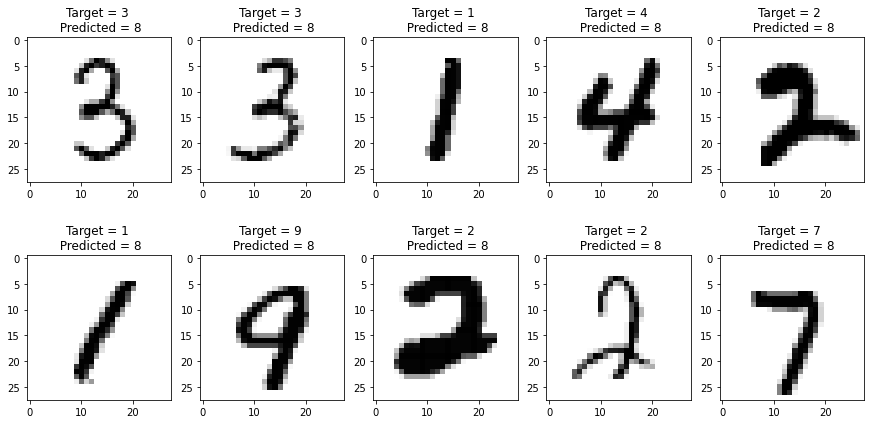

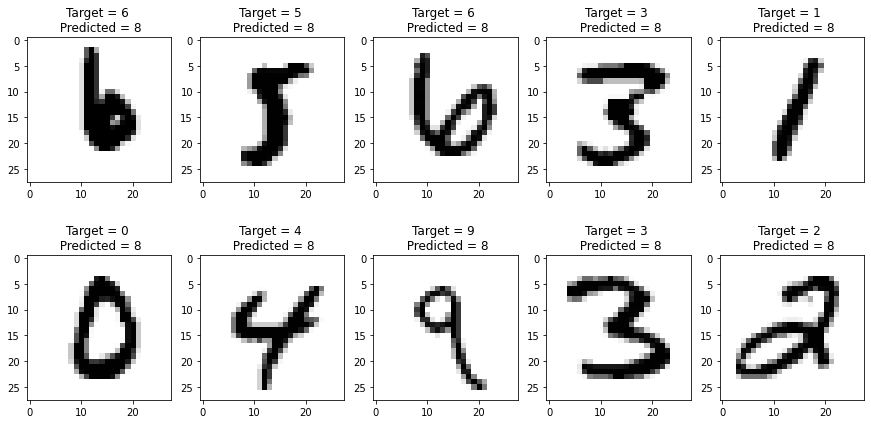

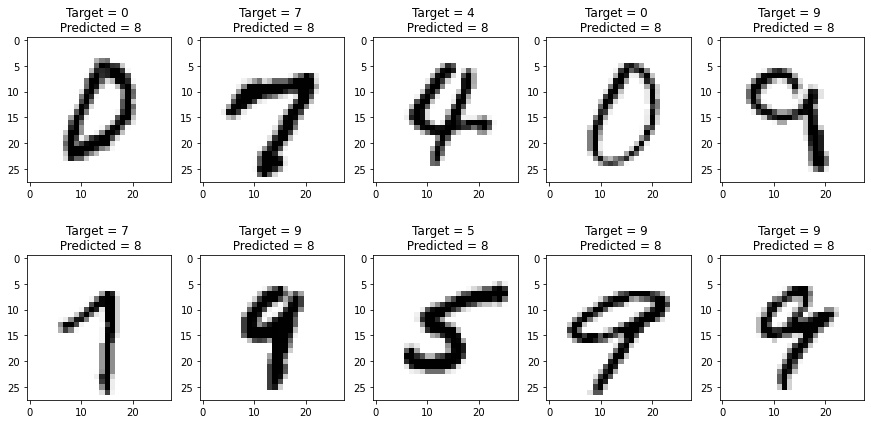

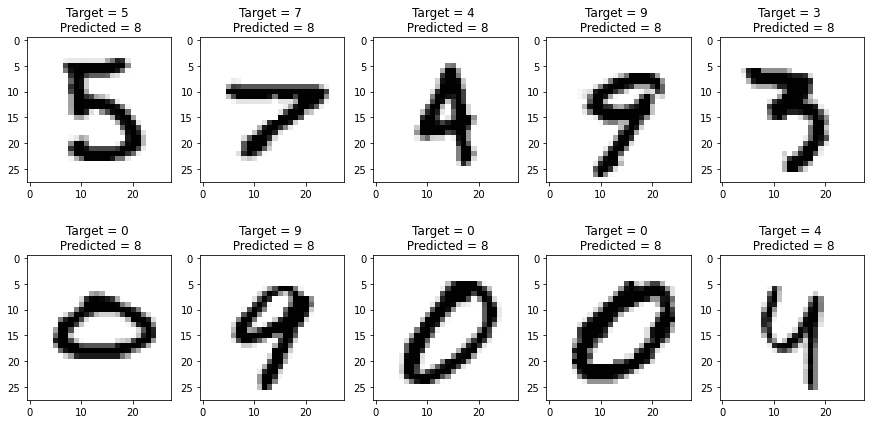

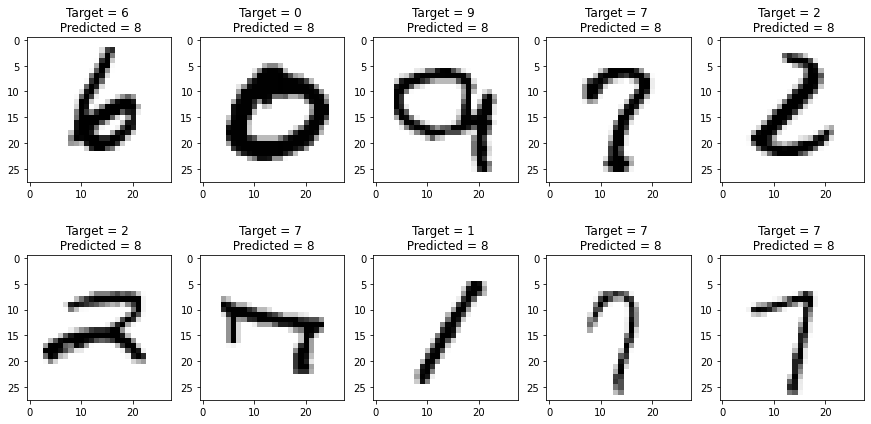

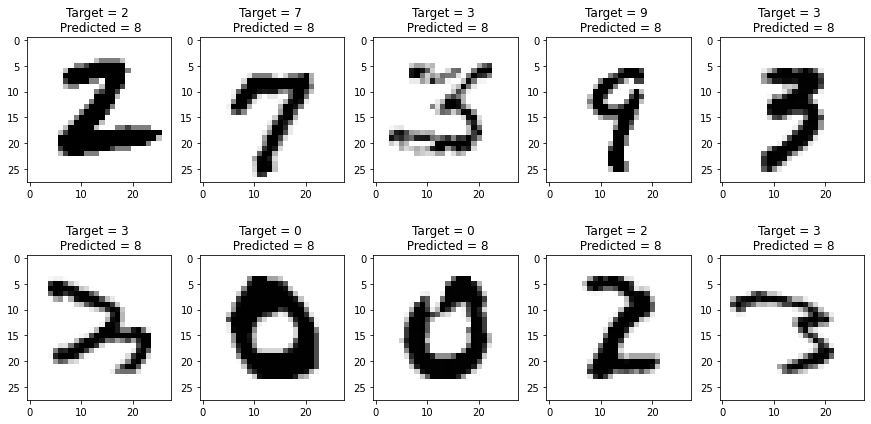

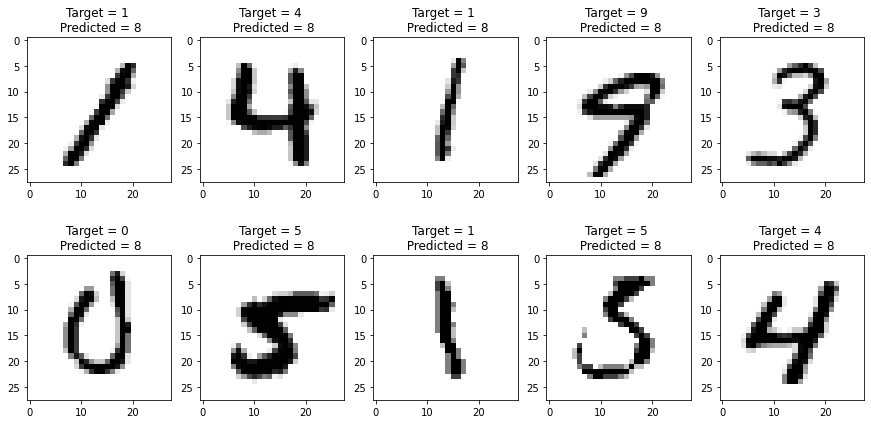

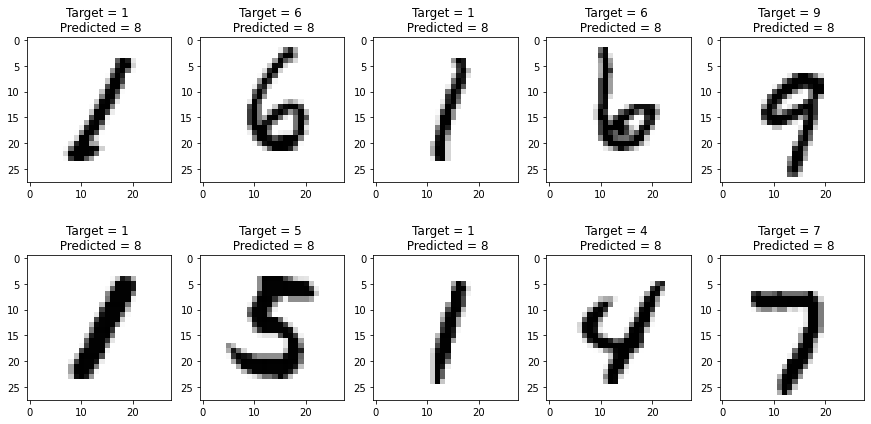

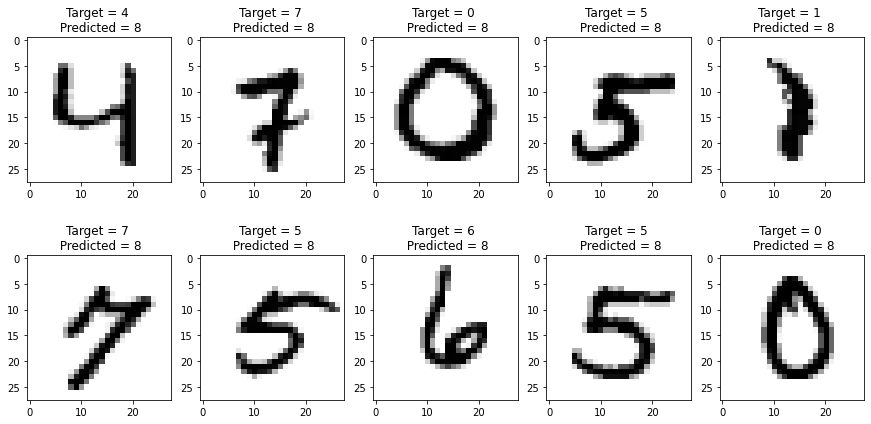

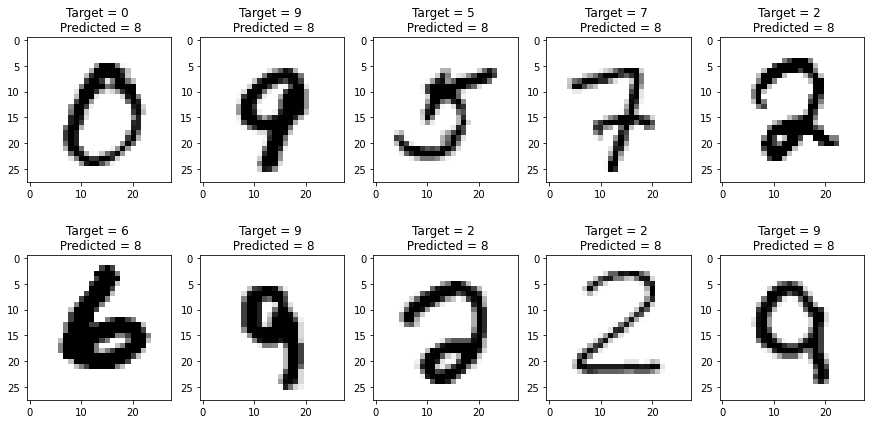

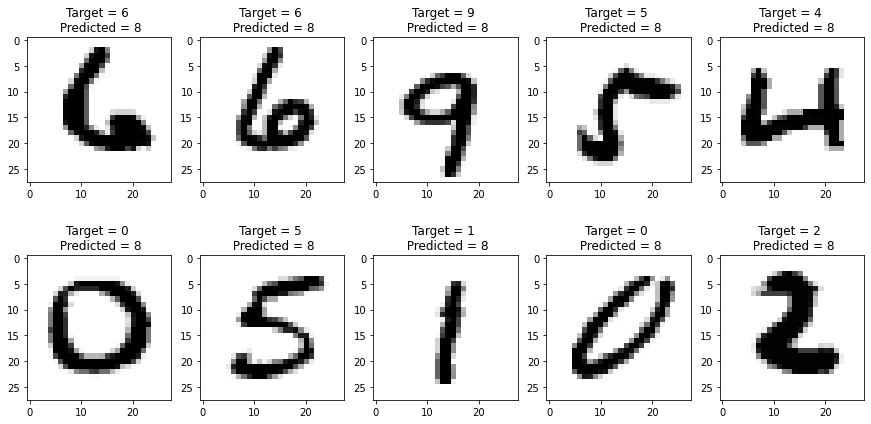

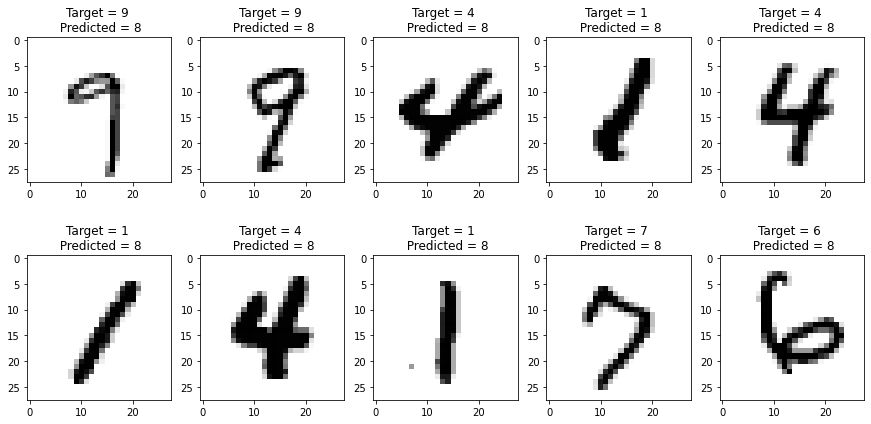

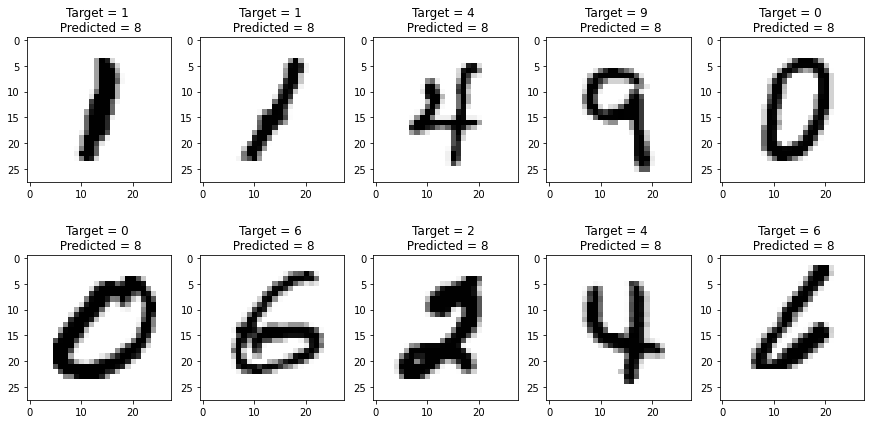

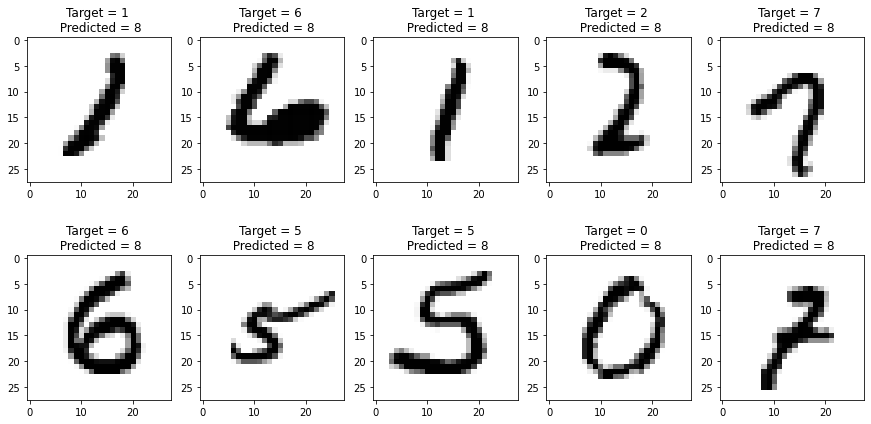

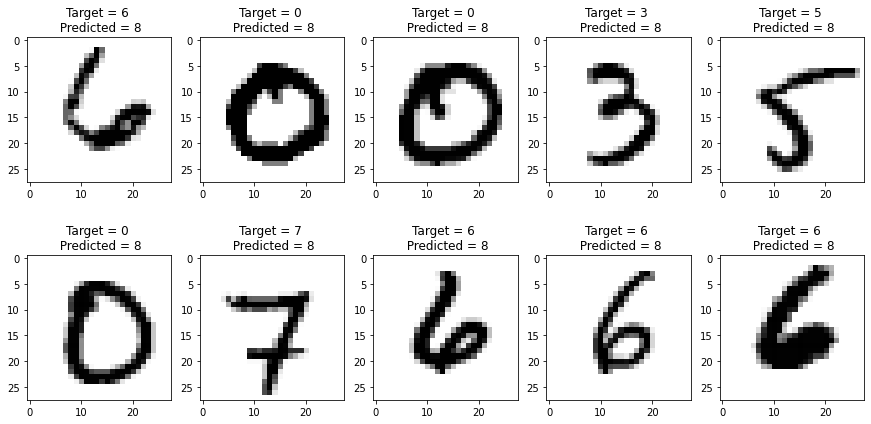

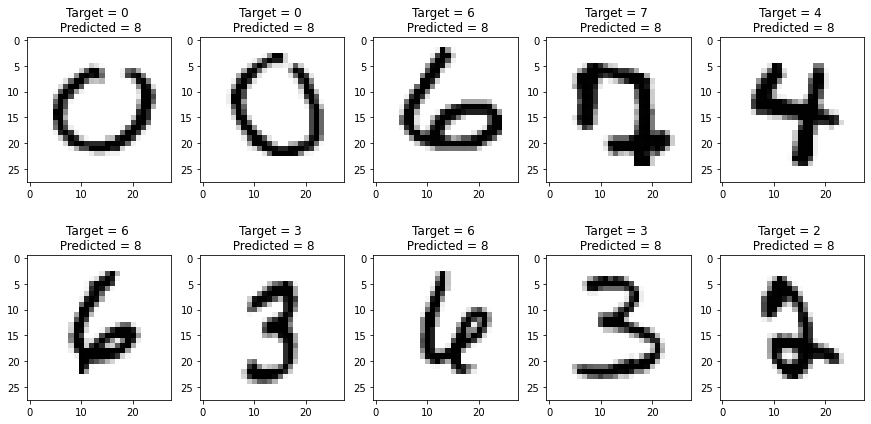

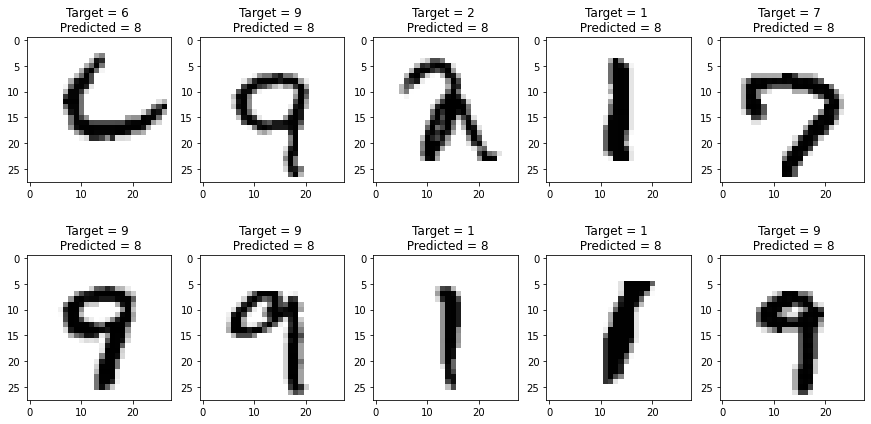

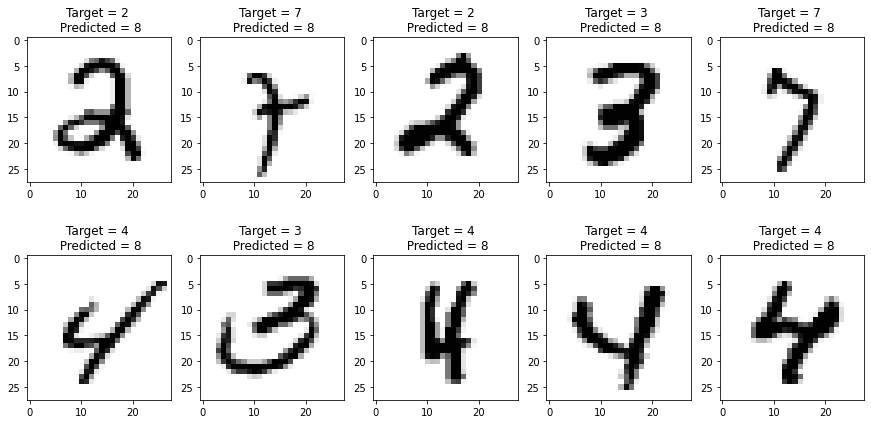

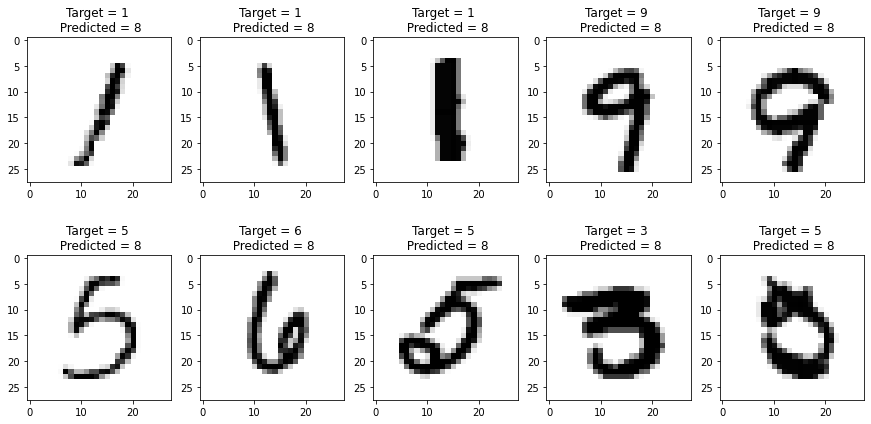

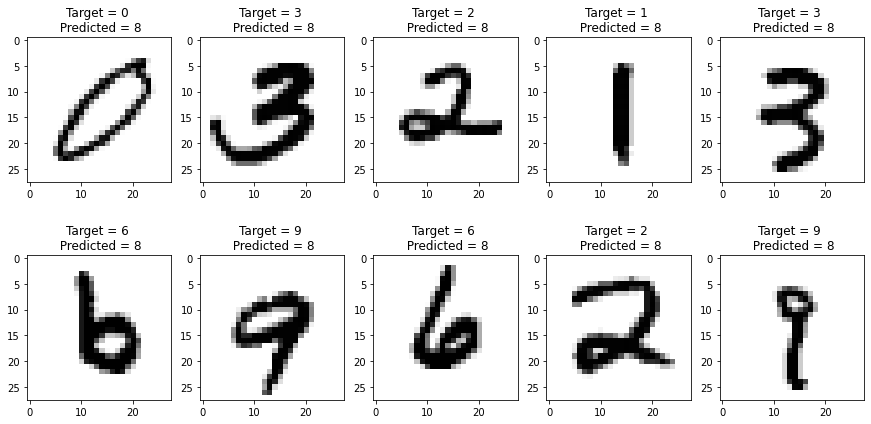

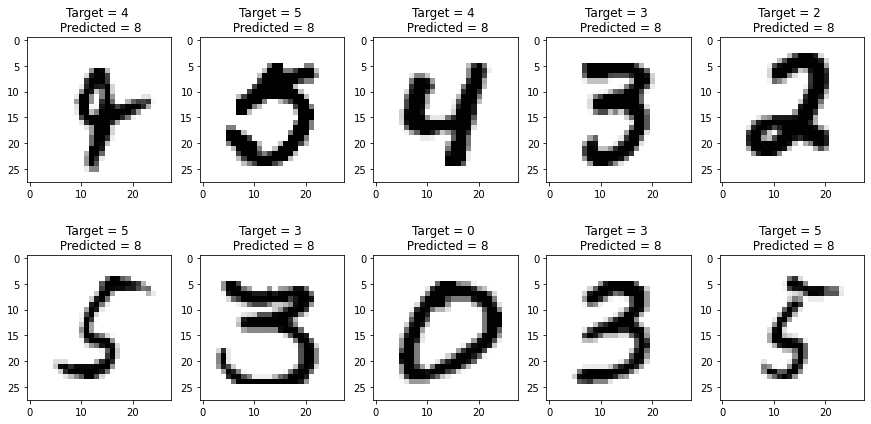

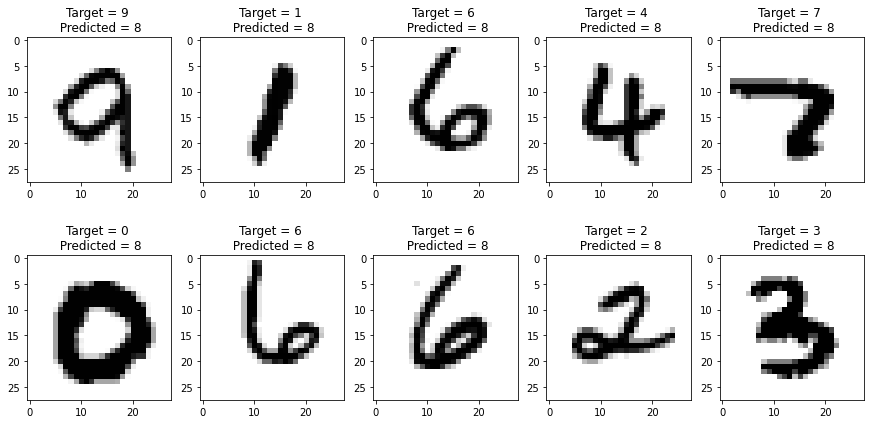

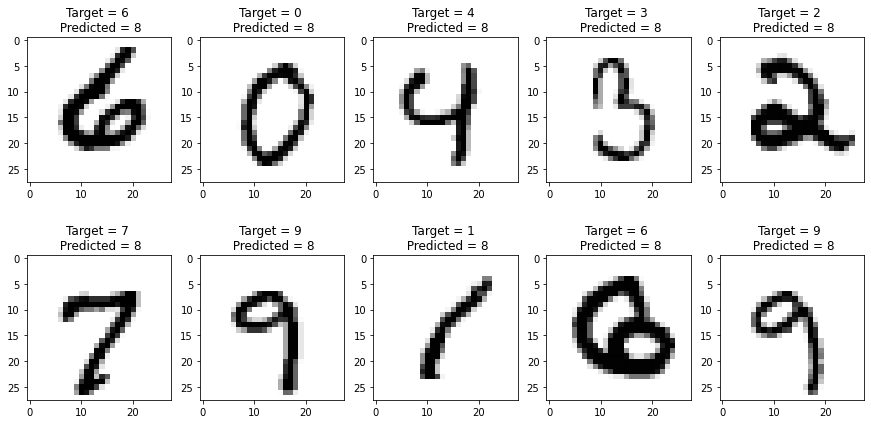

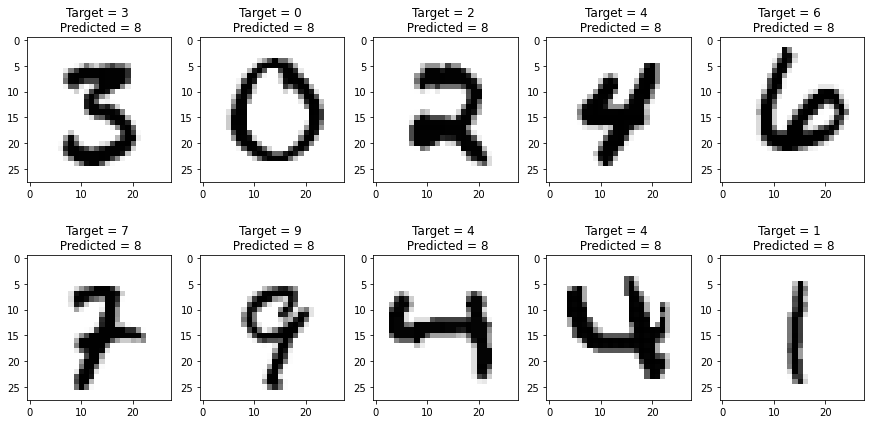

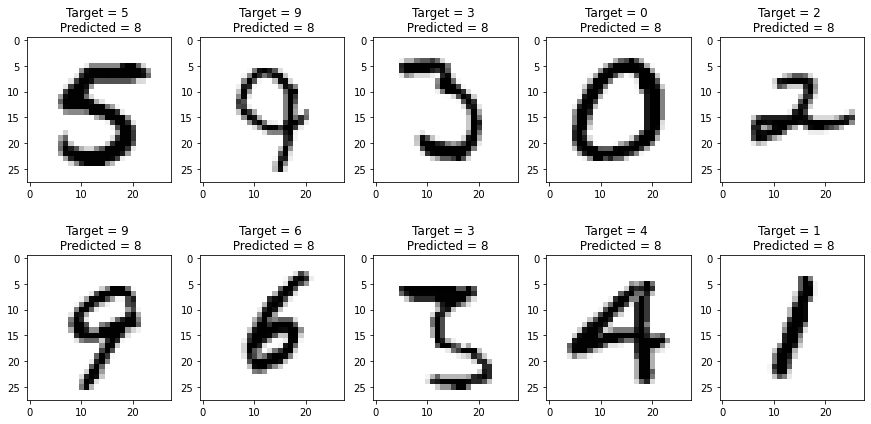

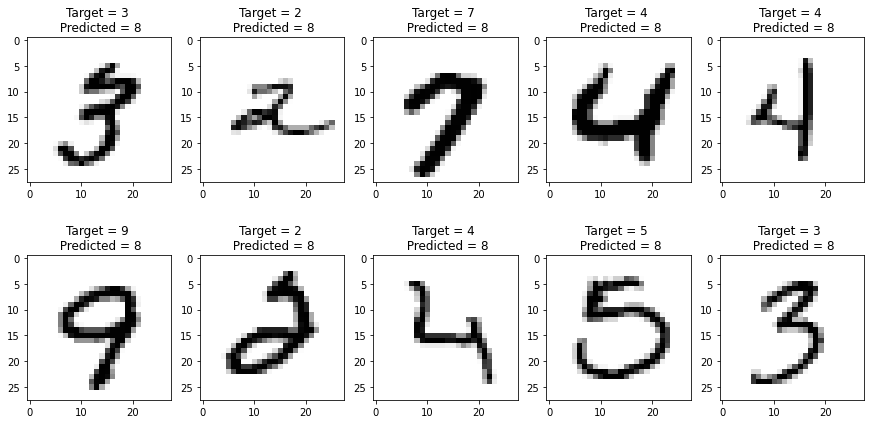

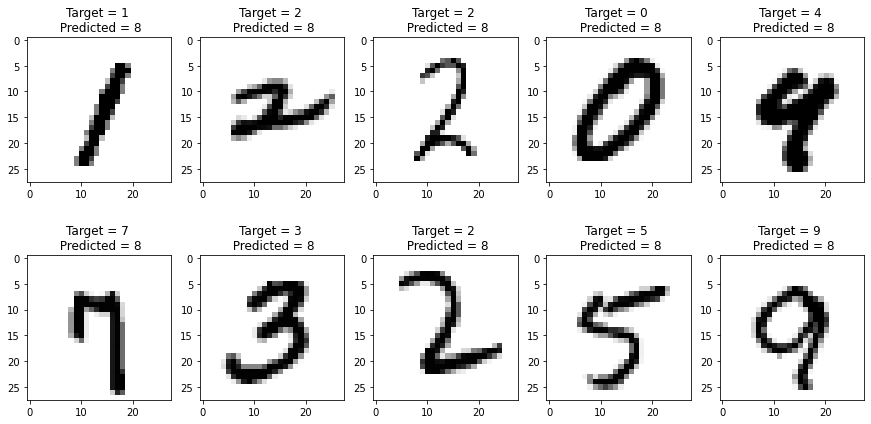

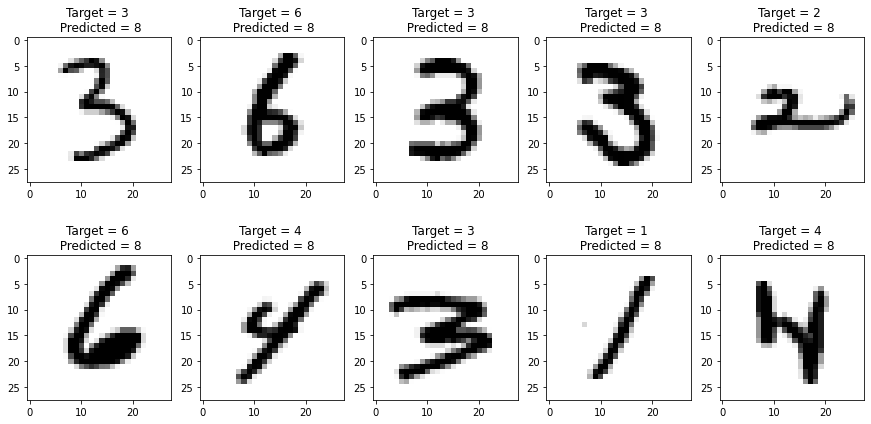

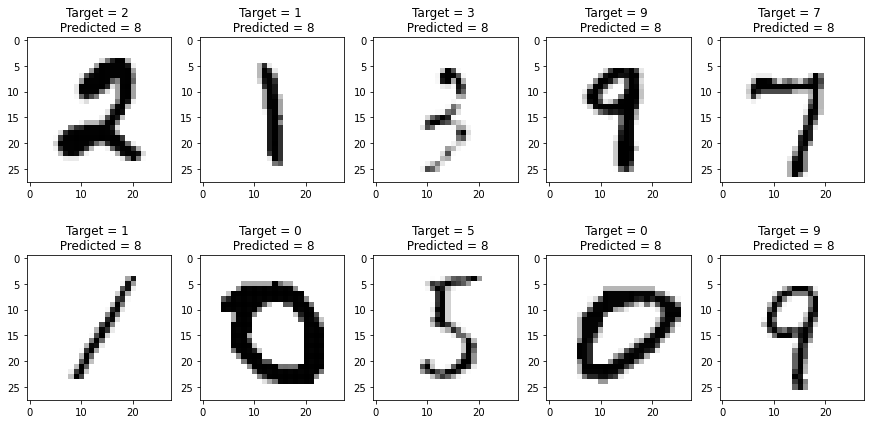

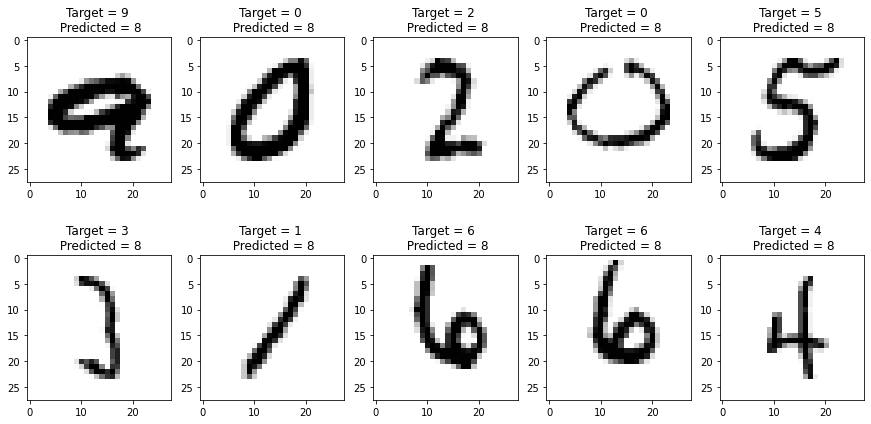

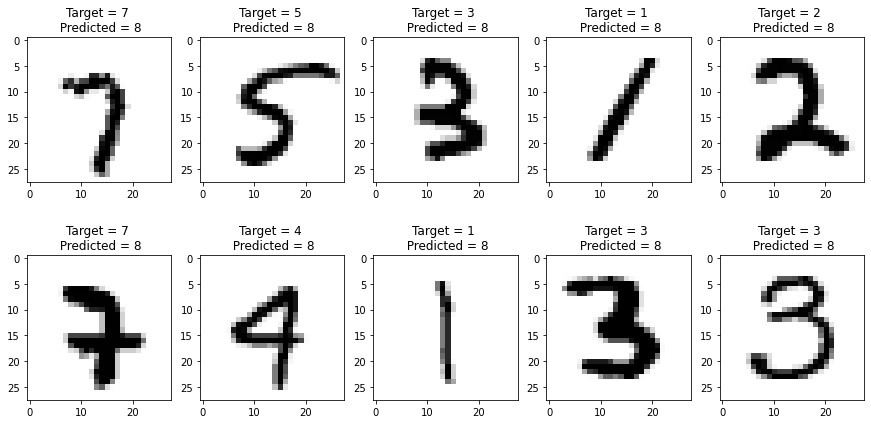

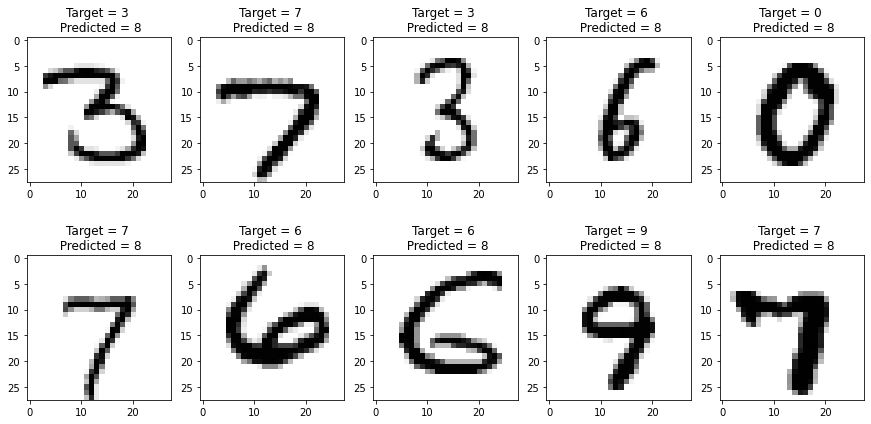

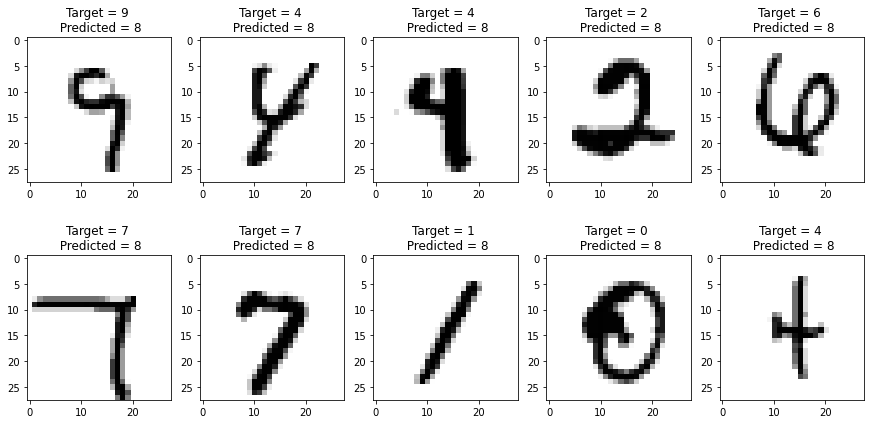

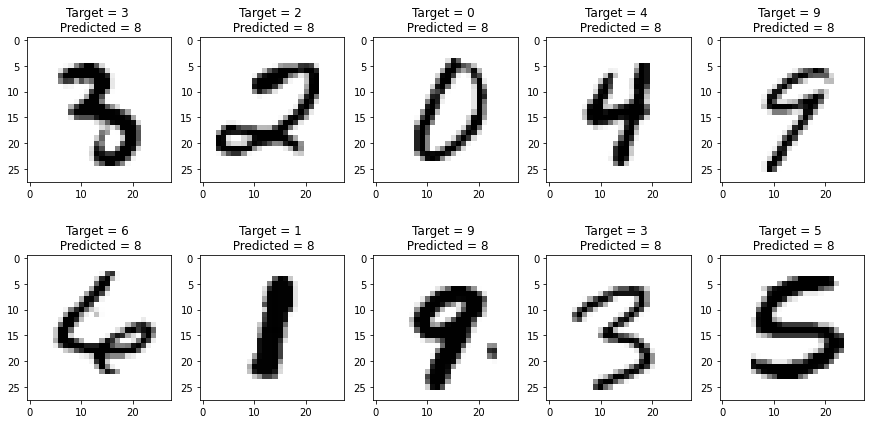

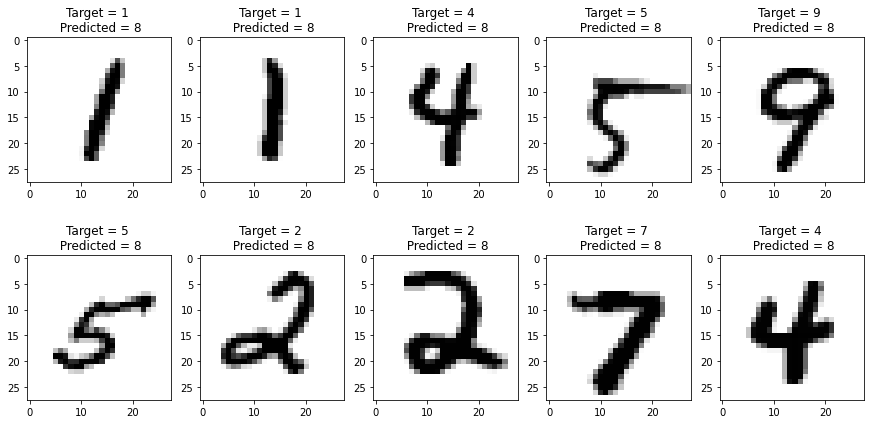

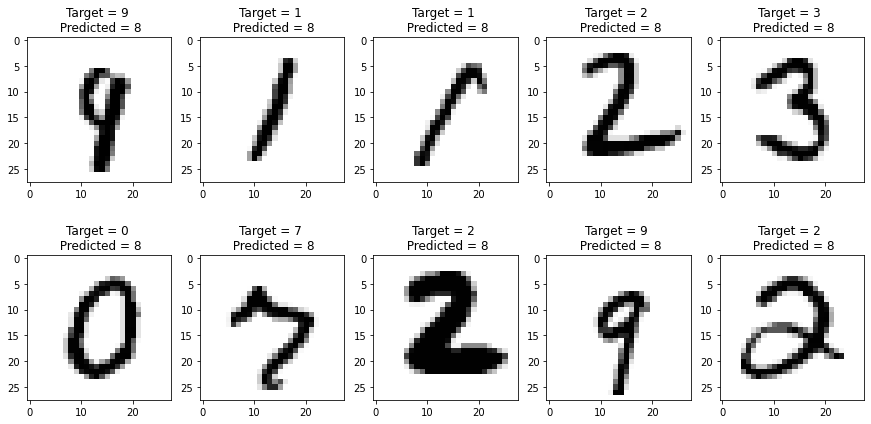

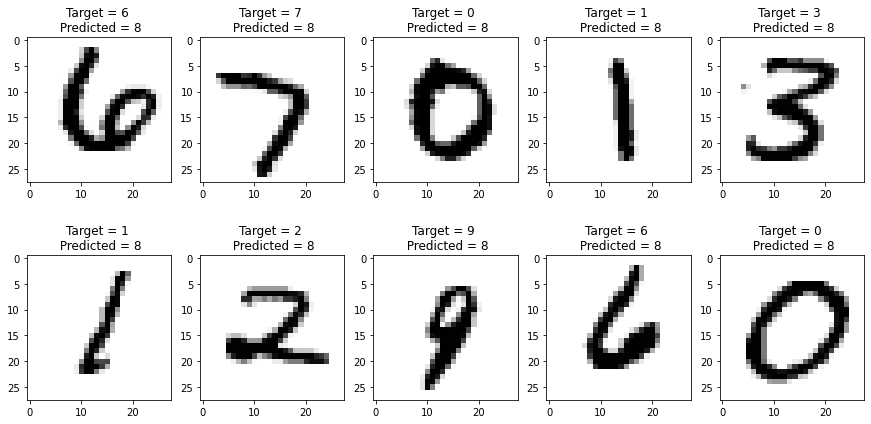

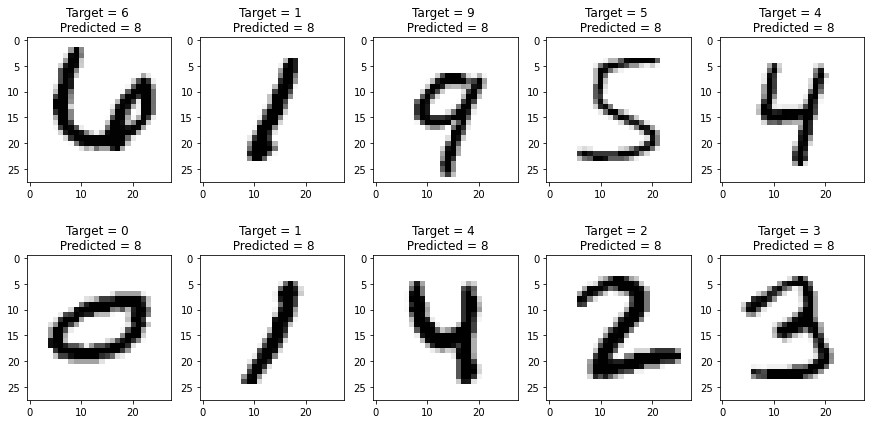

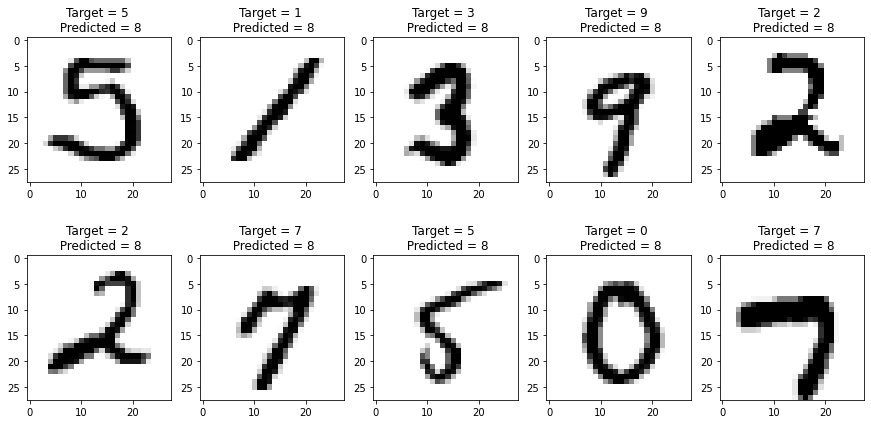

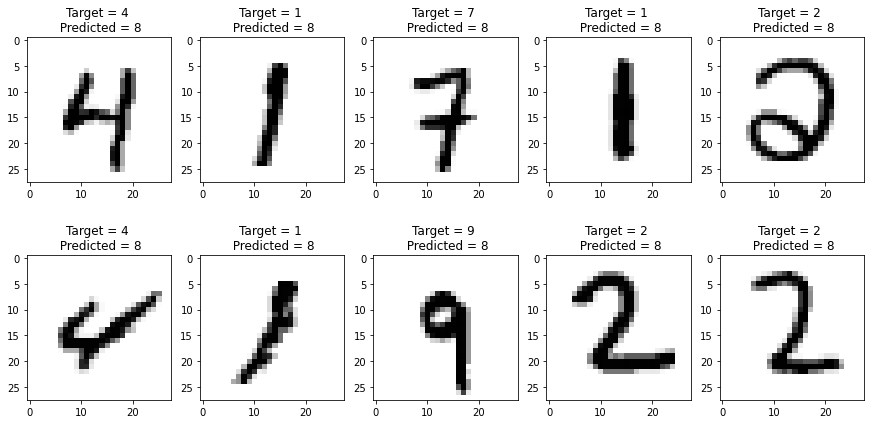

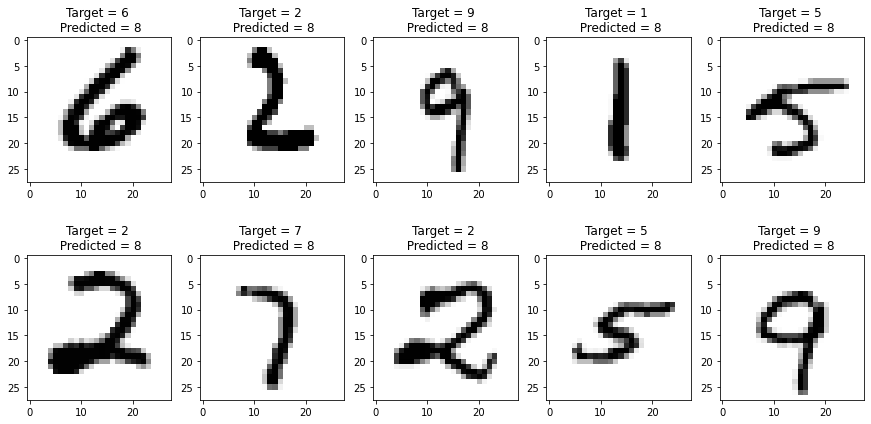

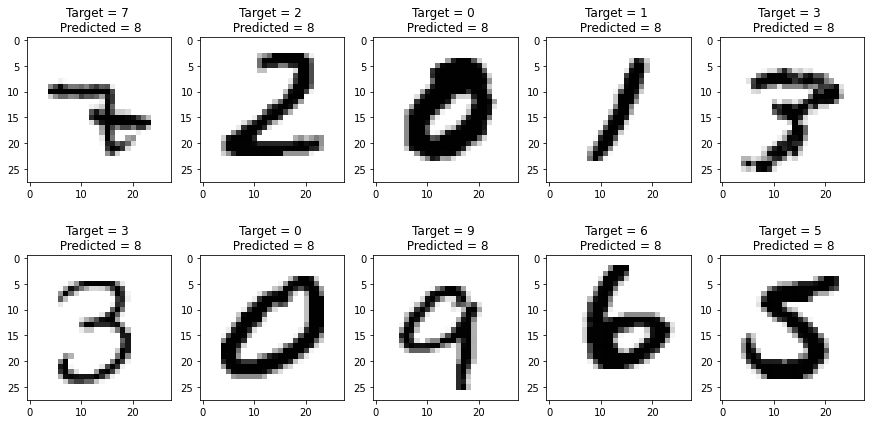

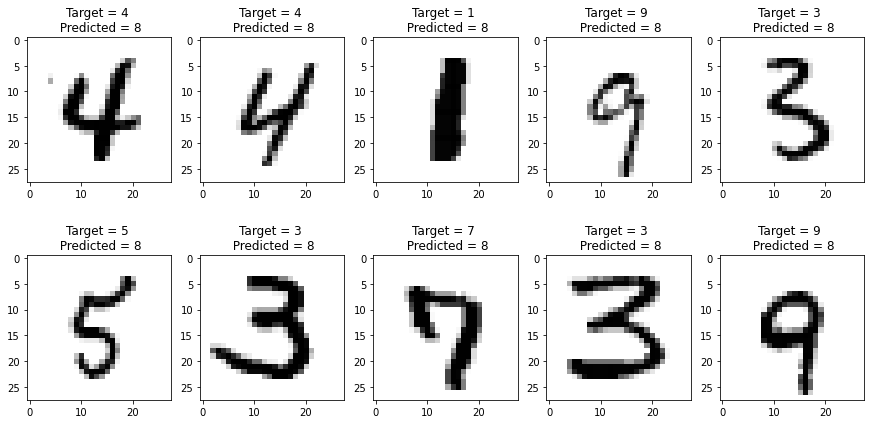

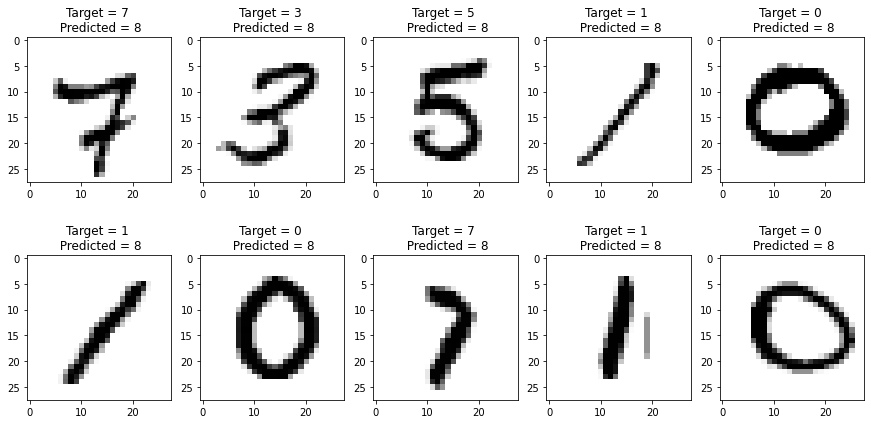

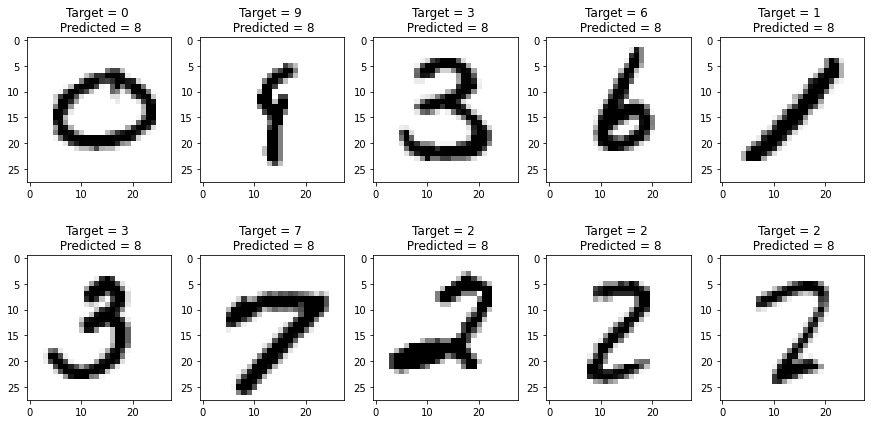

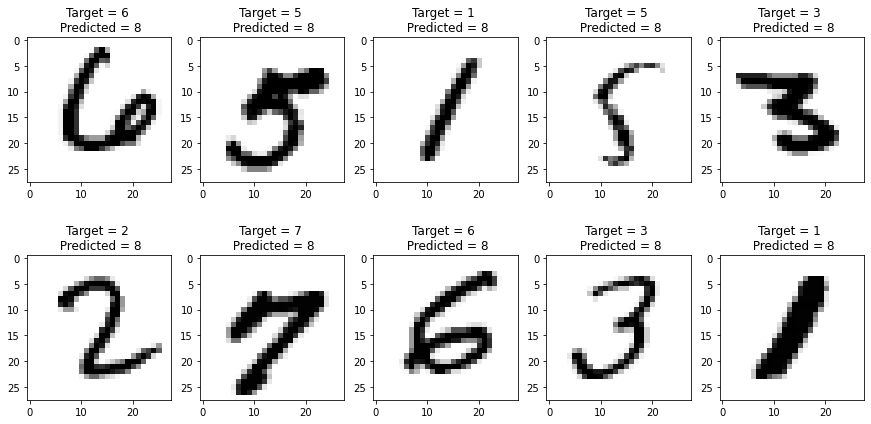

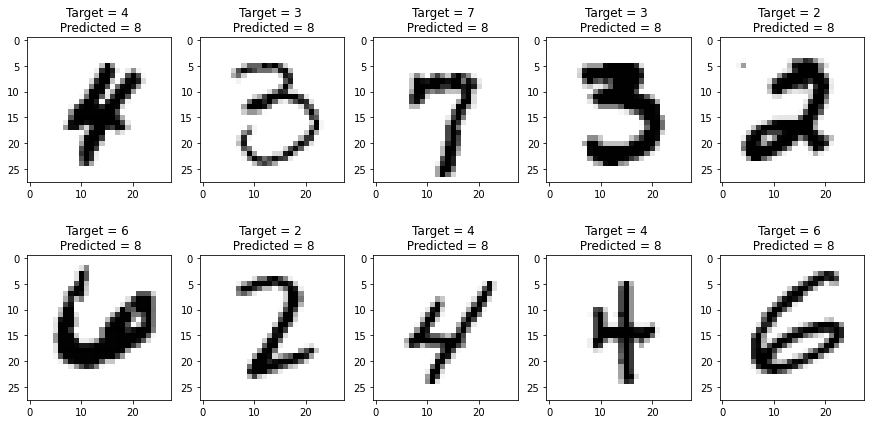

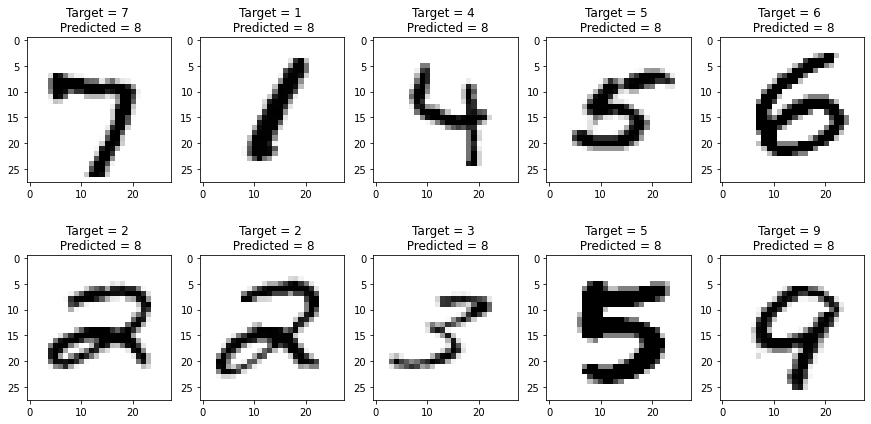

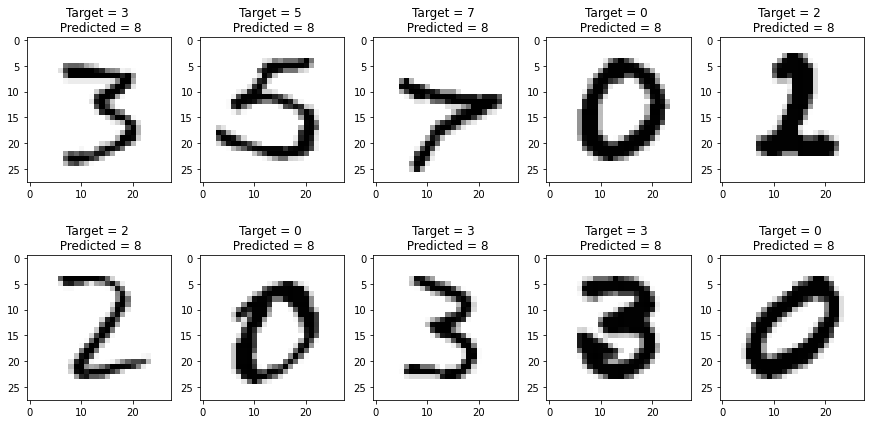

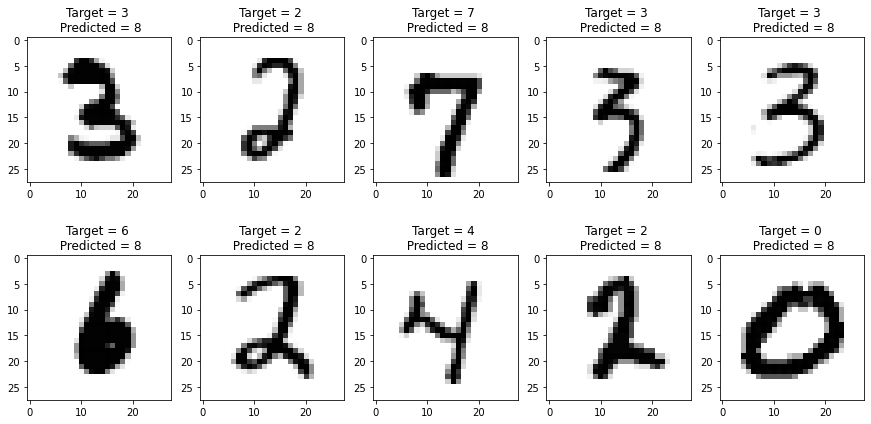

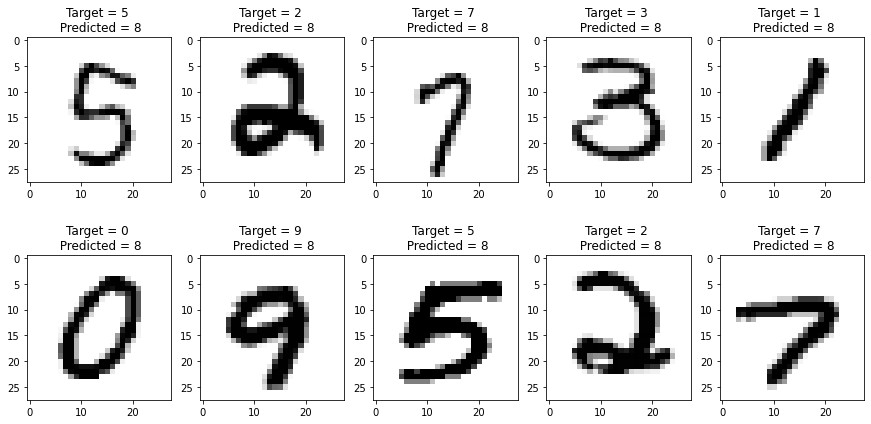

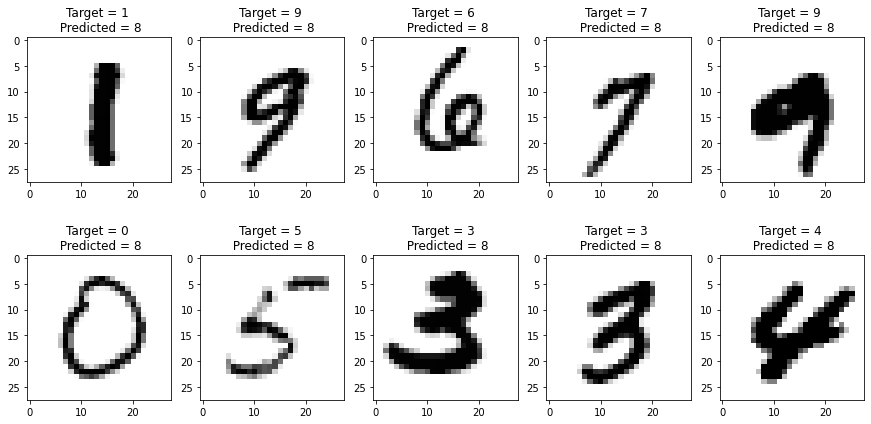

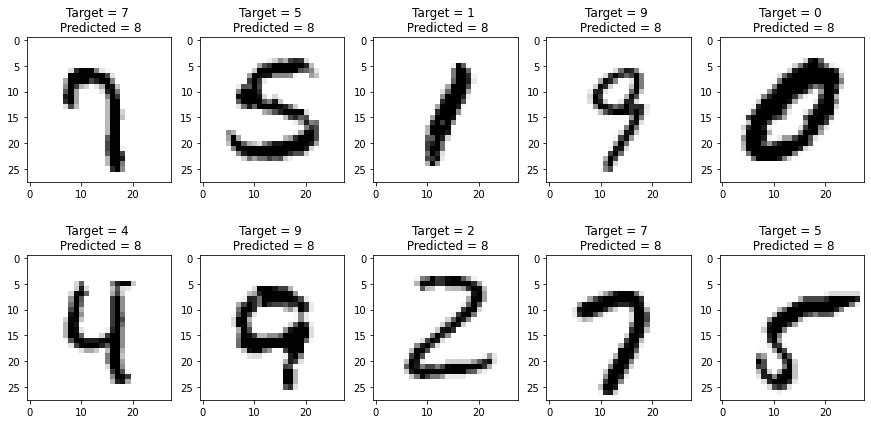

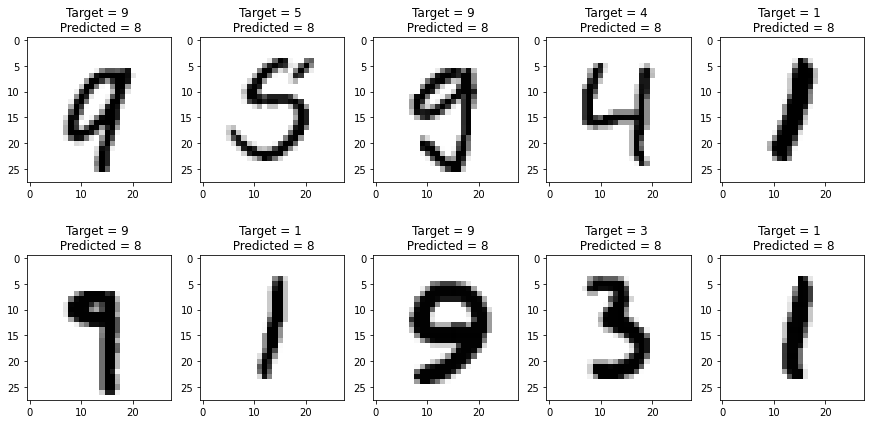

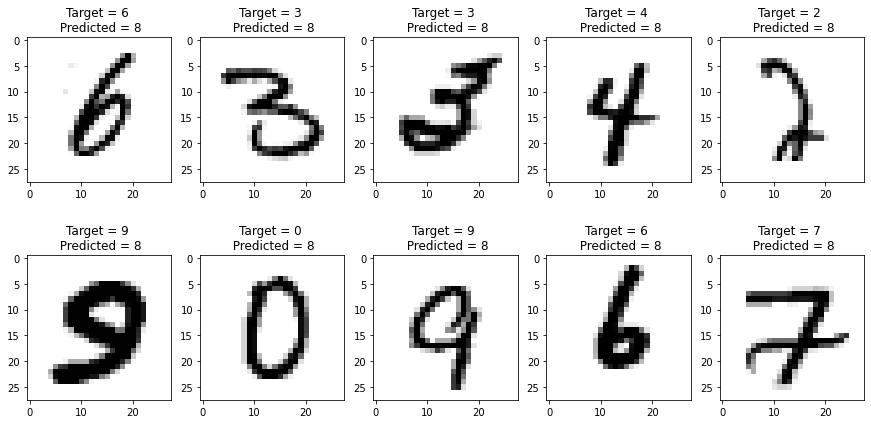

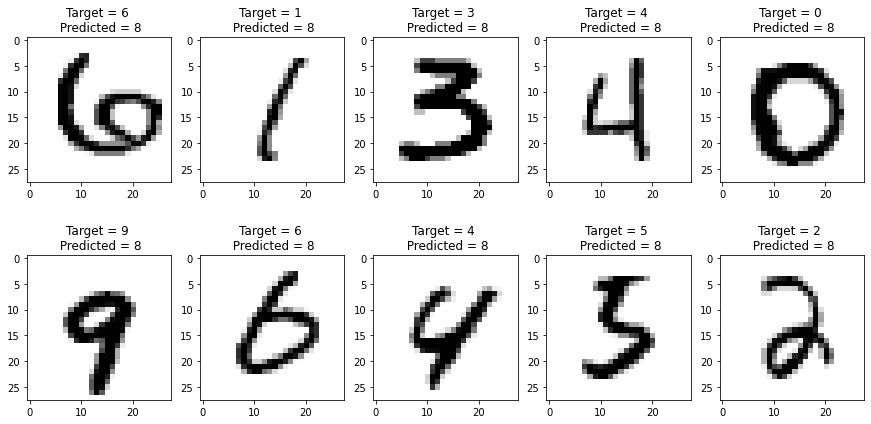

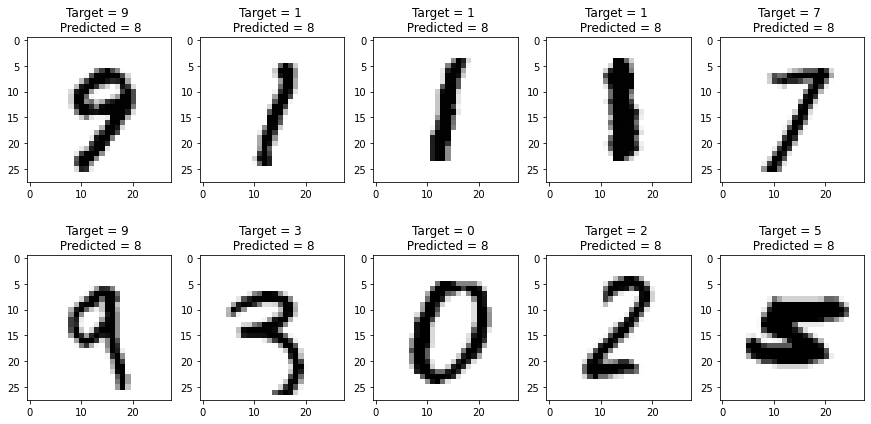

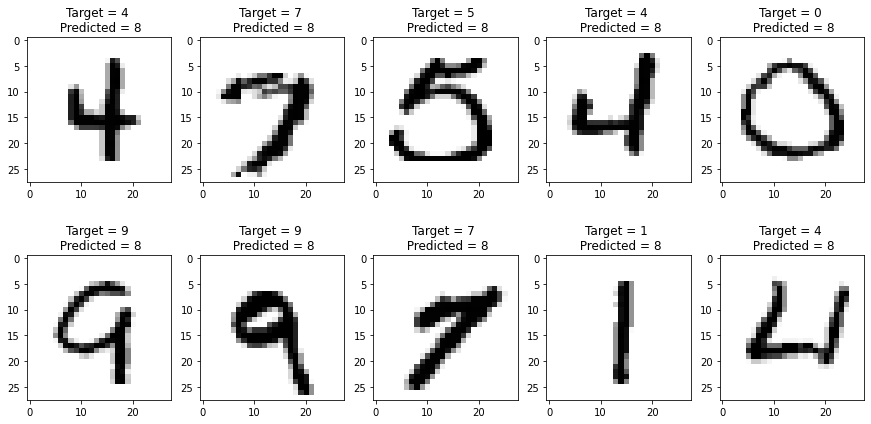

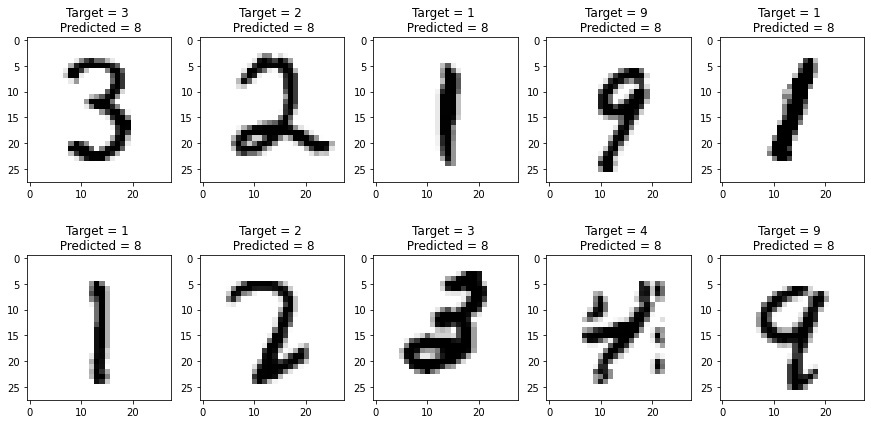

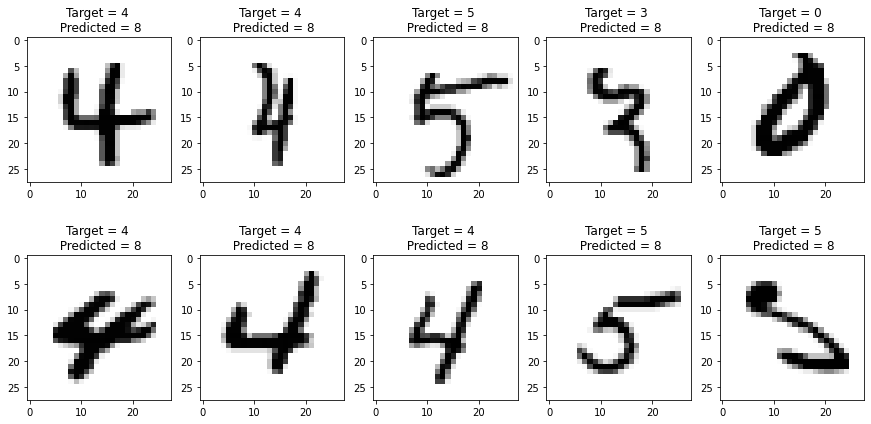

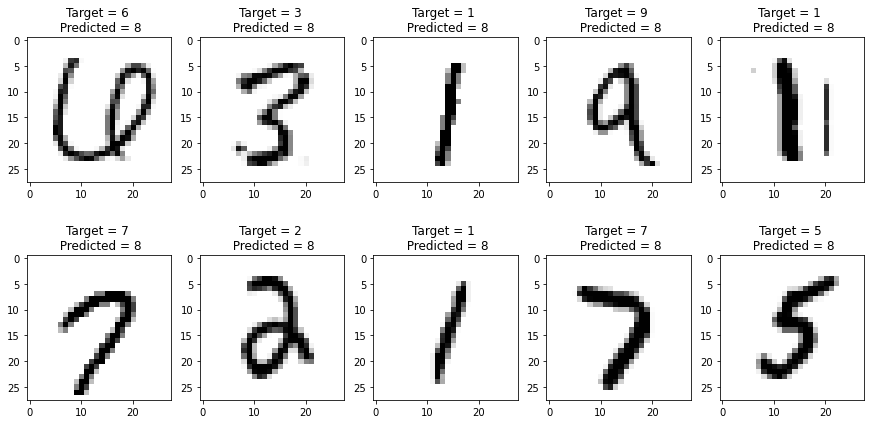

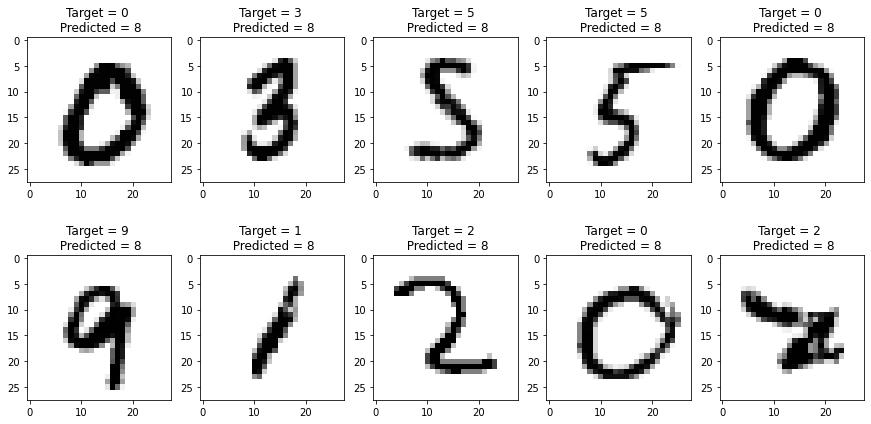

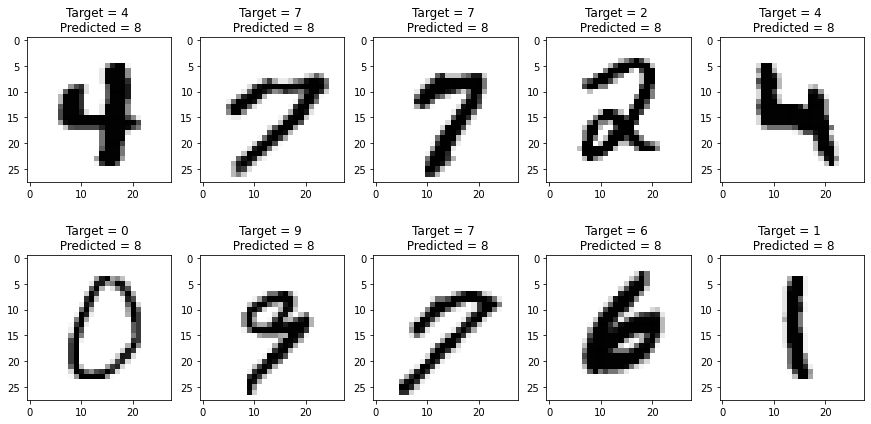

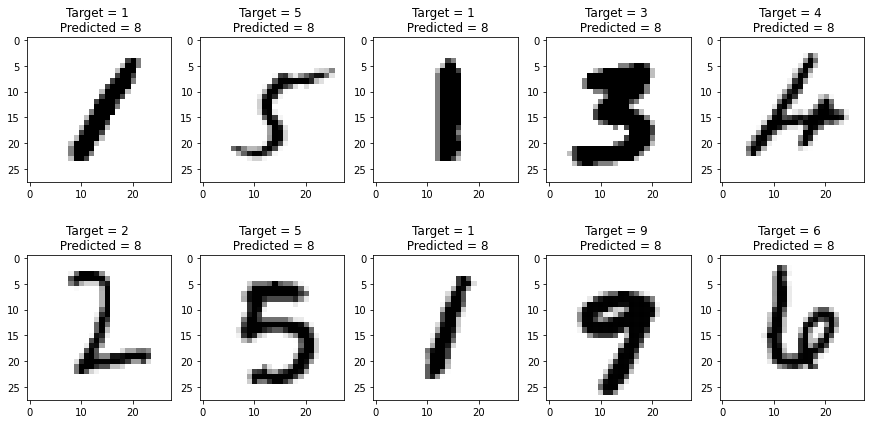

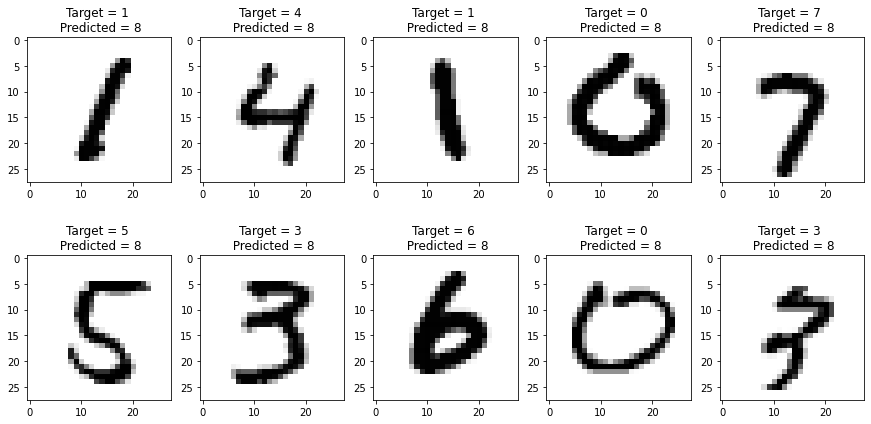

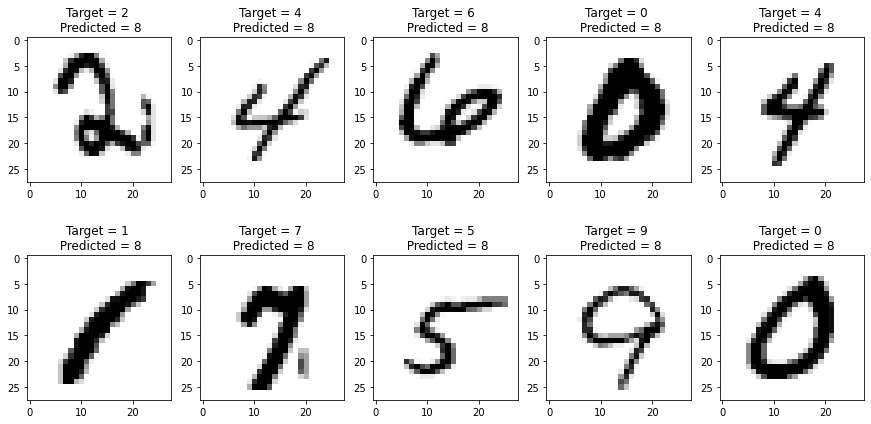

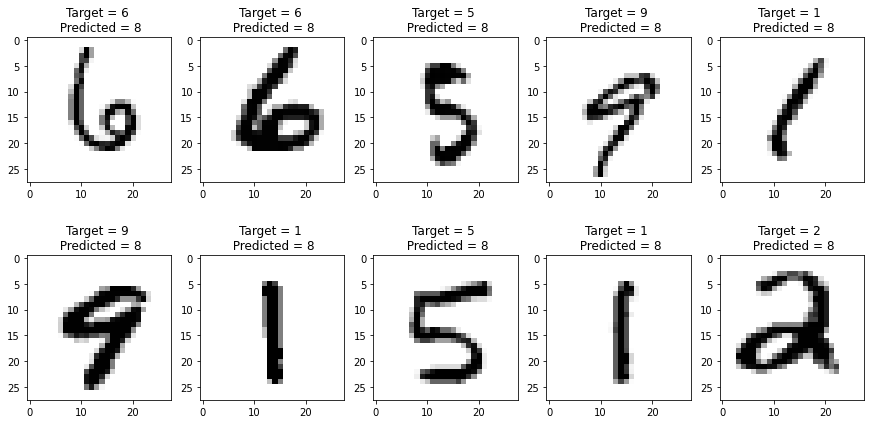

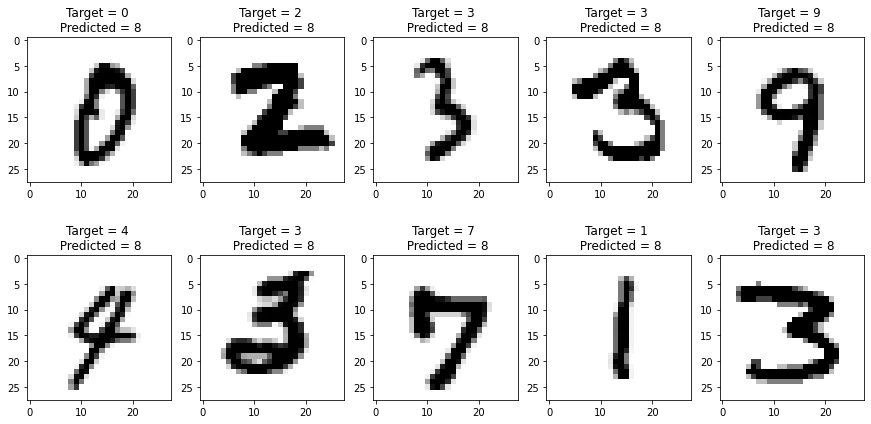

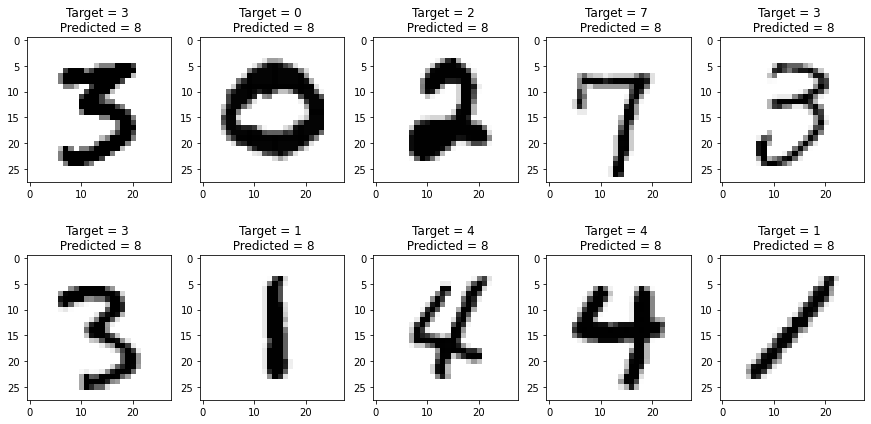

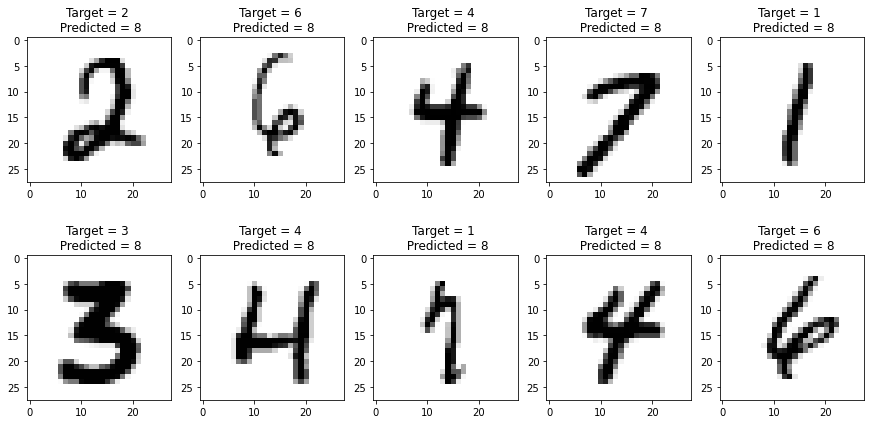

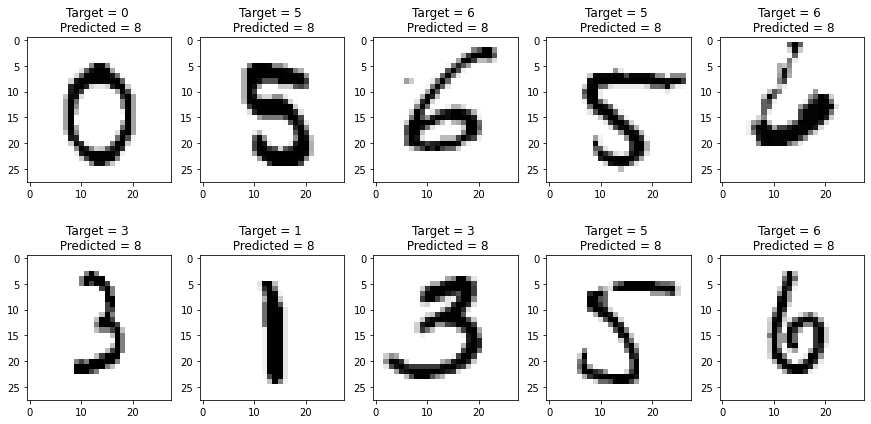

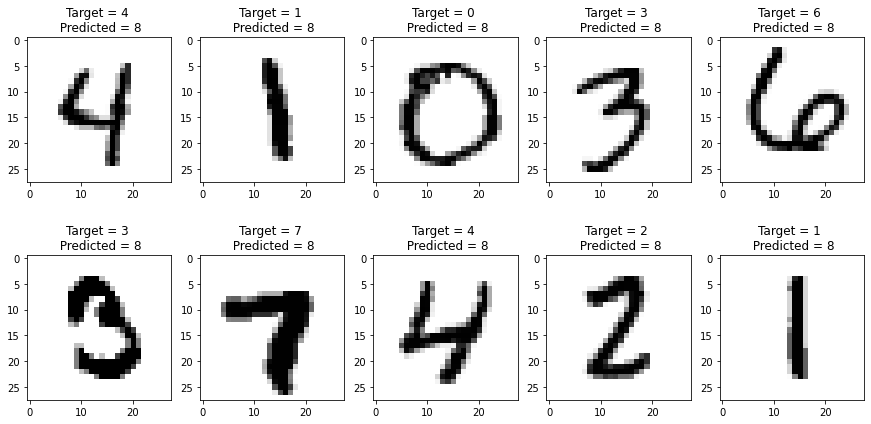

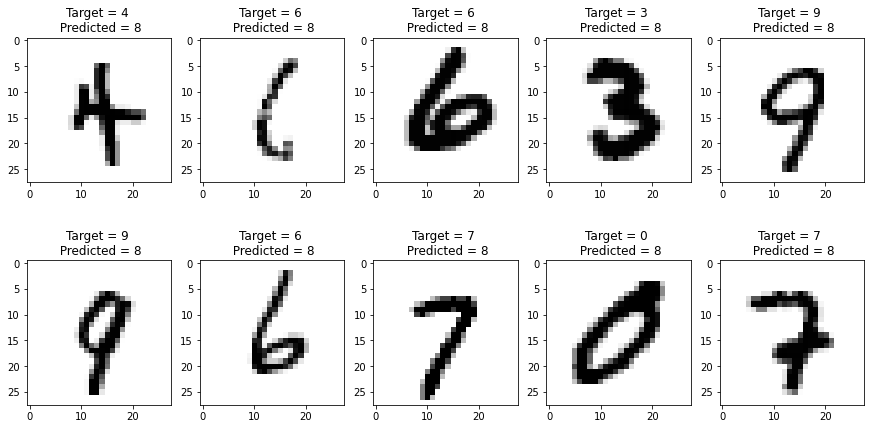

---------------------------------------------------------------

Misclassified files => Model with NormalizationType => NormType.LAYER_NORM

---------------------------------------------------------------



********* Misclassified Images **************





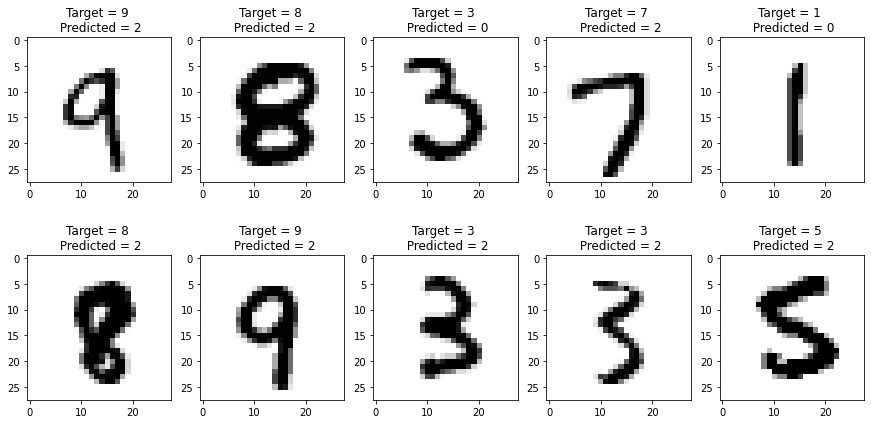

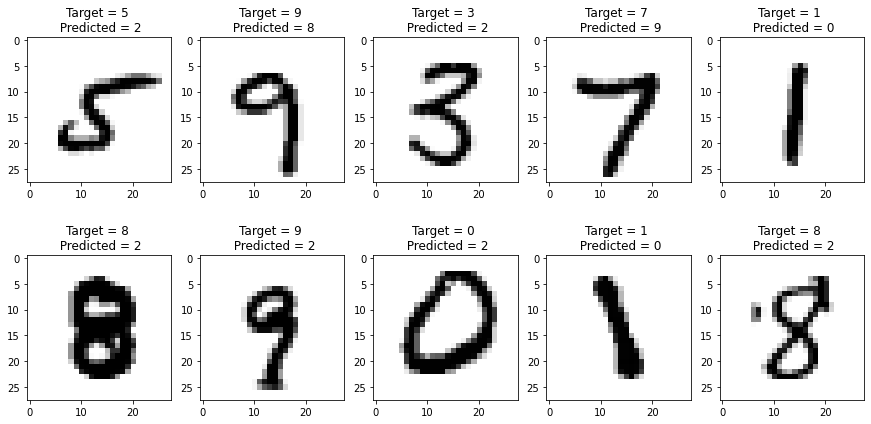

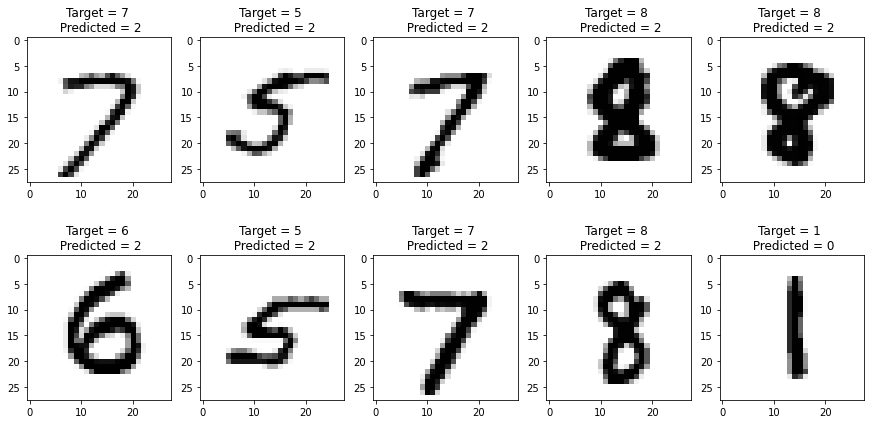

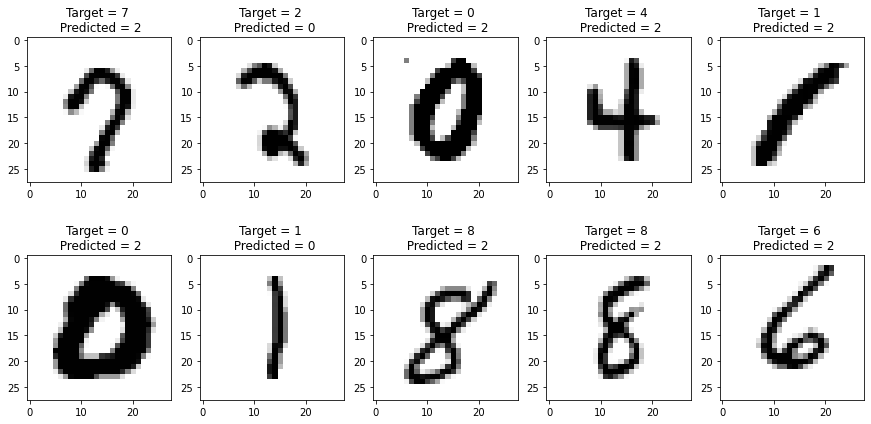

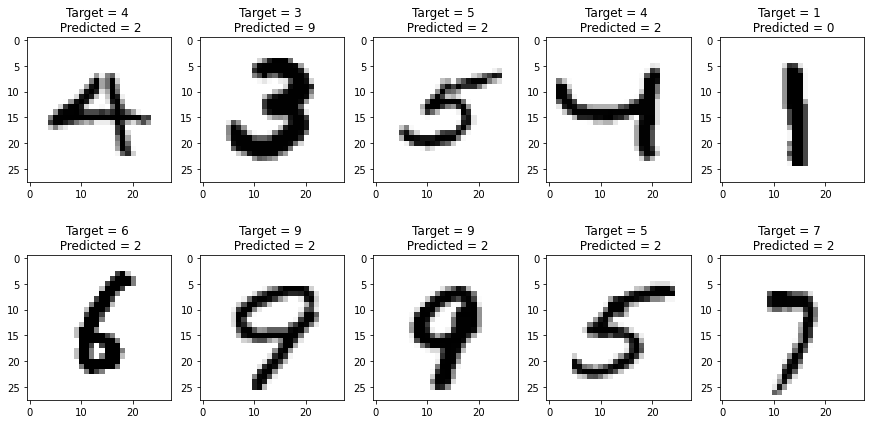

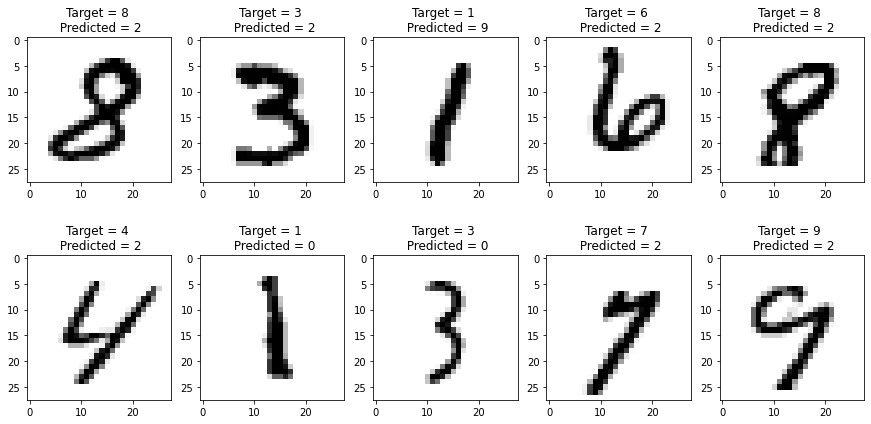

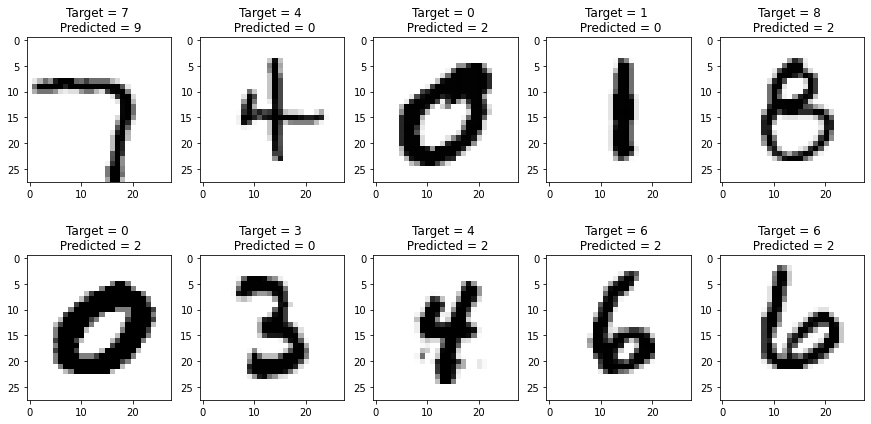

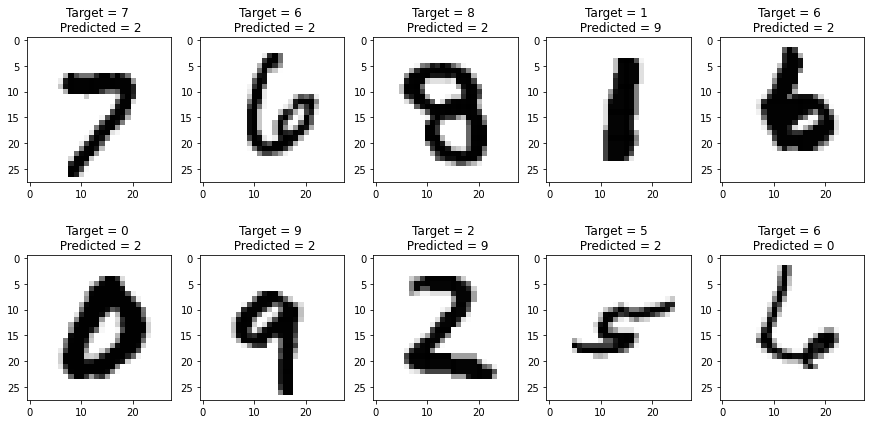

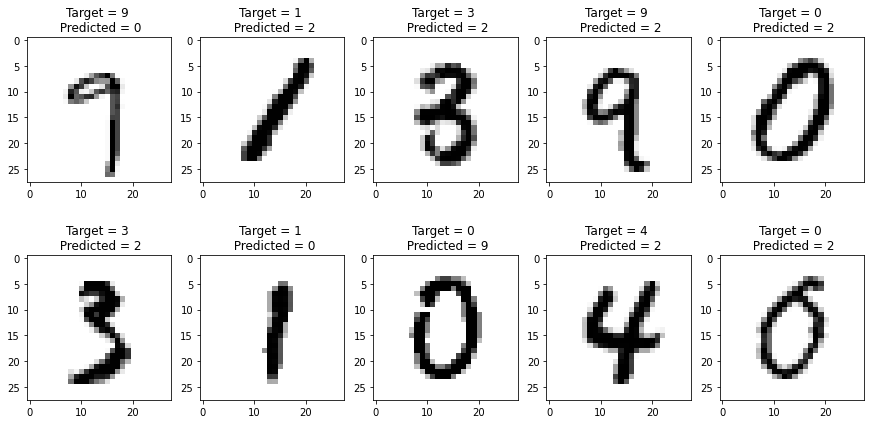

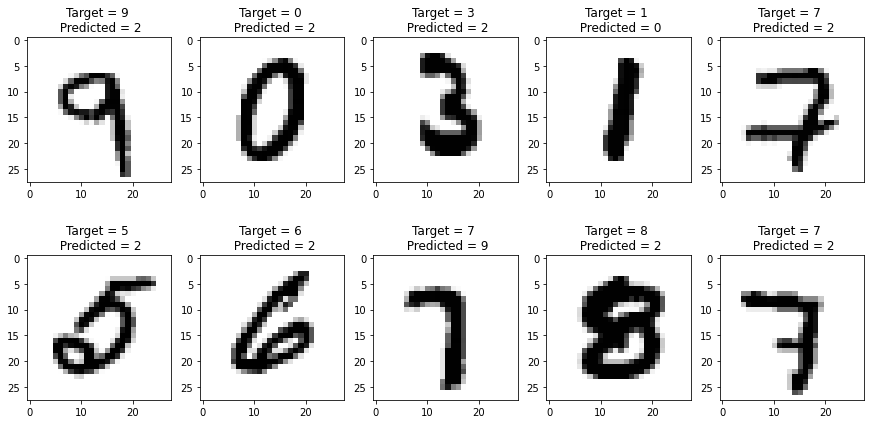

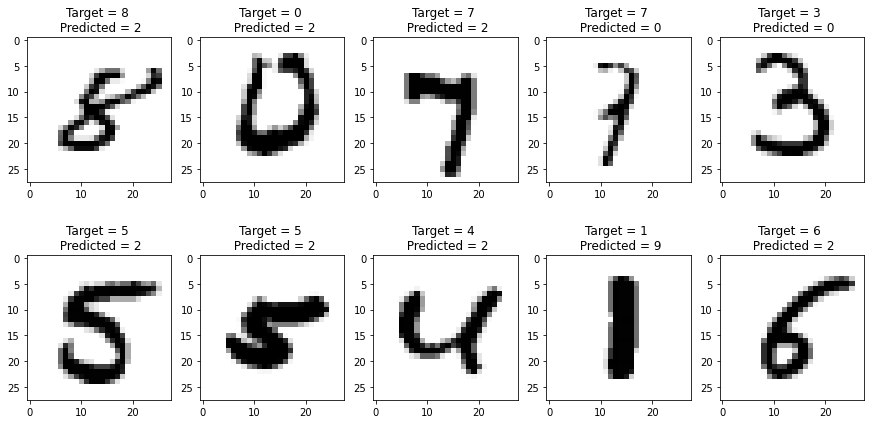

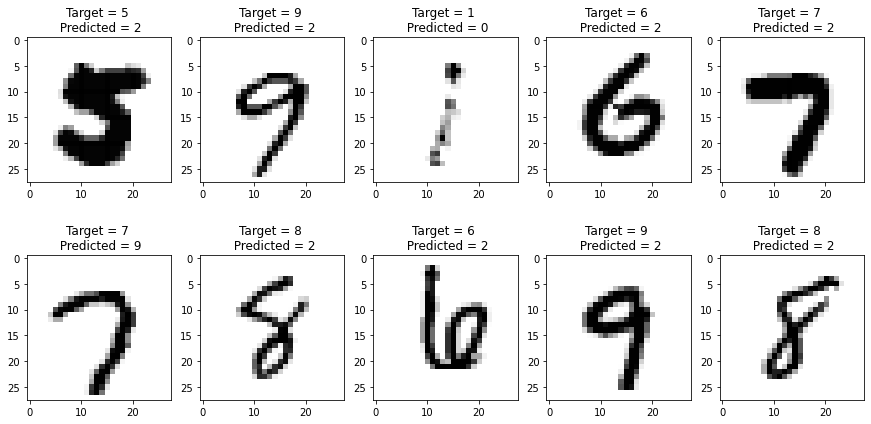

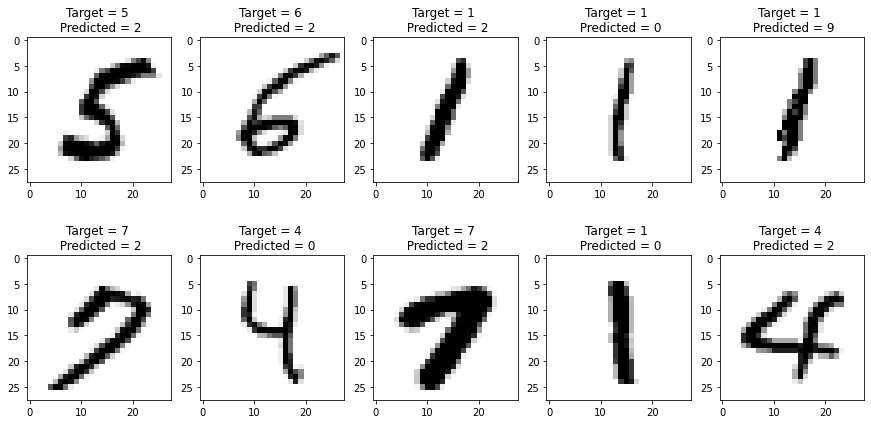

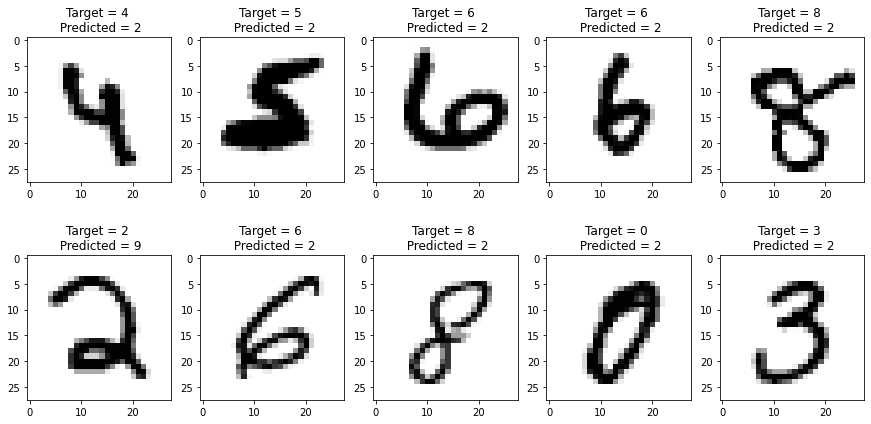

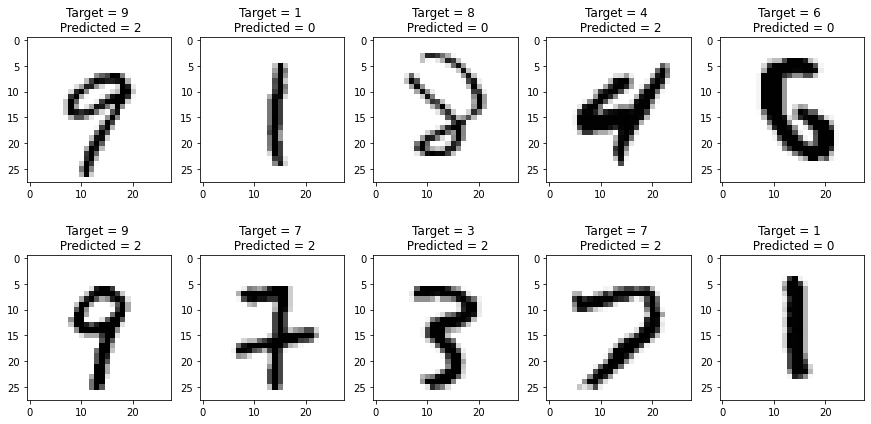

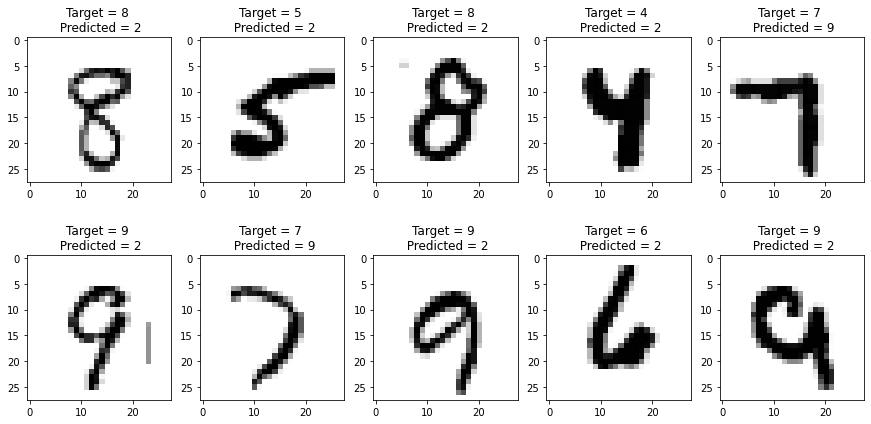

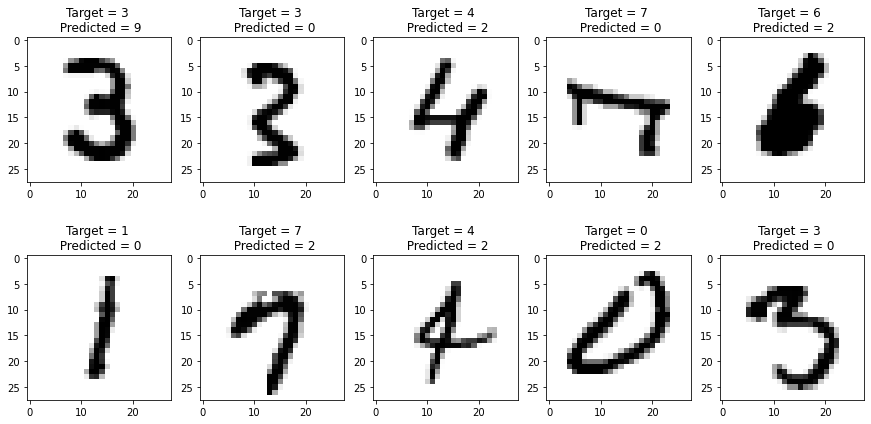

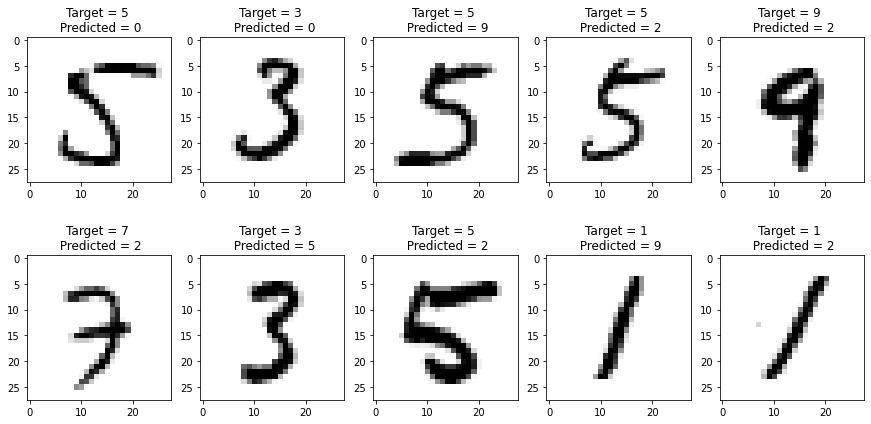

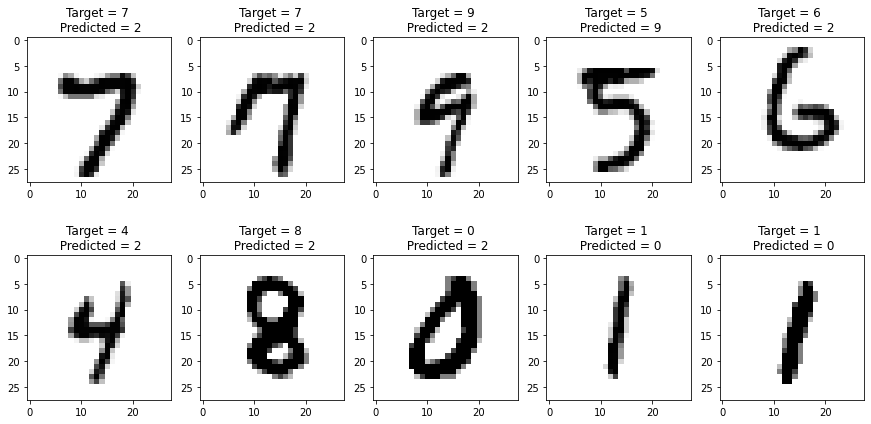

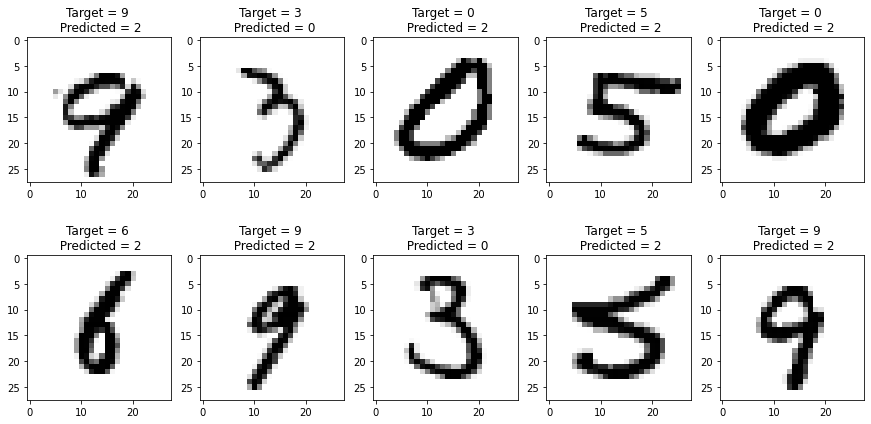

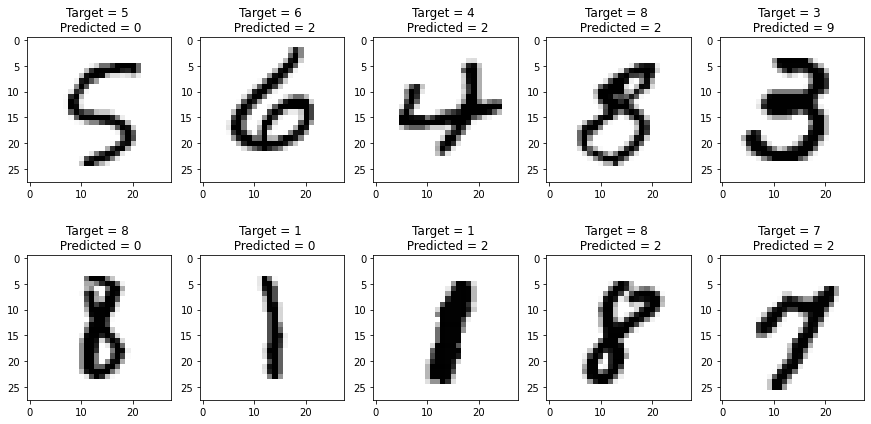

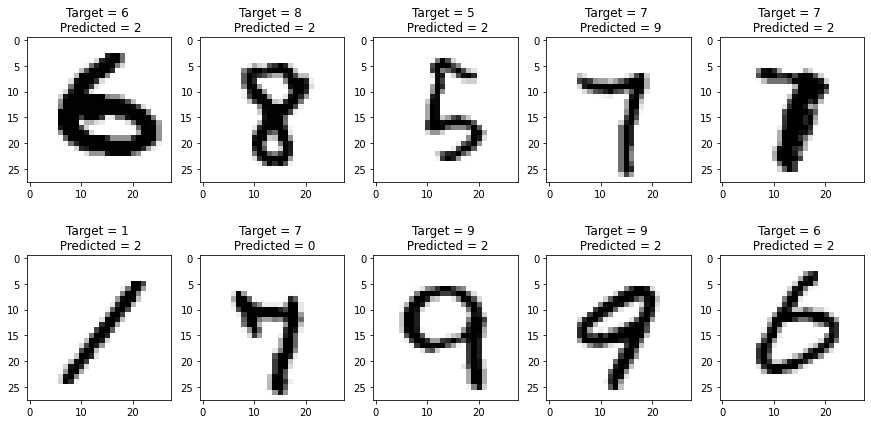

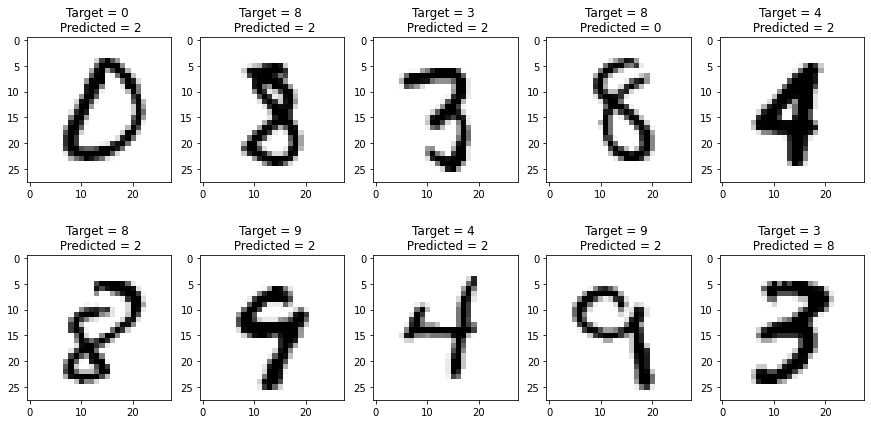

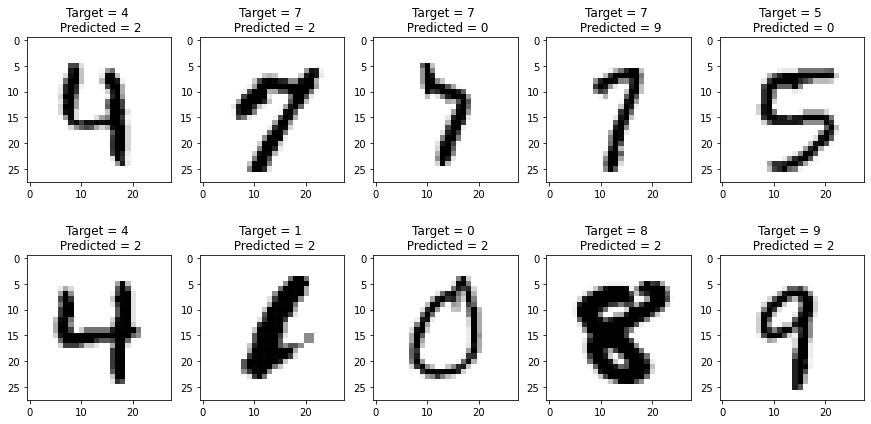

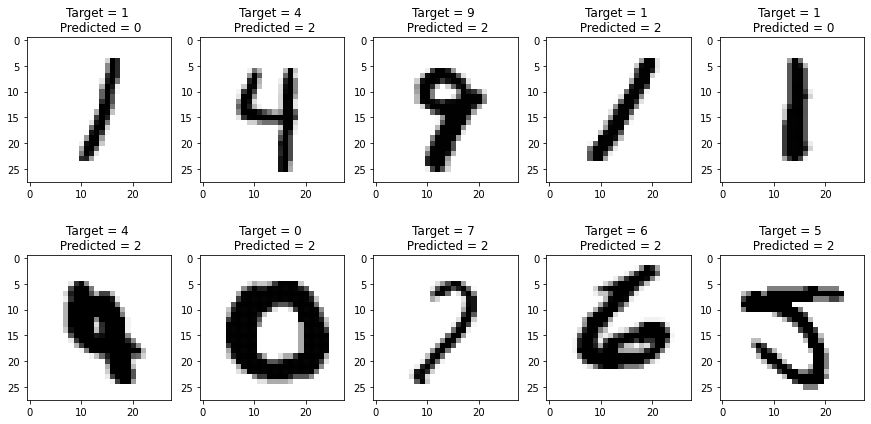

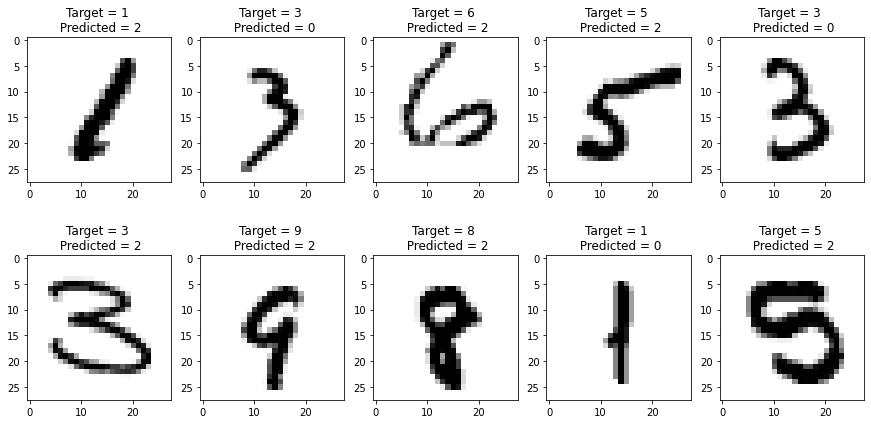

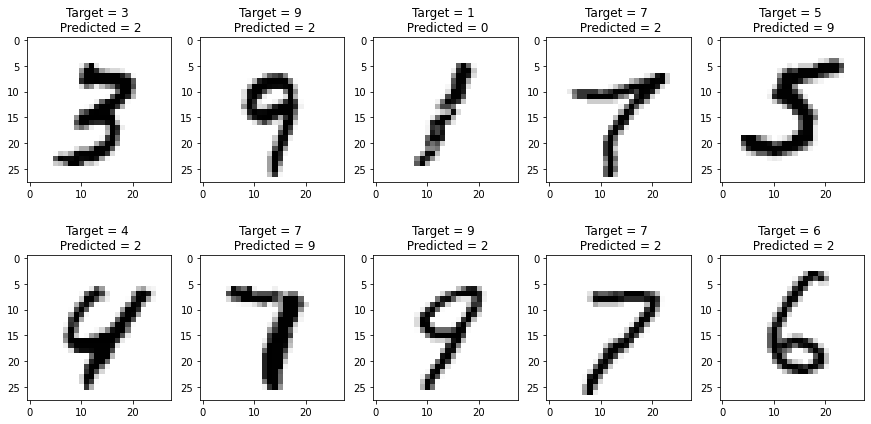

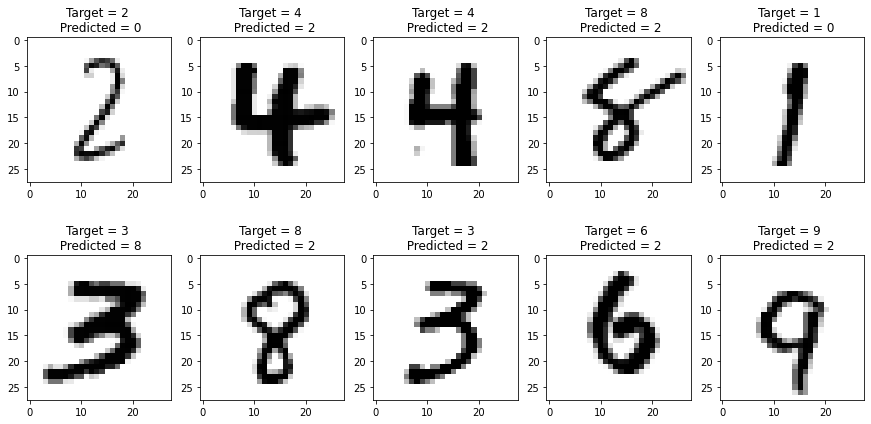

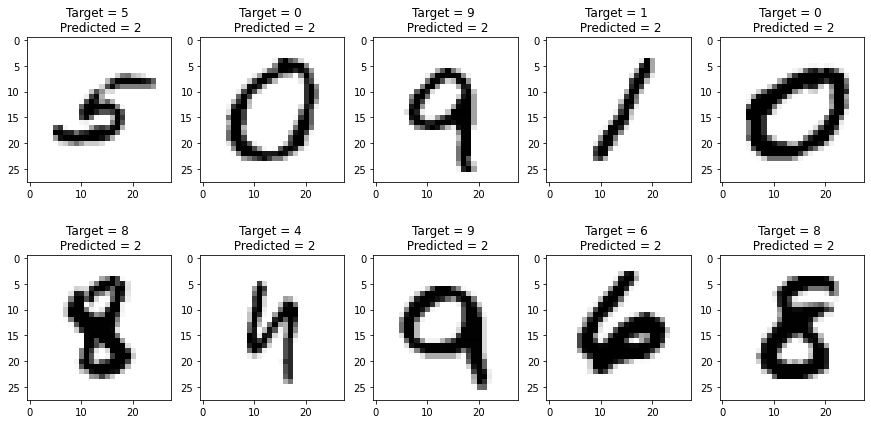

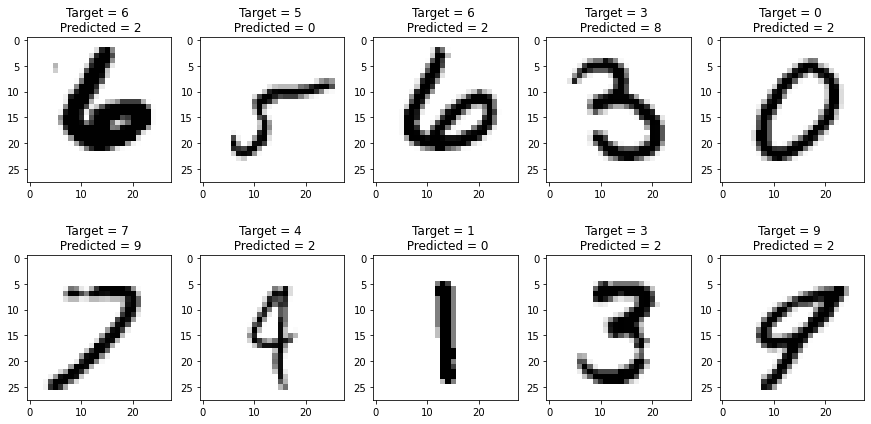

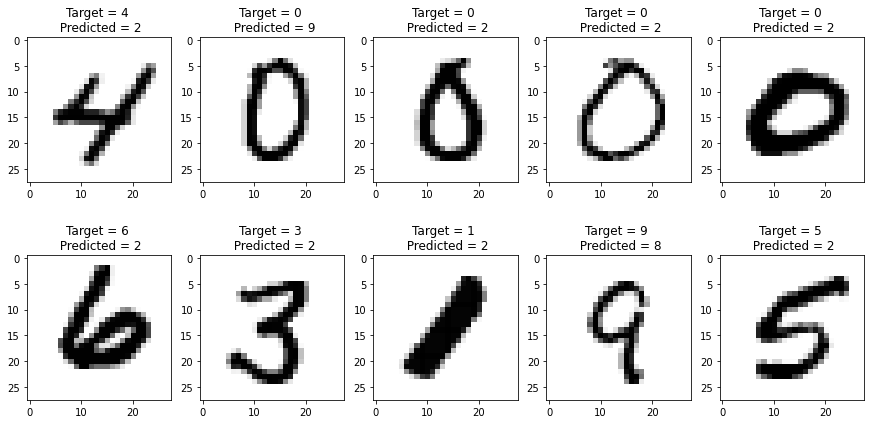

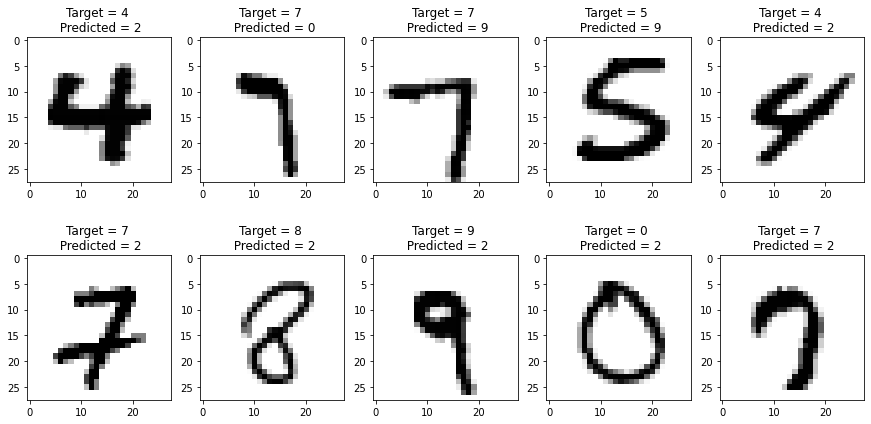

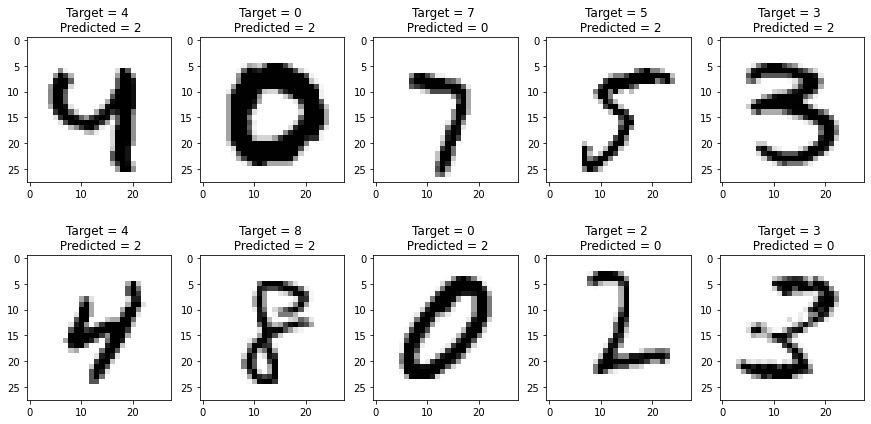

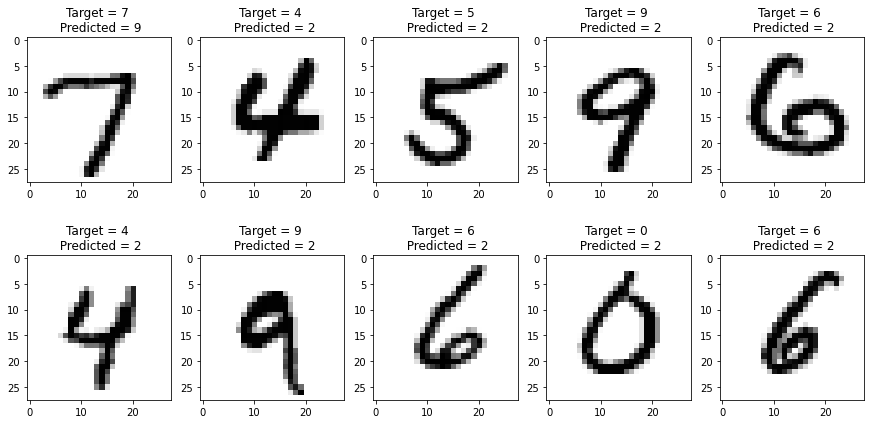

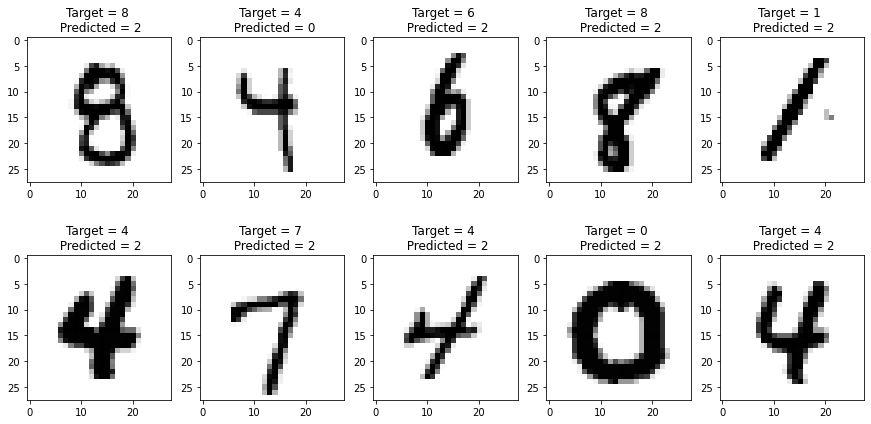

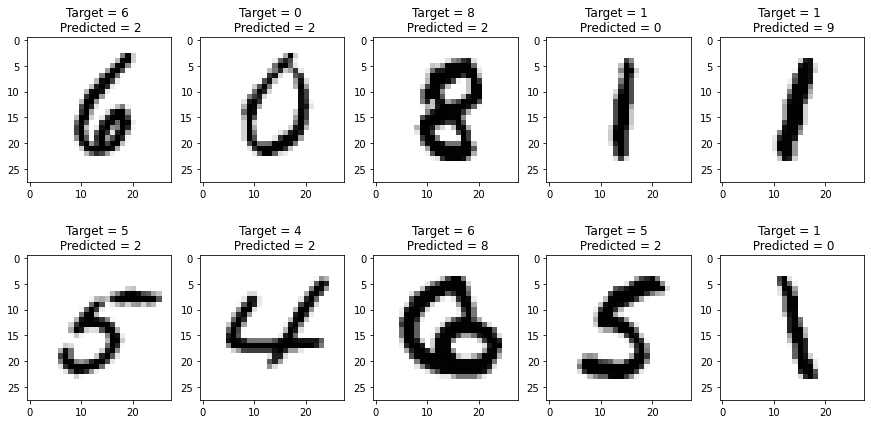

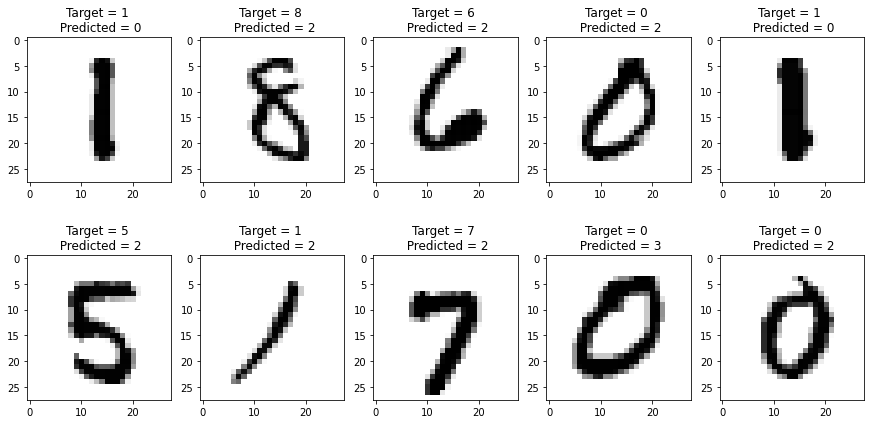

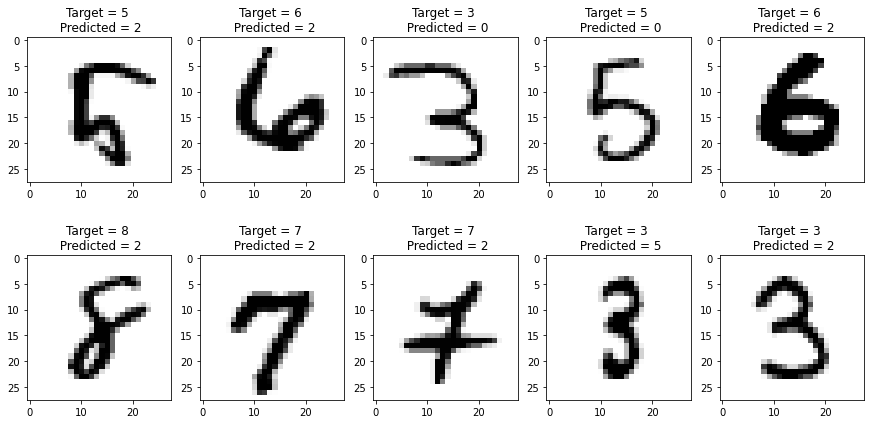

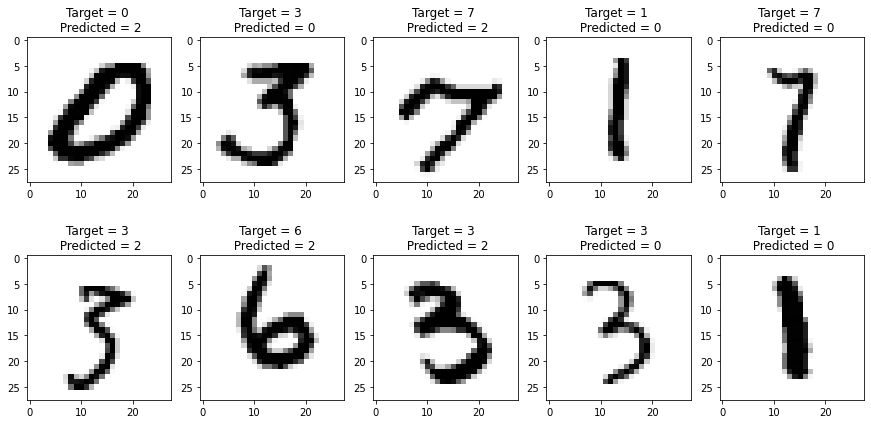

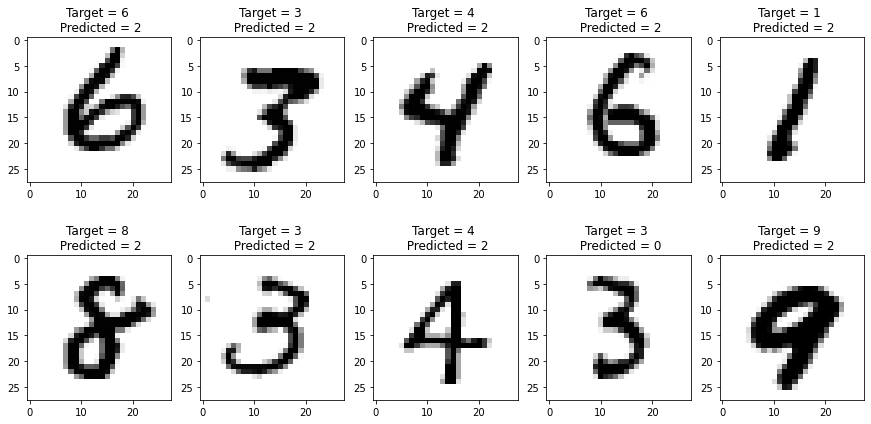

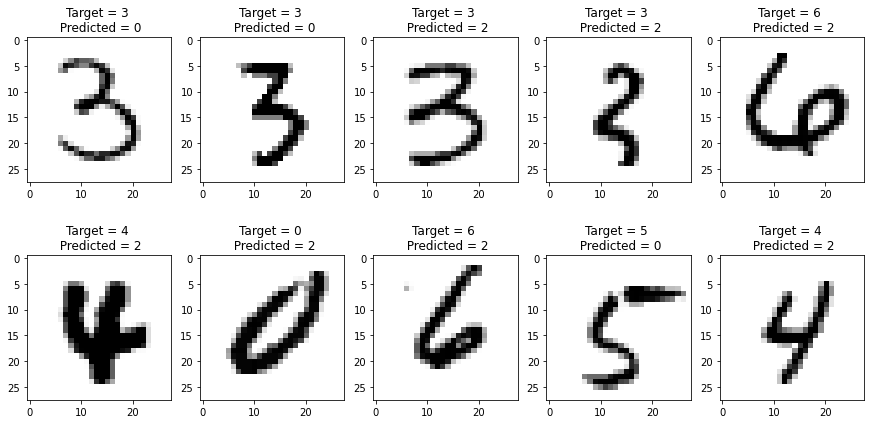

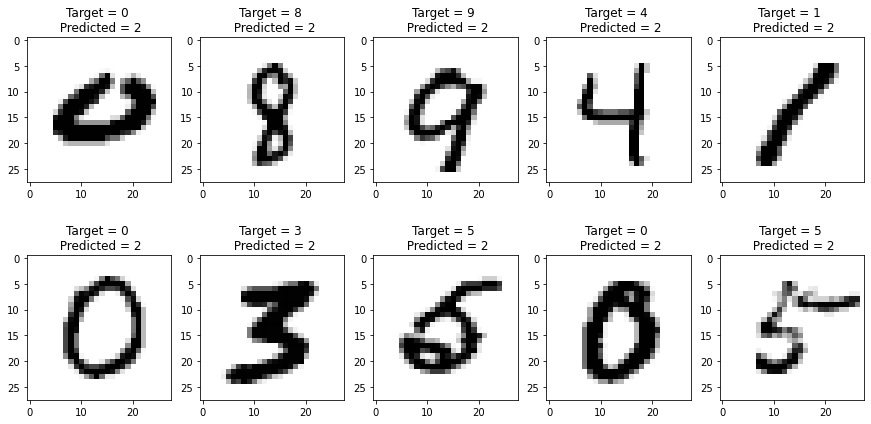

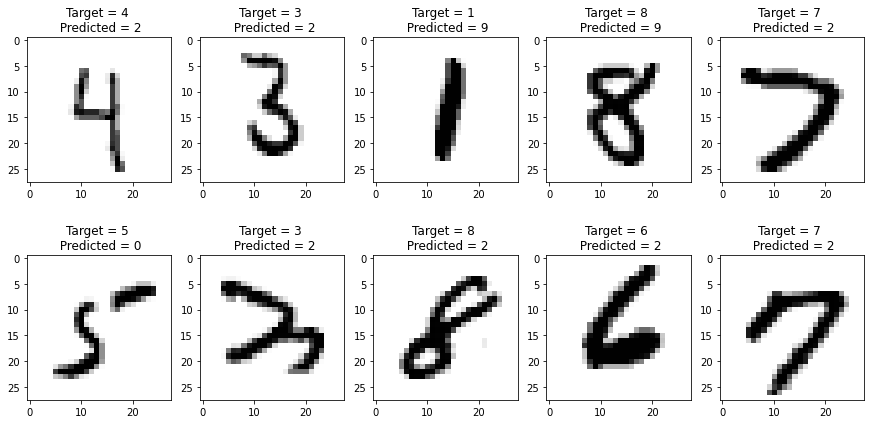

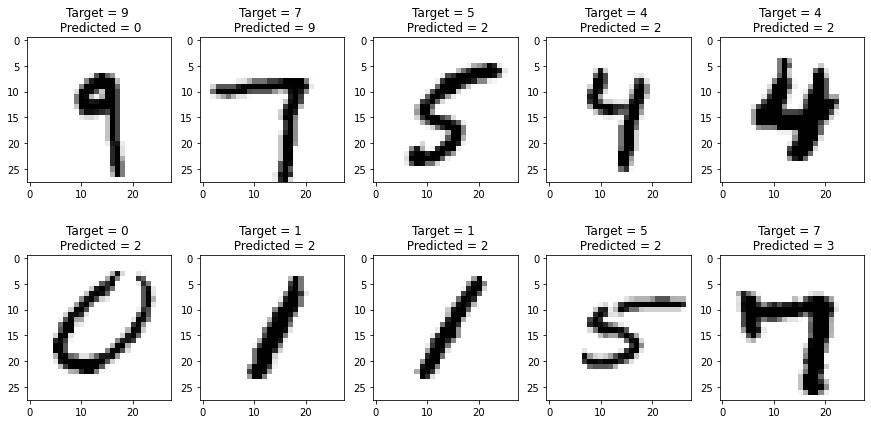

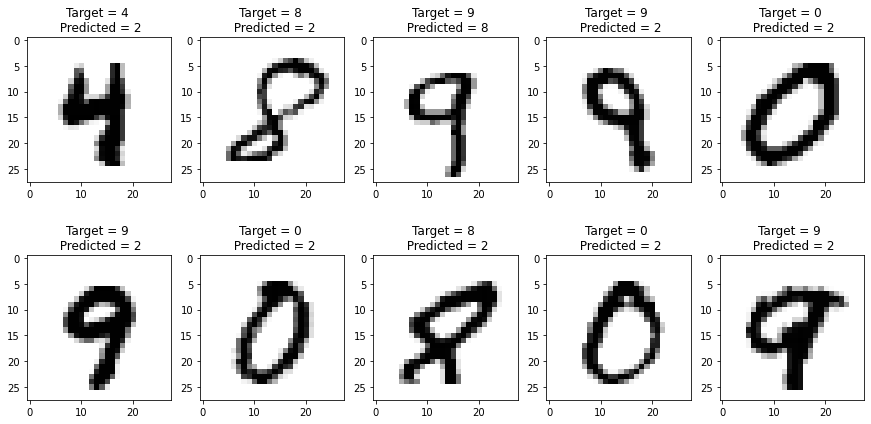

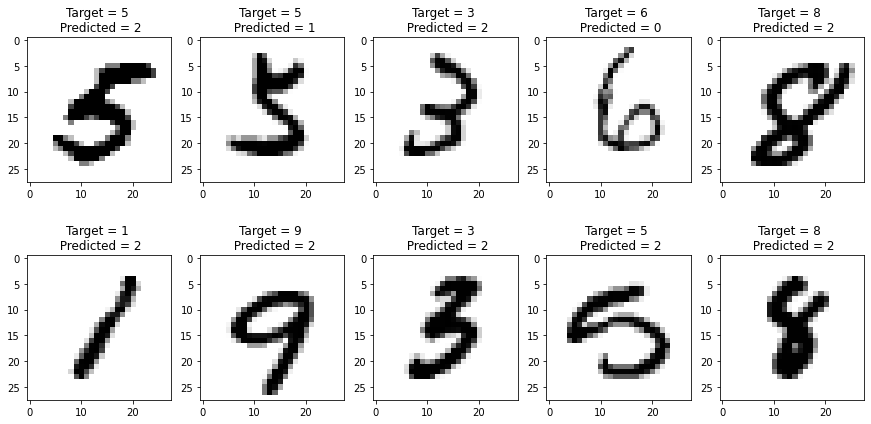

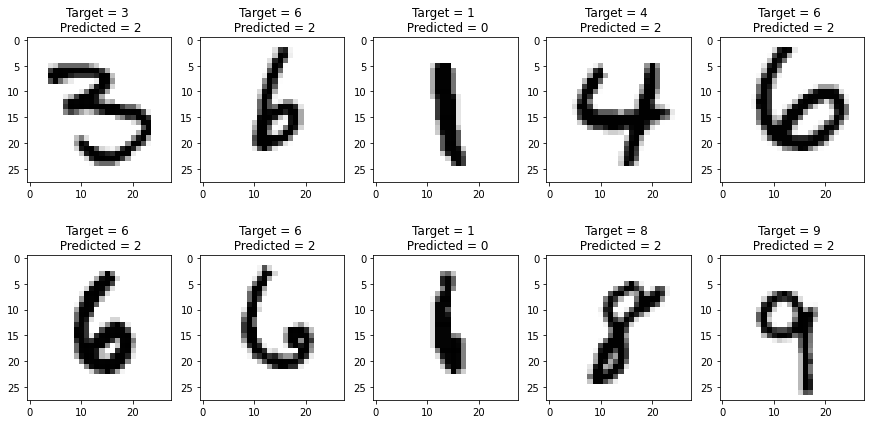

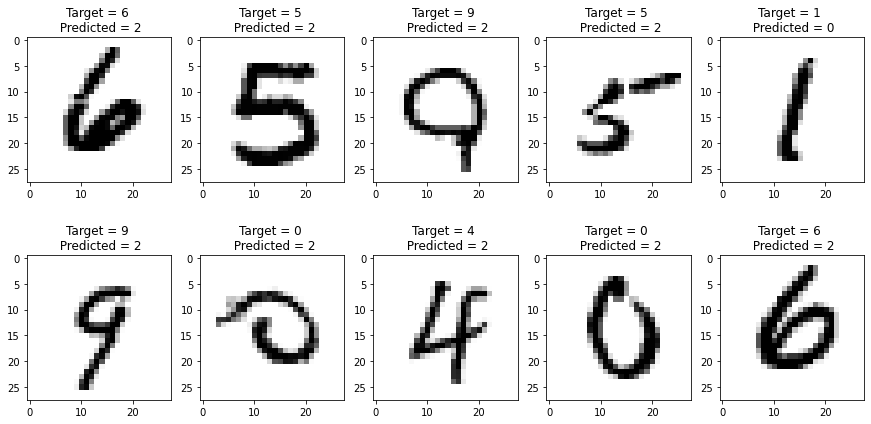

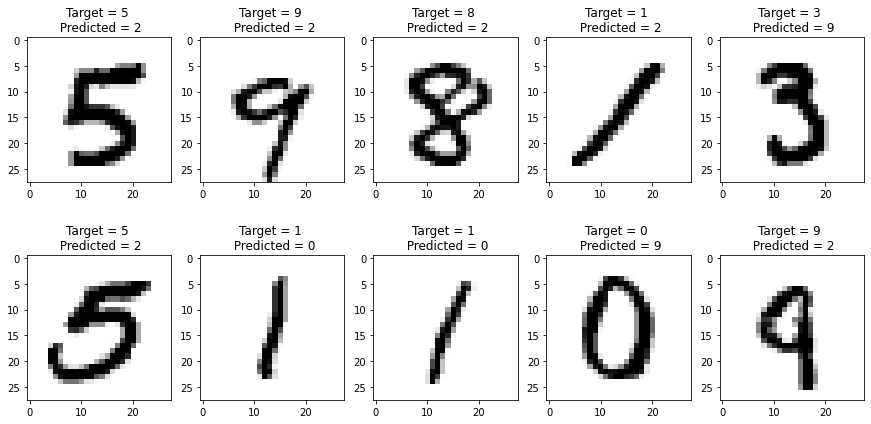

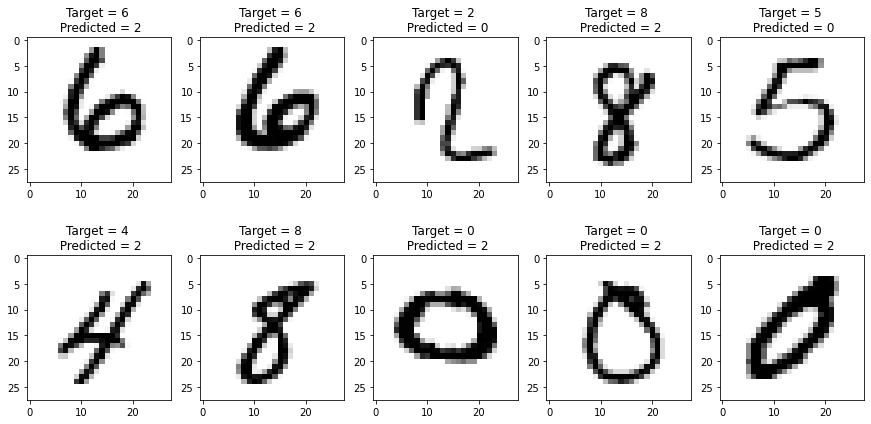

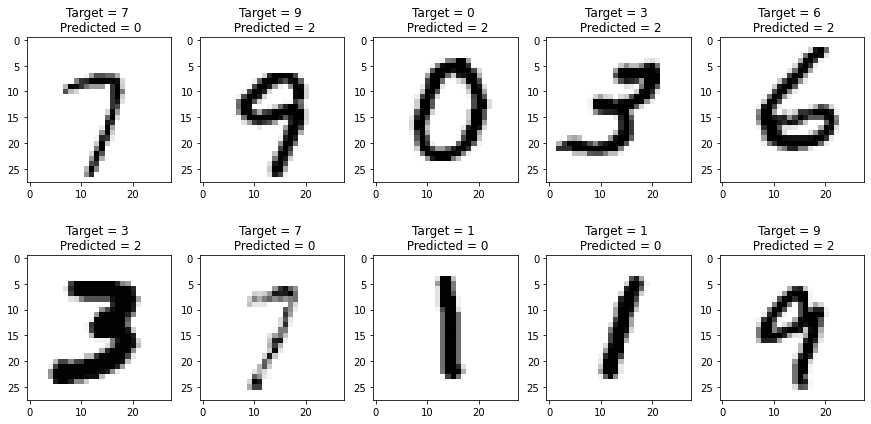

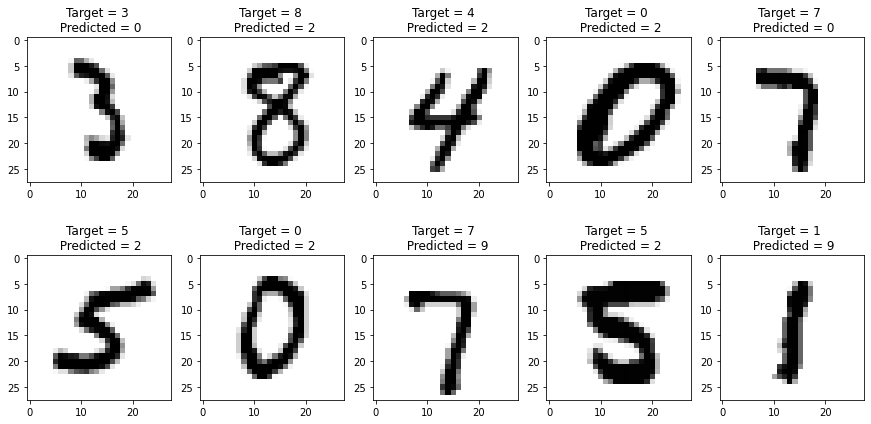

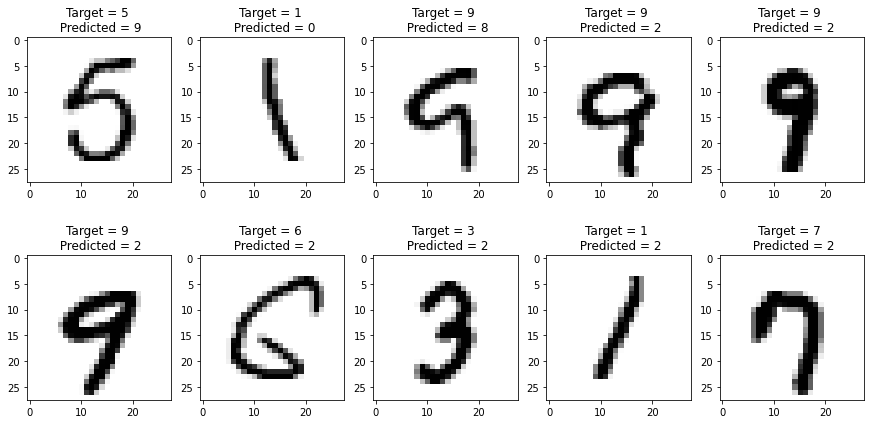

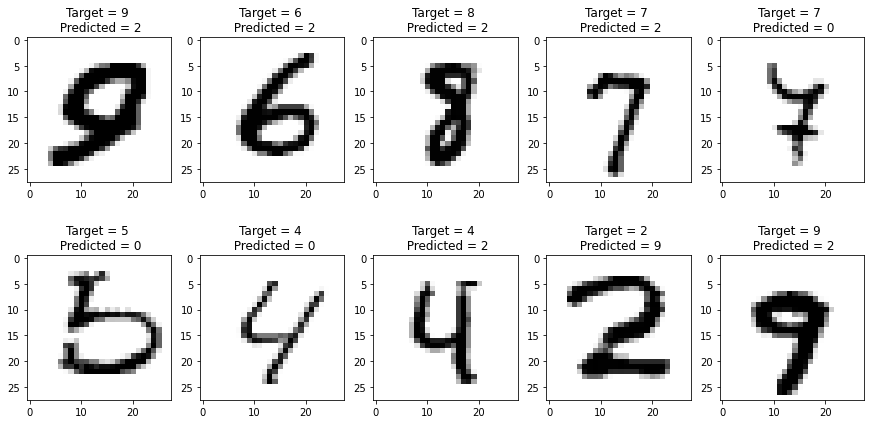

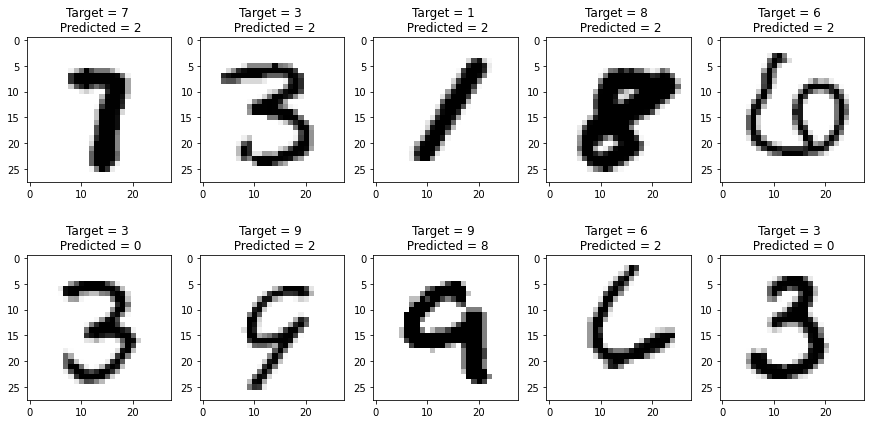

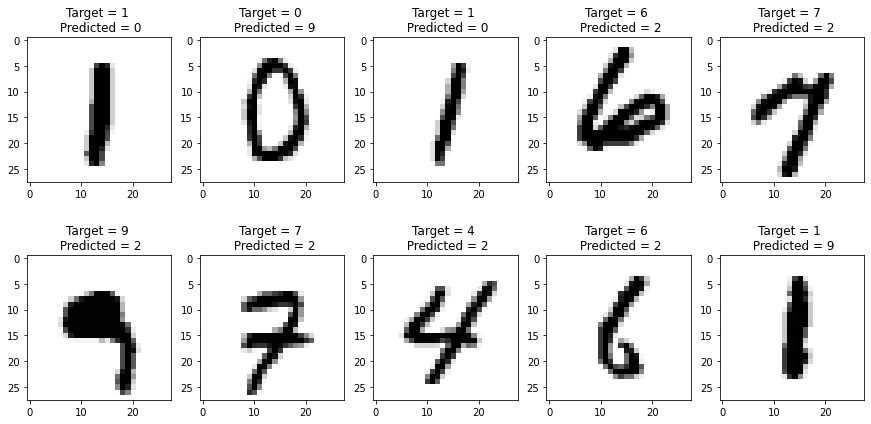

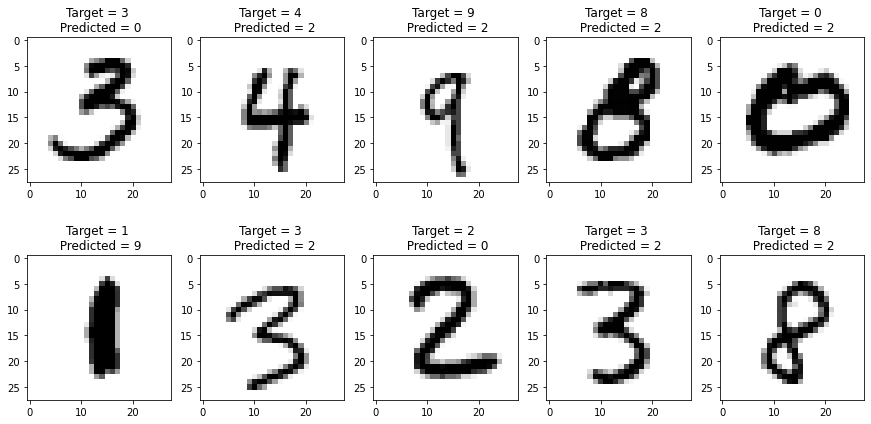

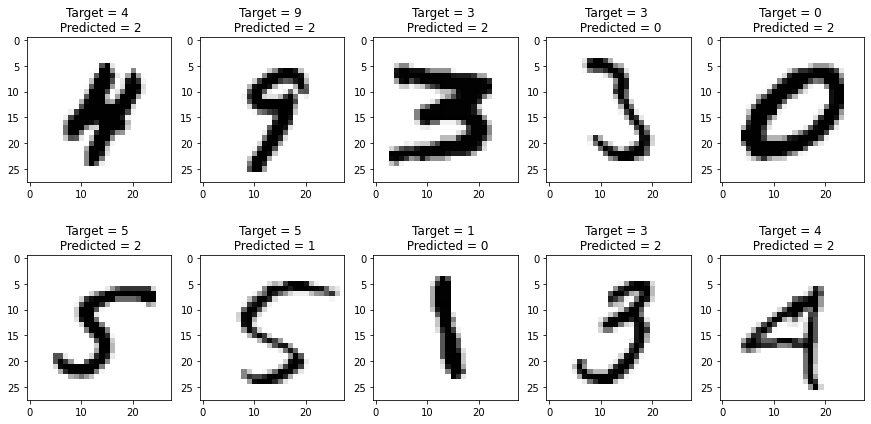

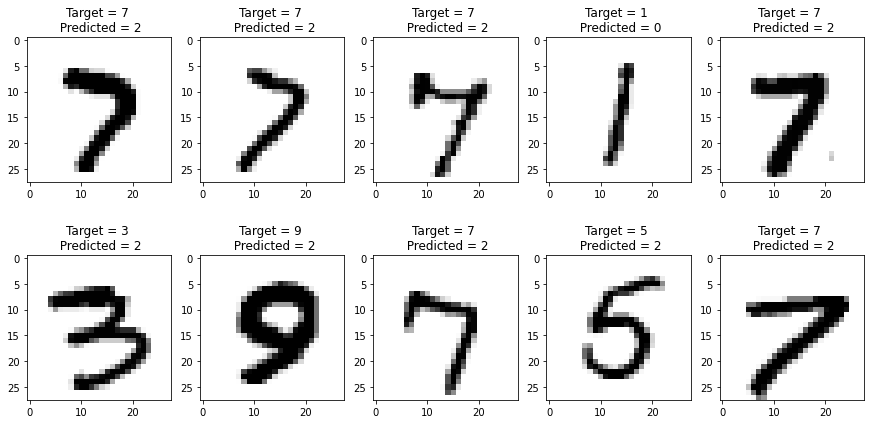

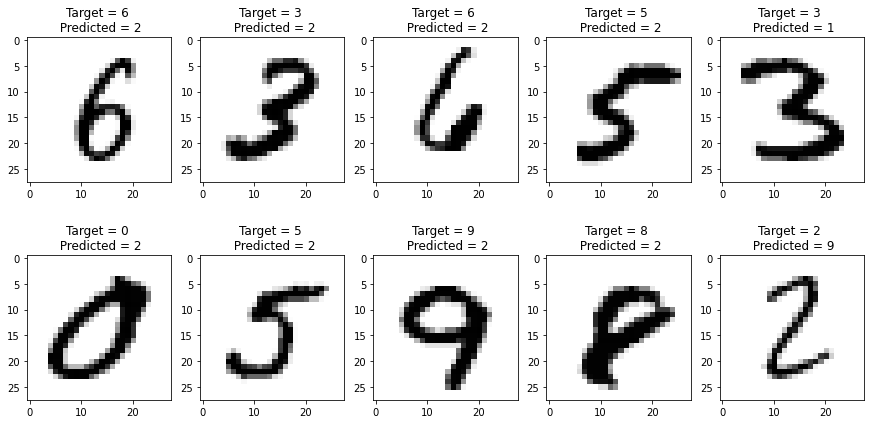

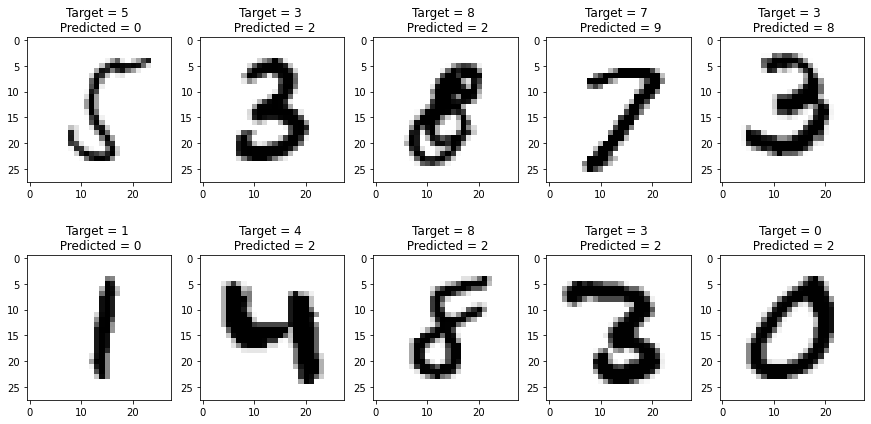

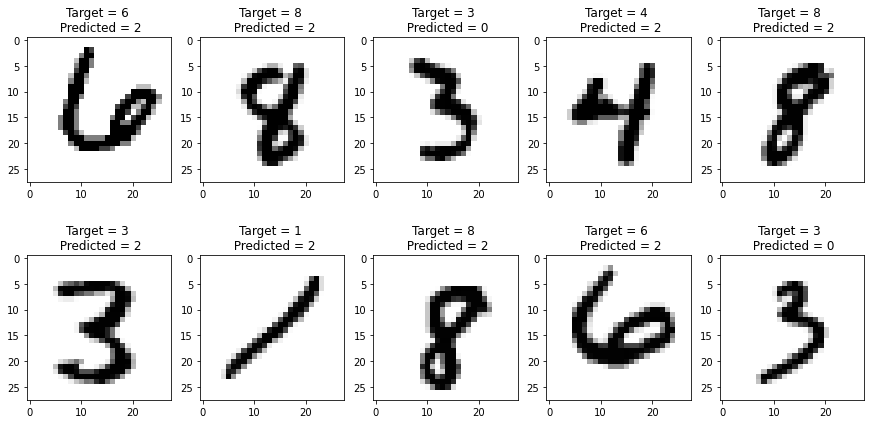

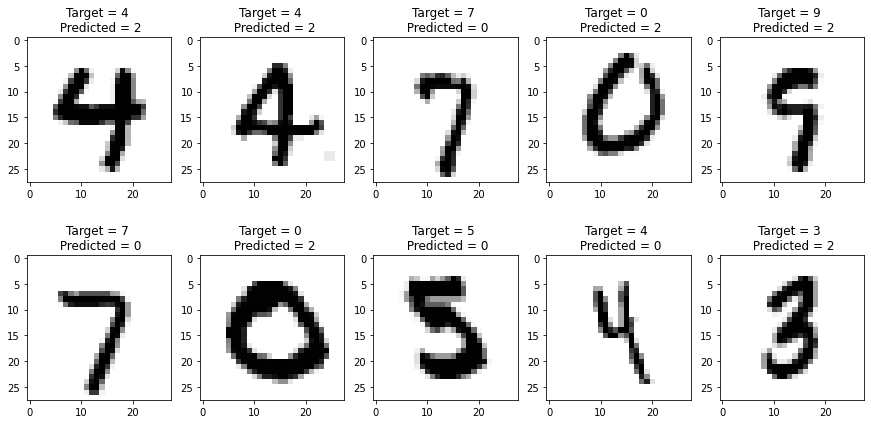

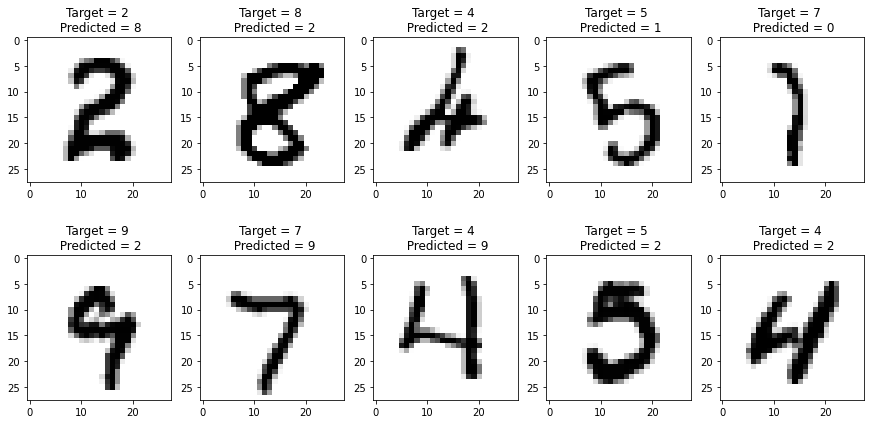

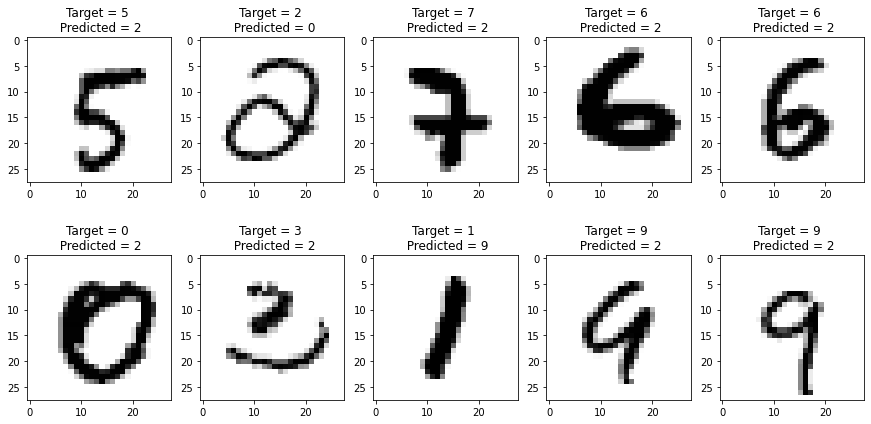

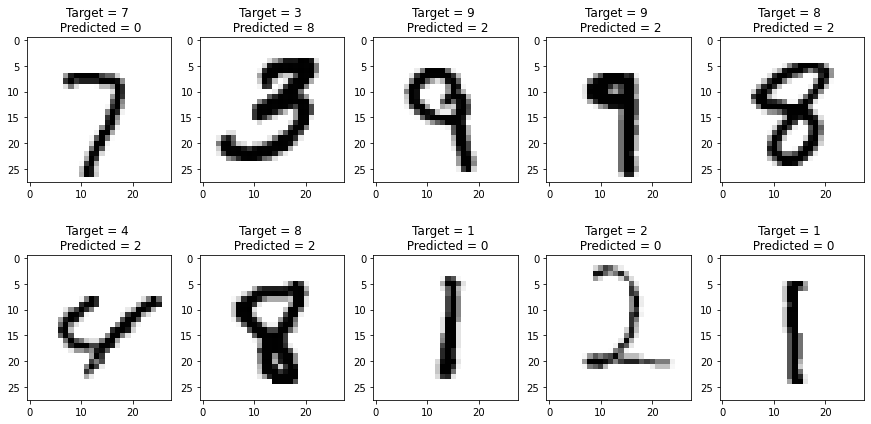

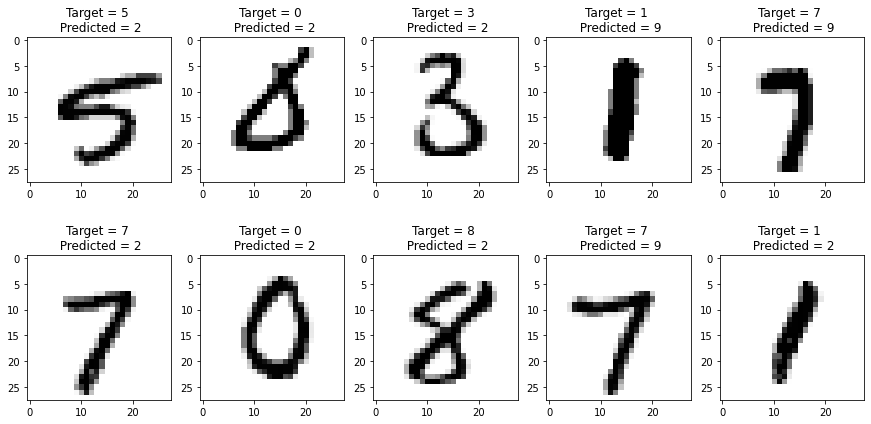

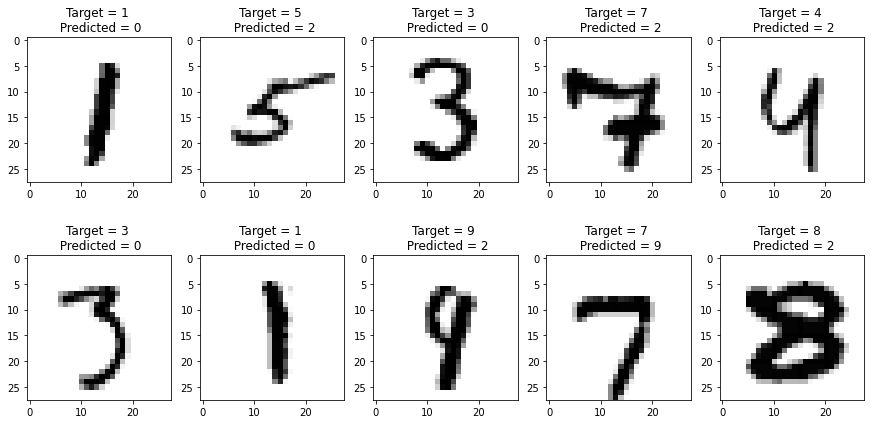

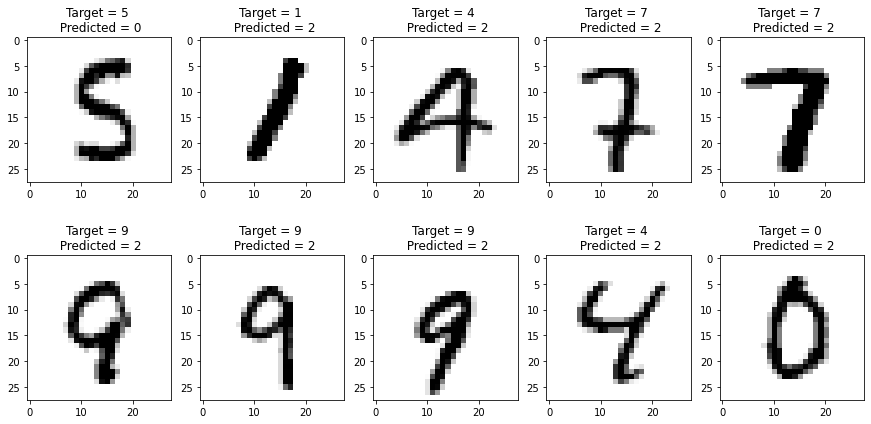

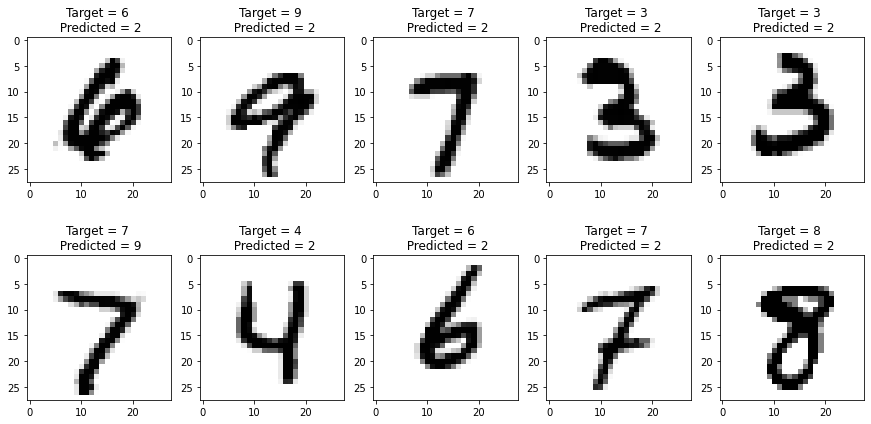

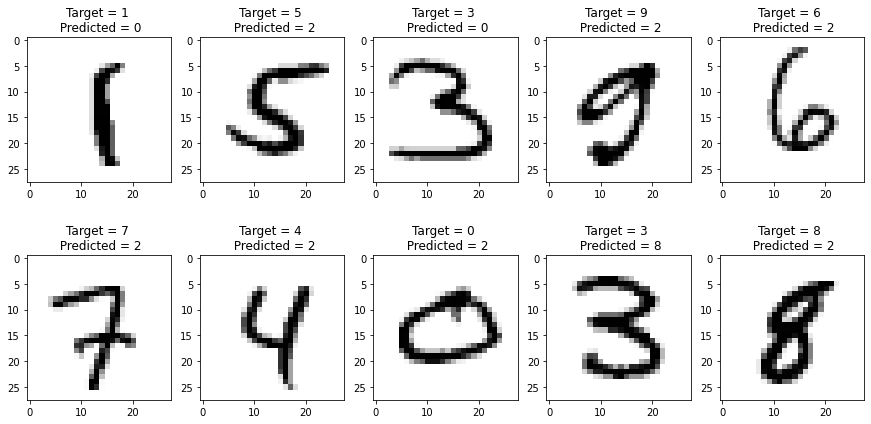

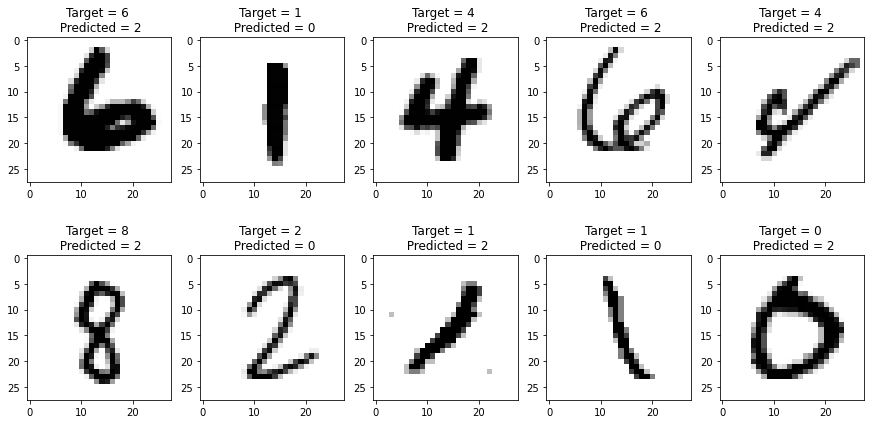

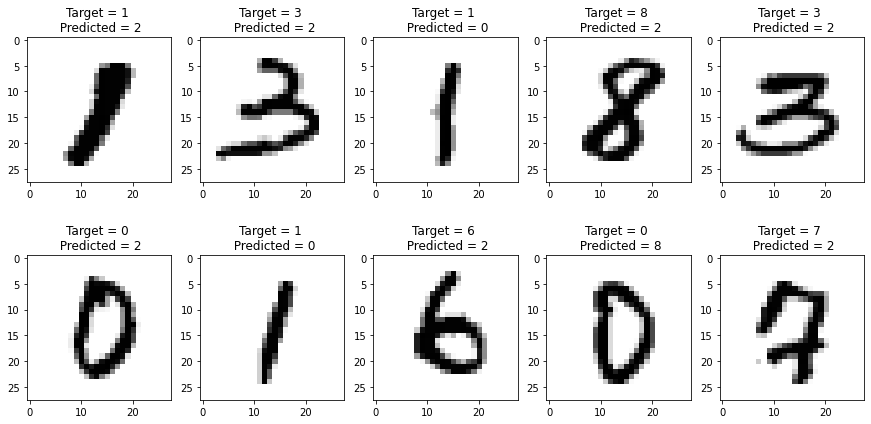

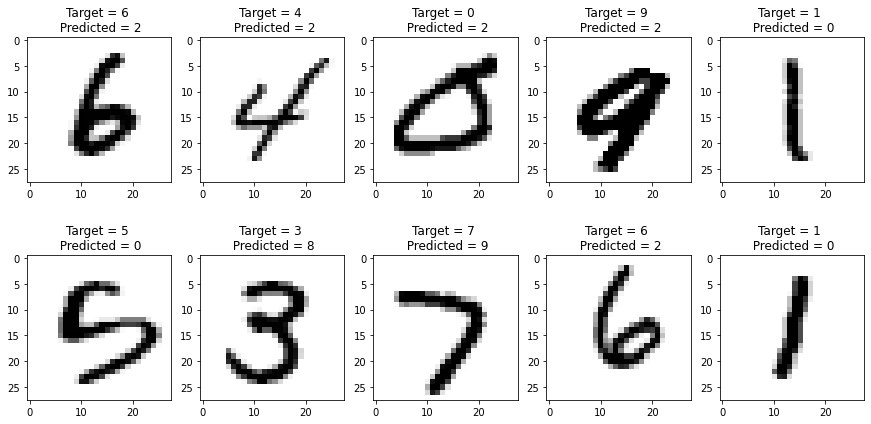

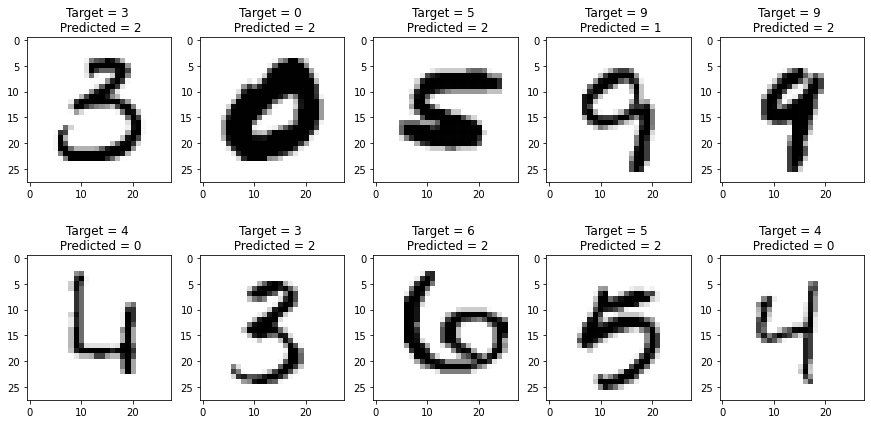

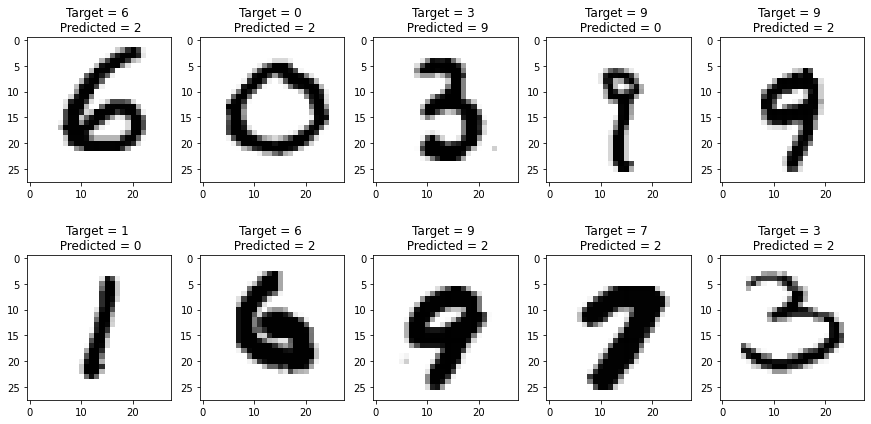

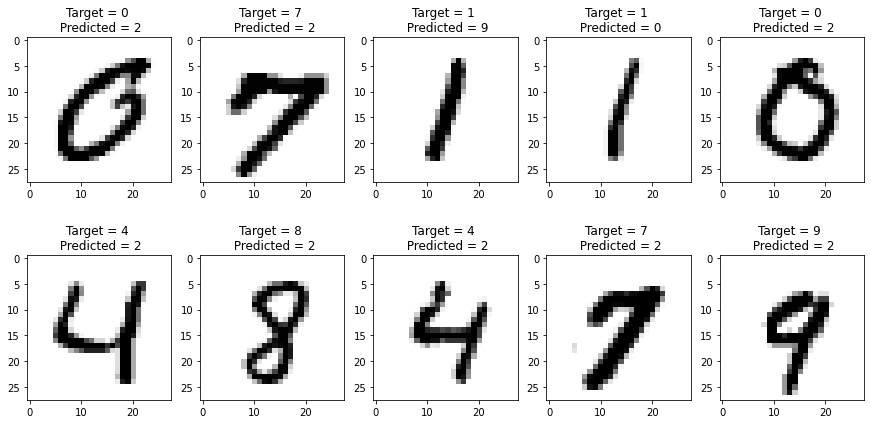

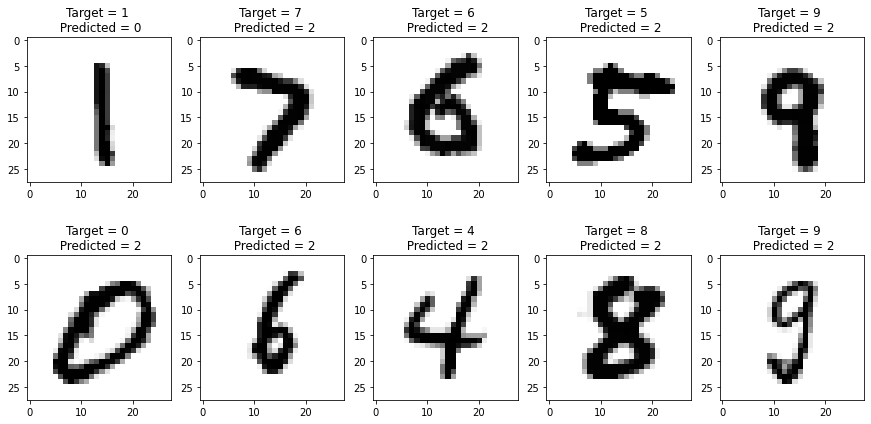

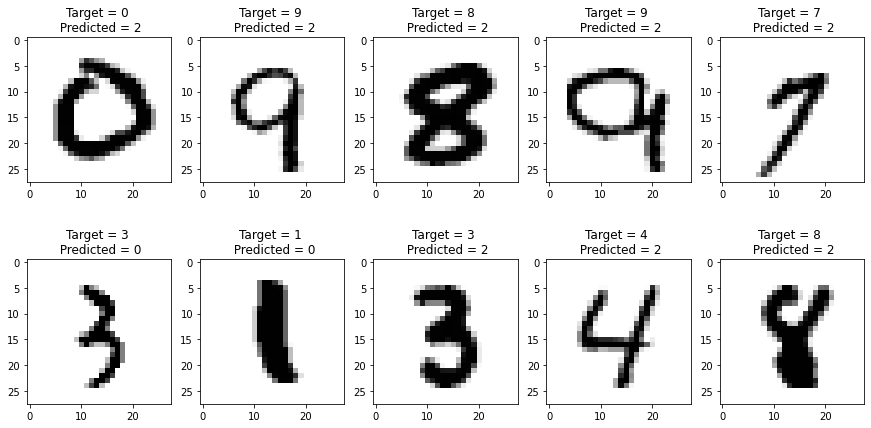

---------------------------------------------------------------

Misclassified files => Model with NormalizationType => NormType.GROUP_NORM

---------------------------------------------------------------



********* Misclassified Images **************





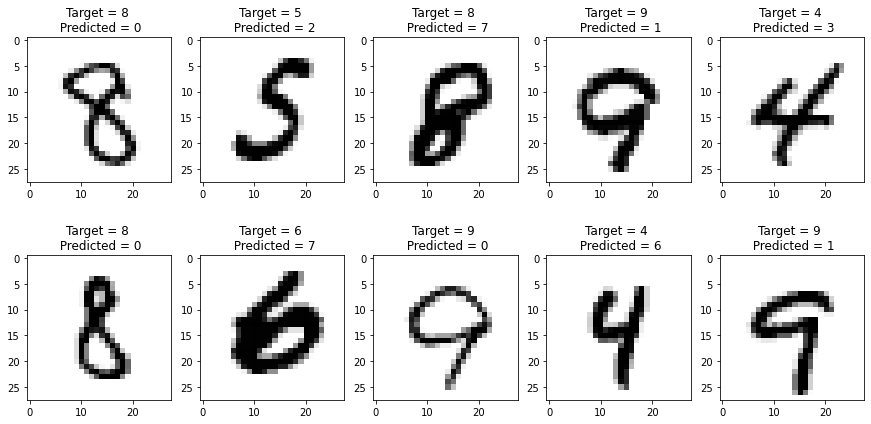

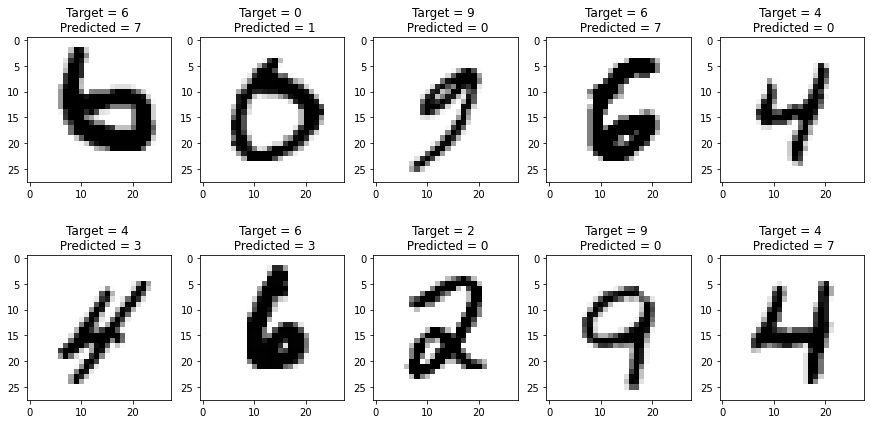

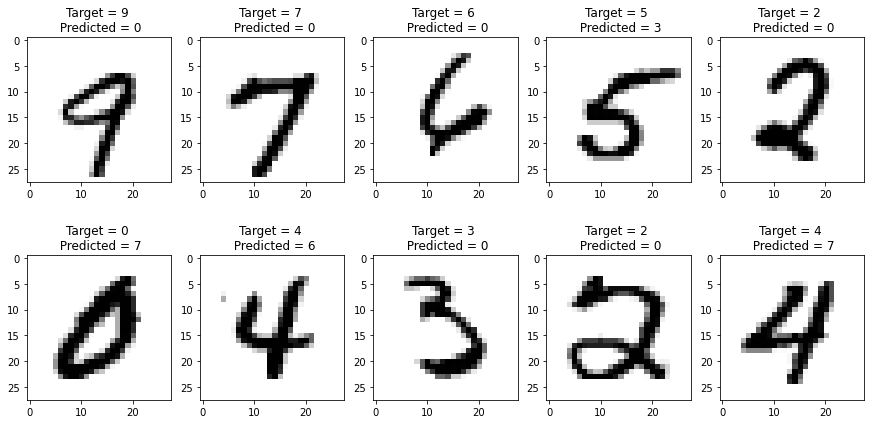

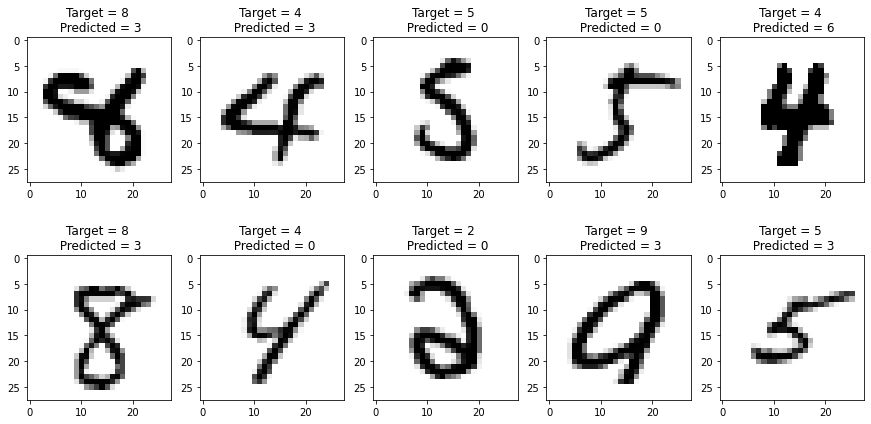

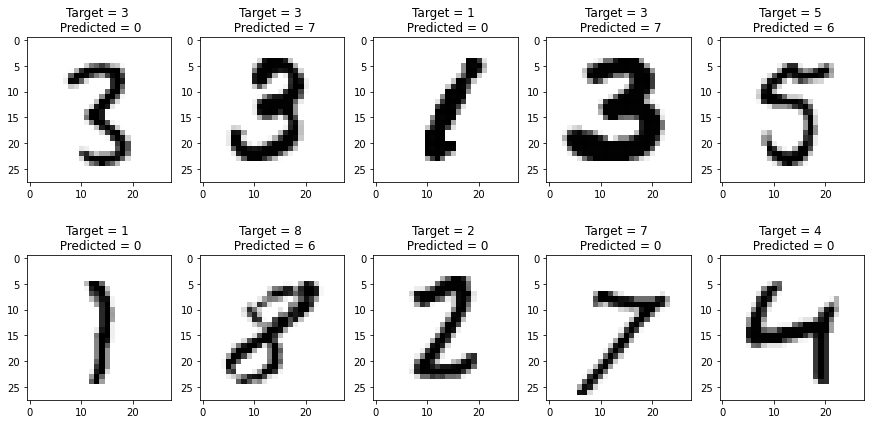

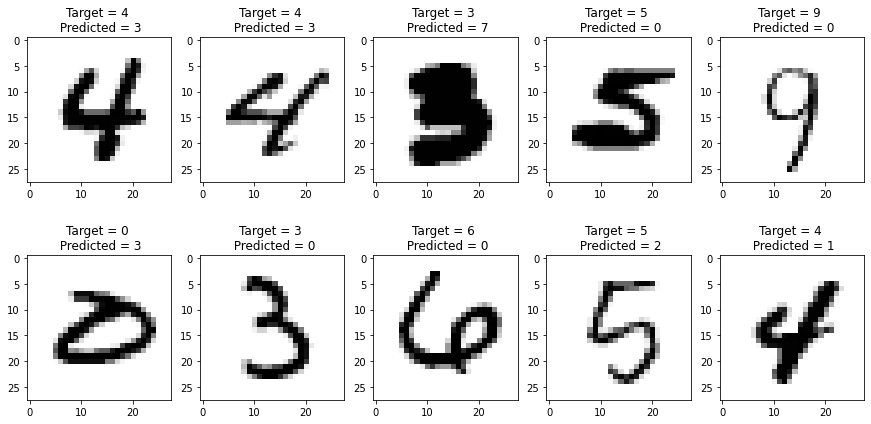

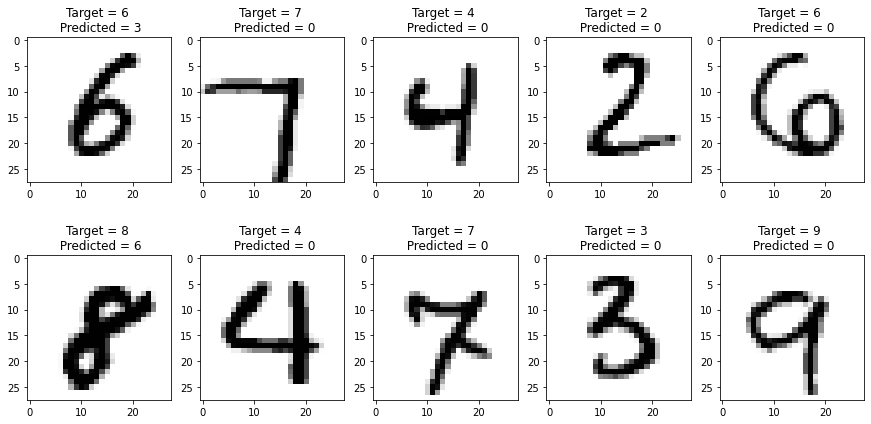

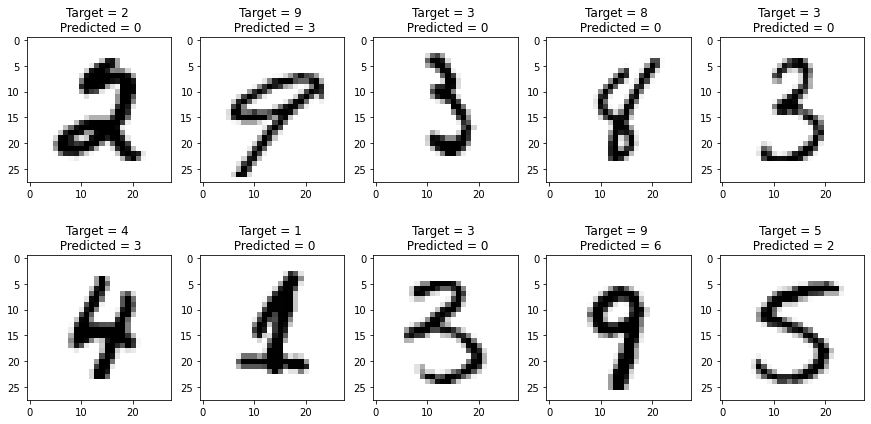

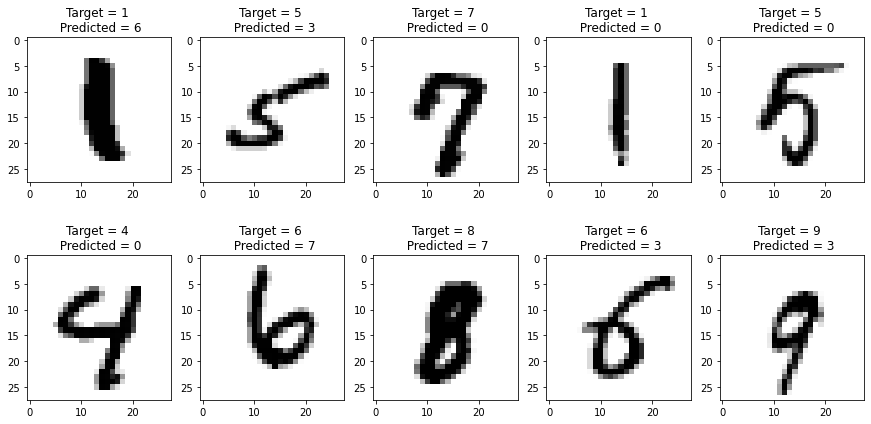

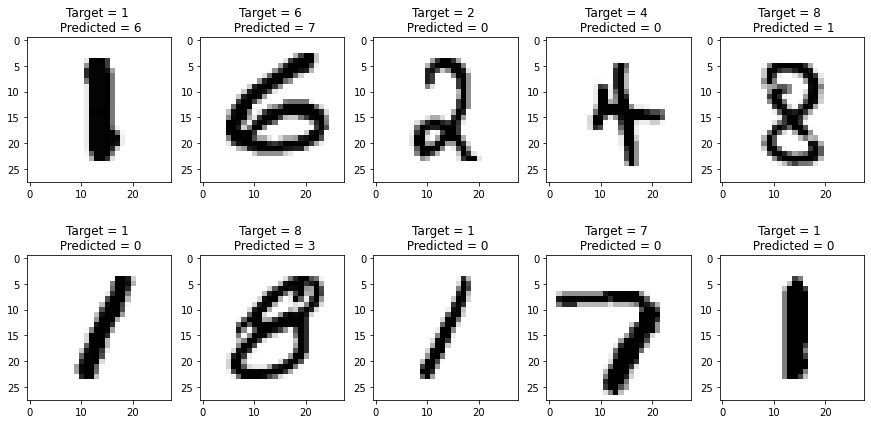

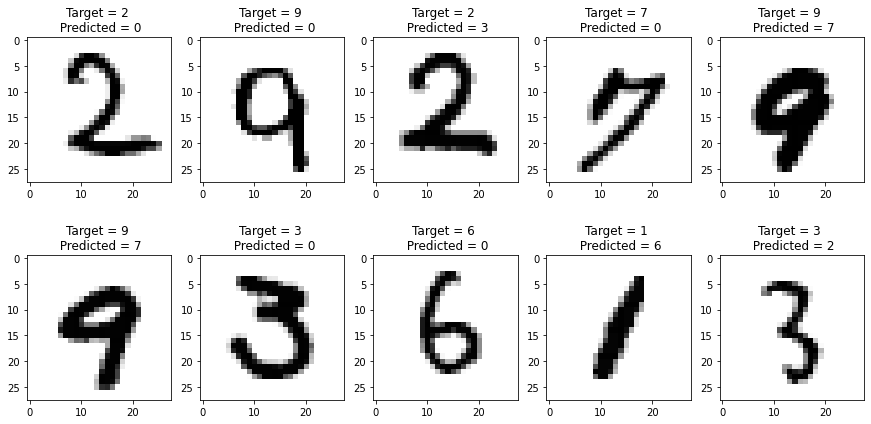

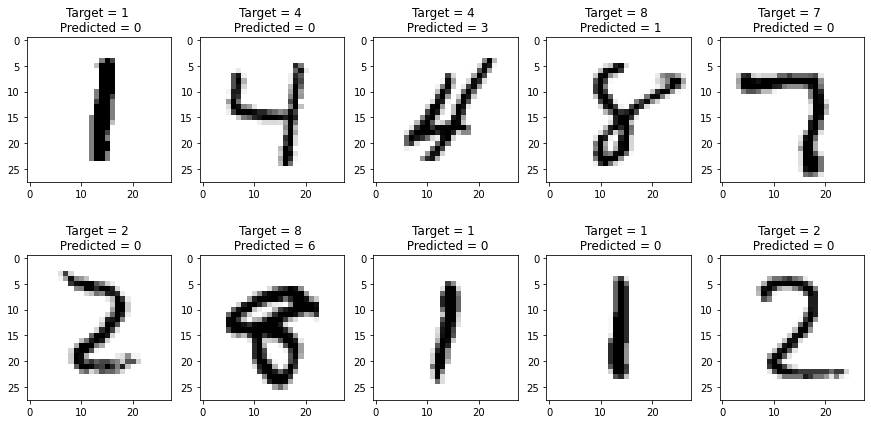

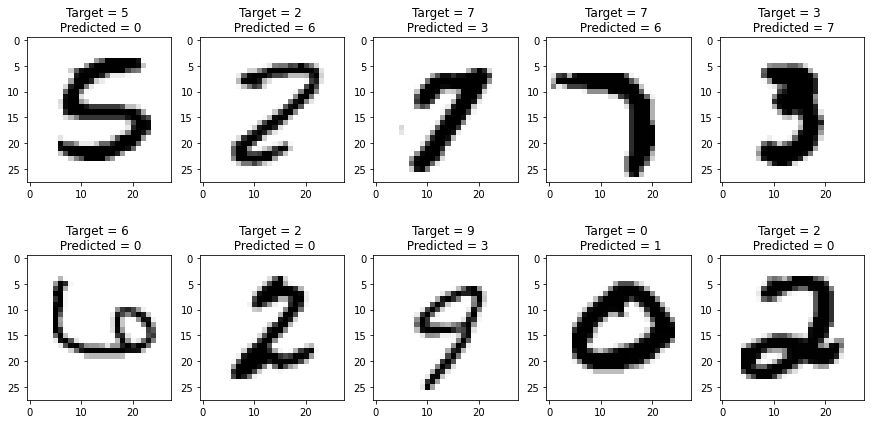

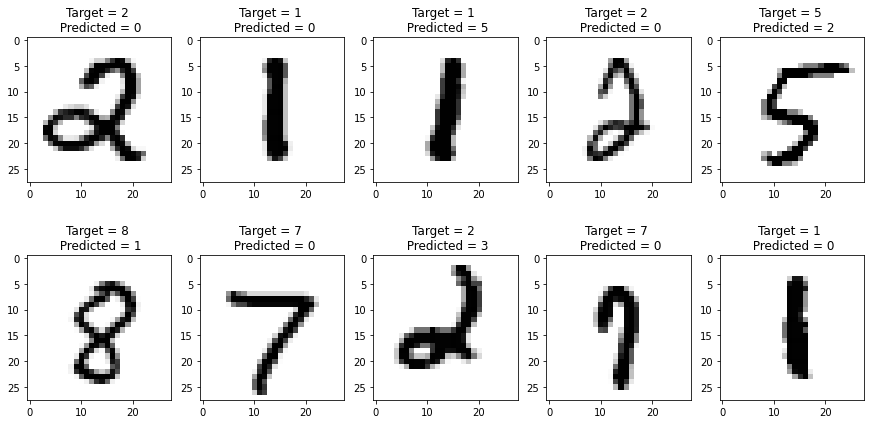

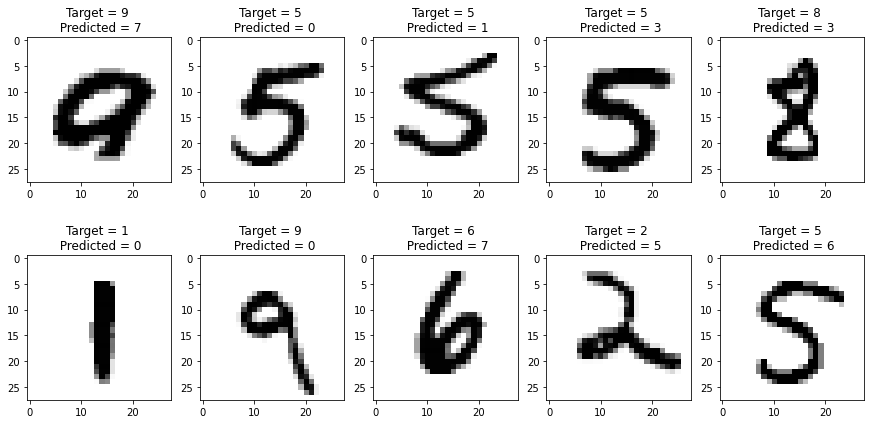

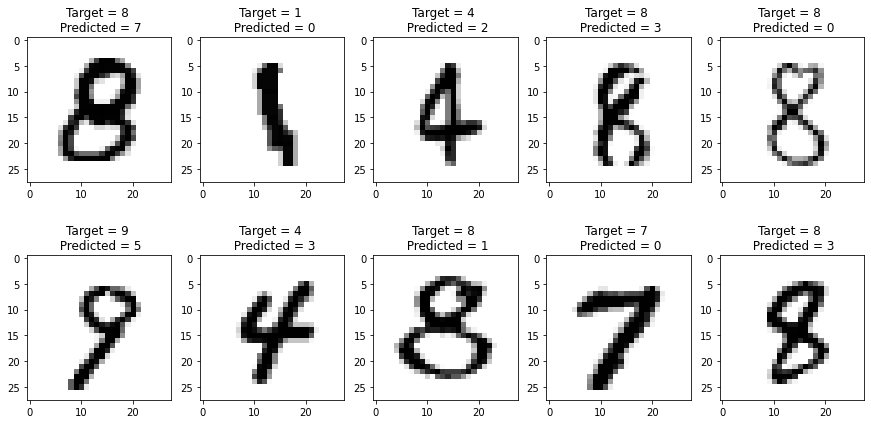

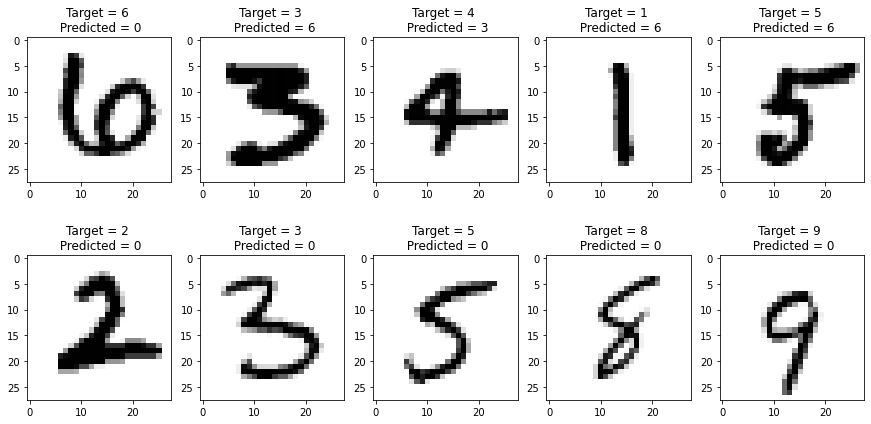

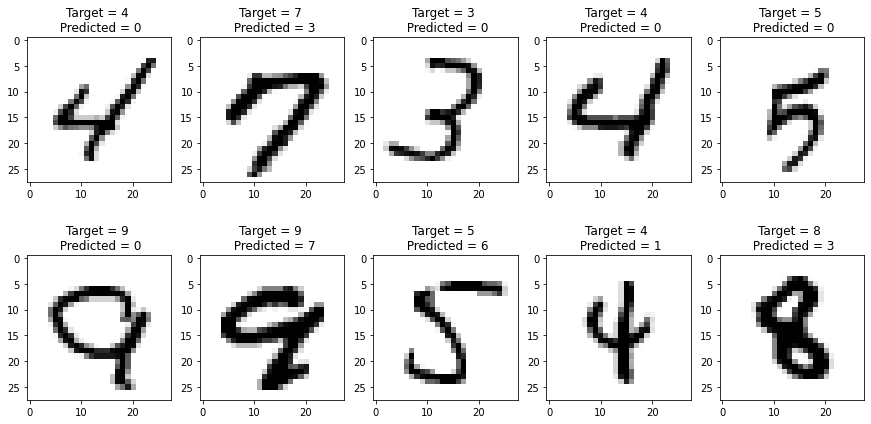

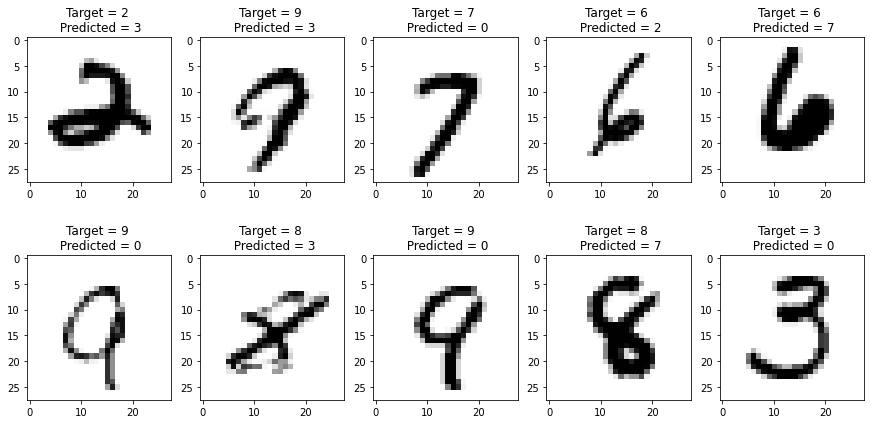

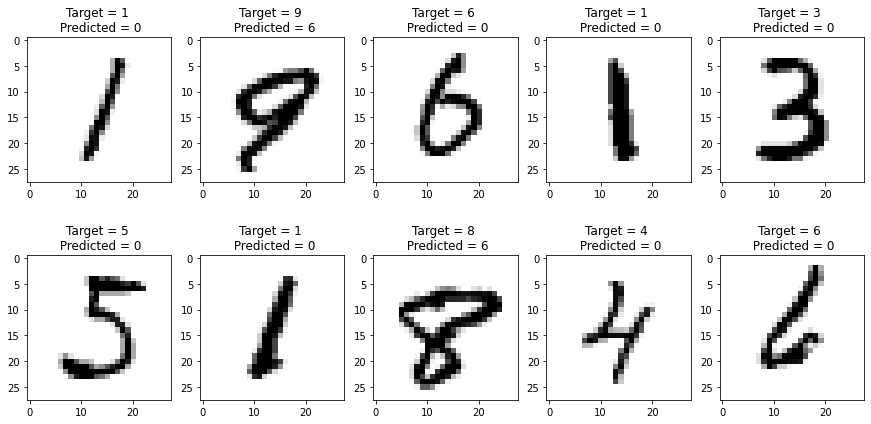

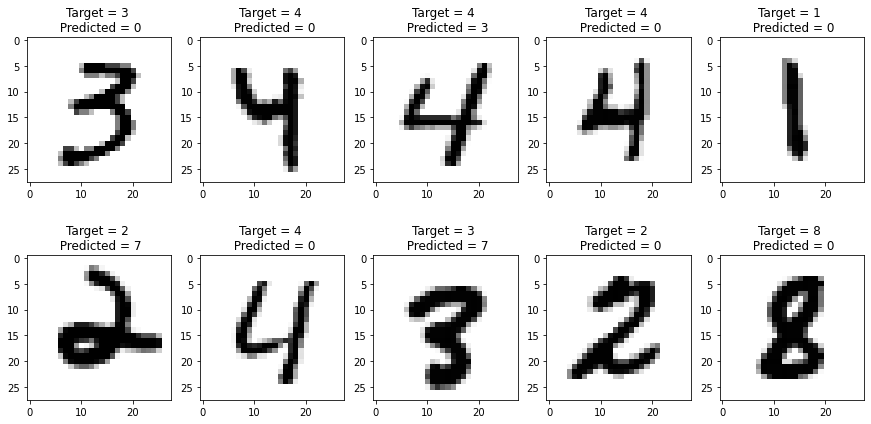

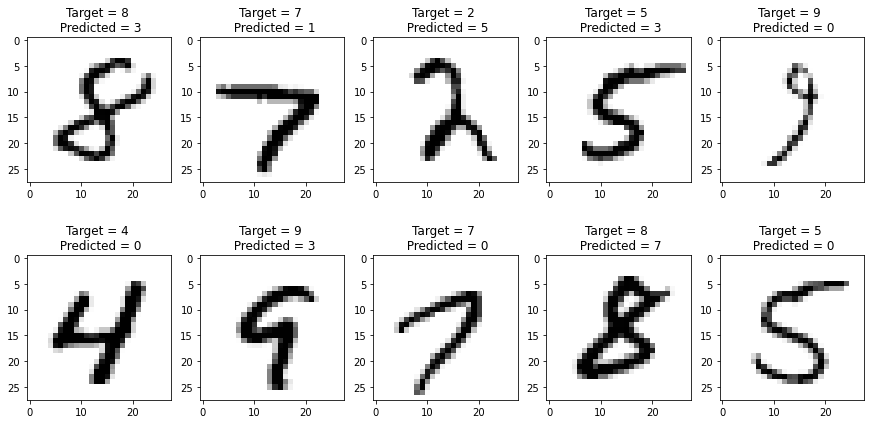

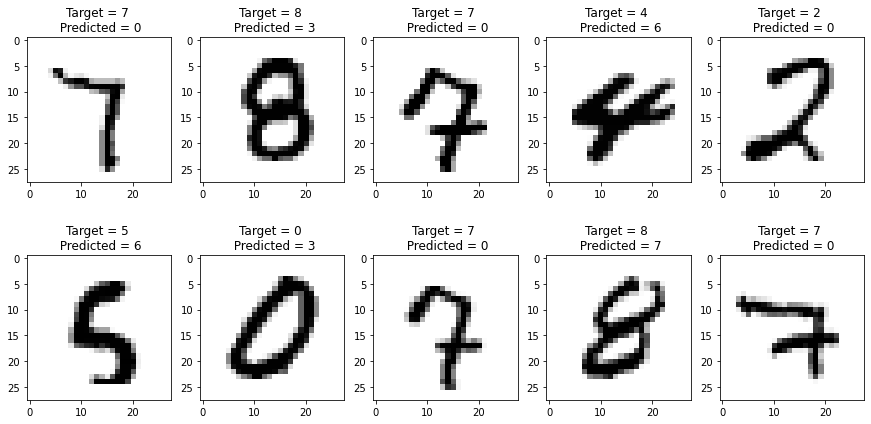

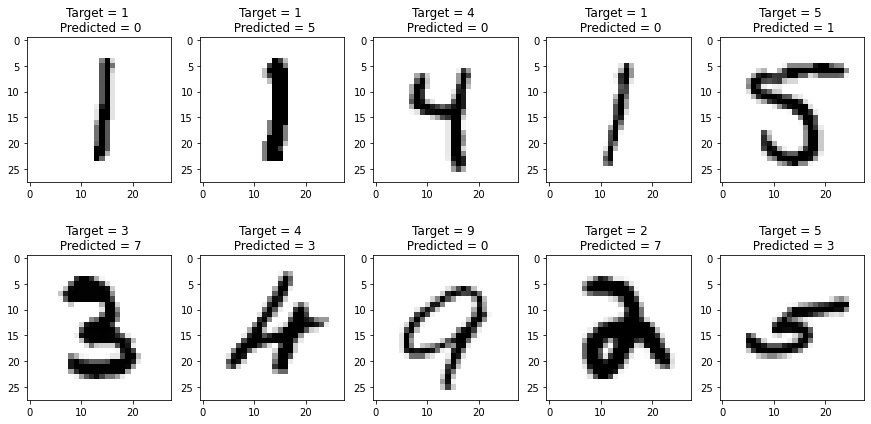

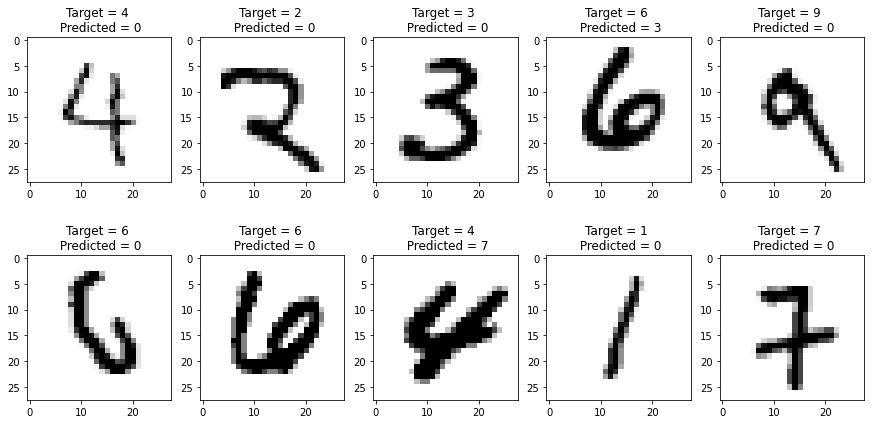

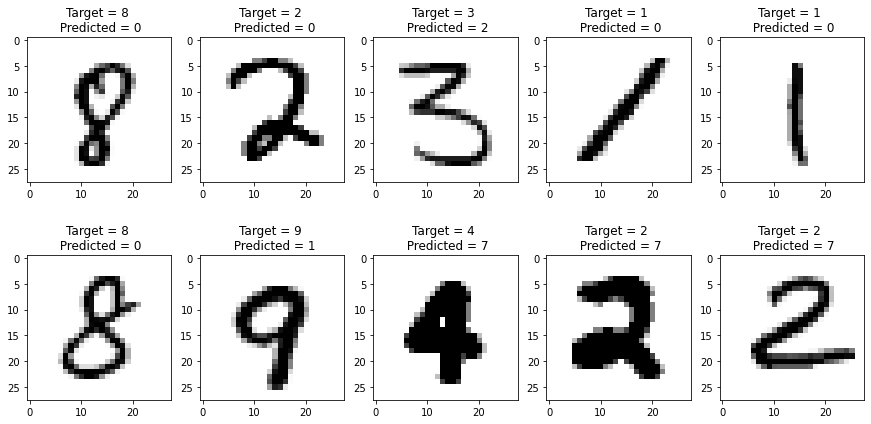

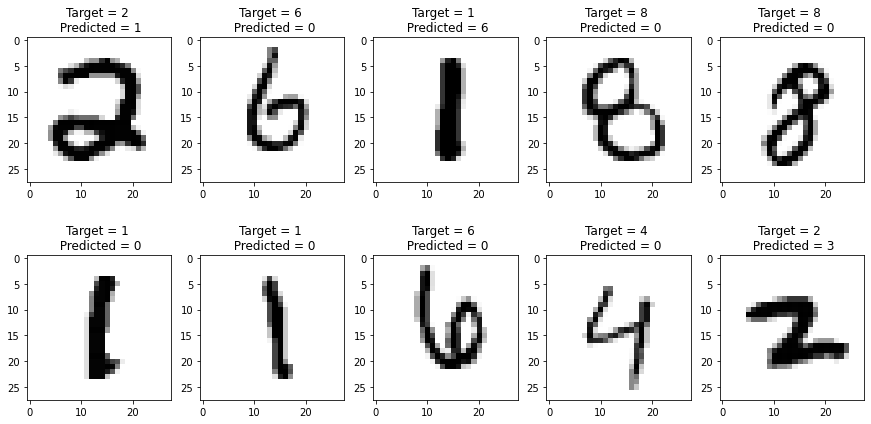

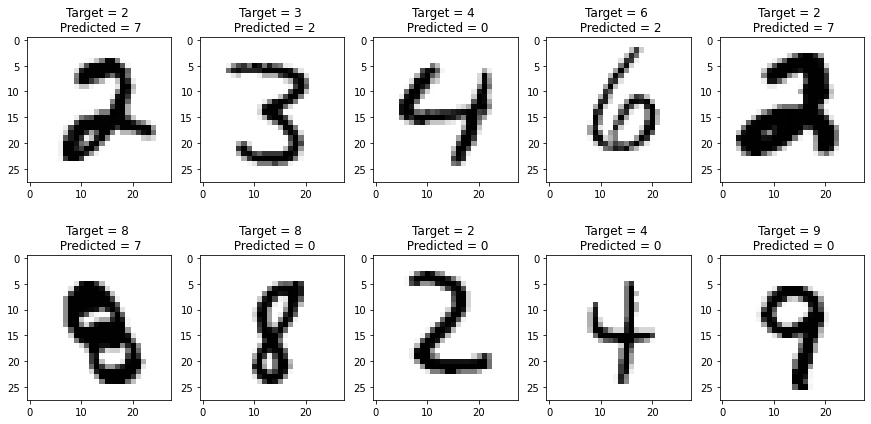

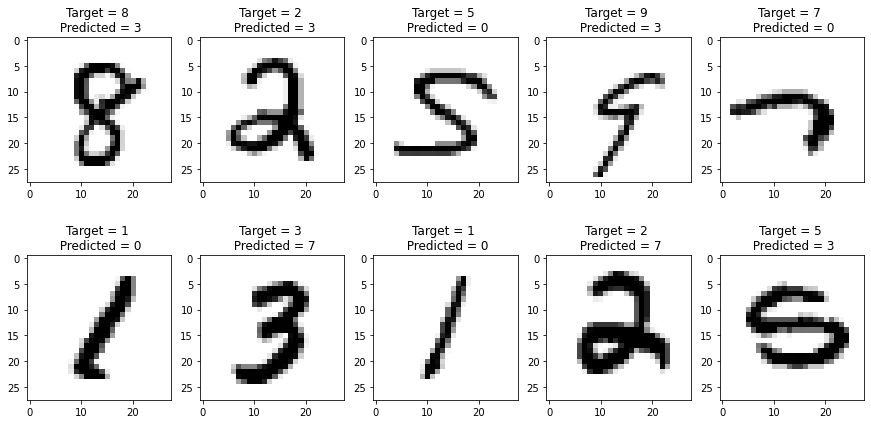

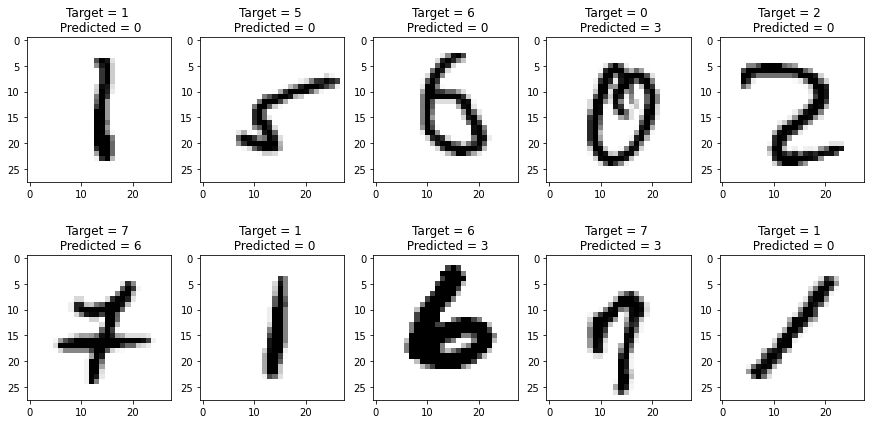

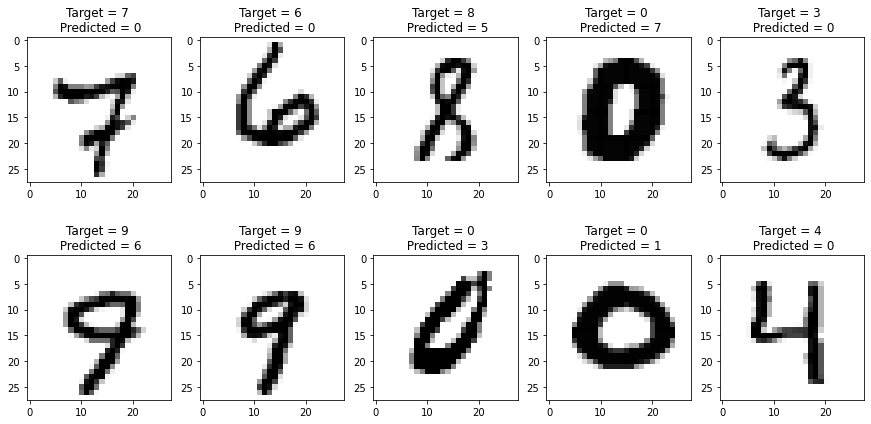

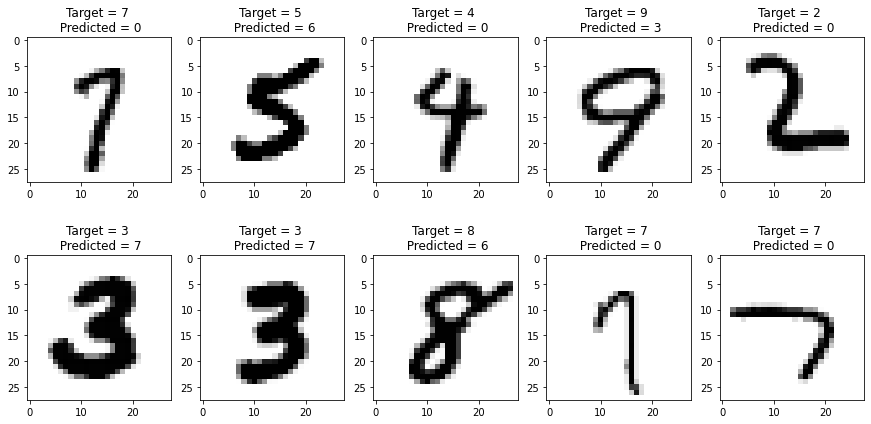

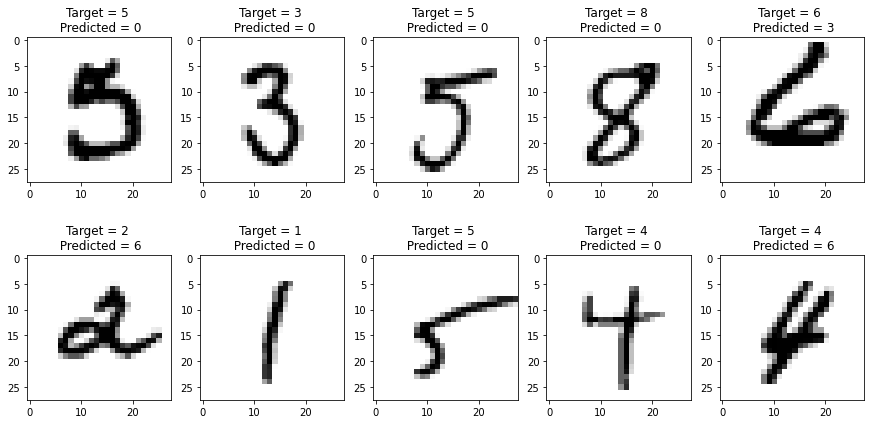

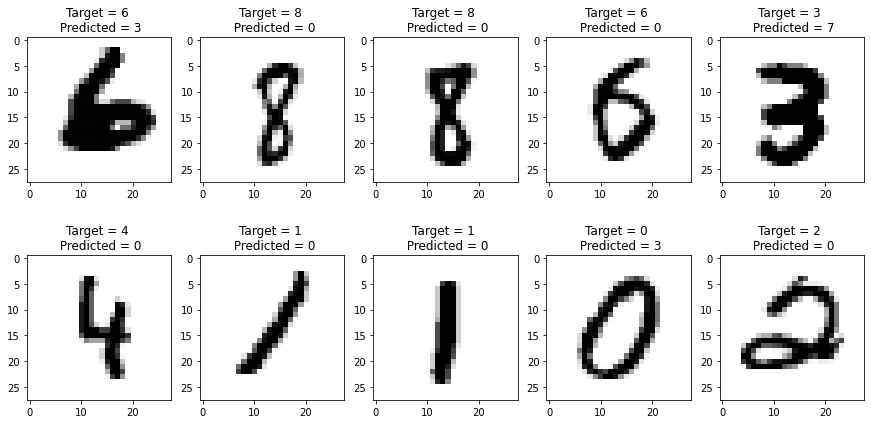

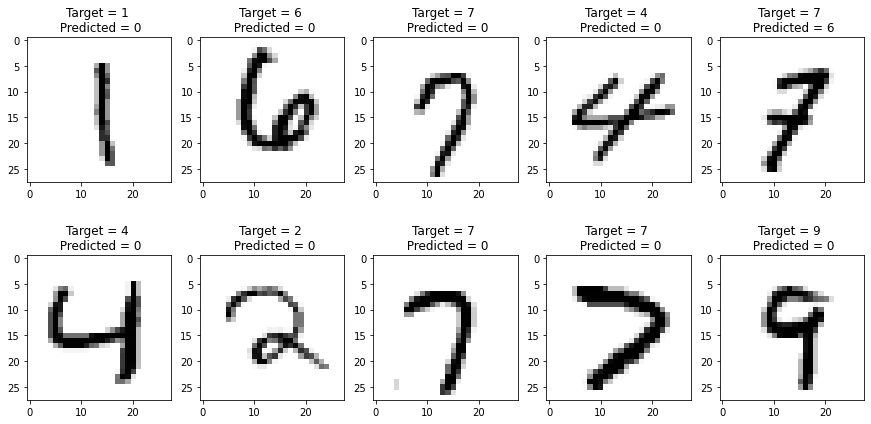

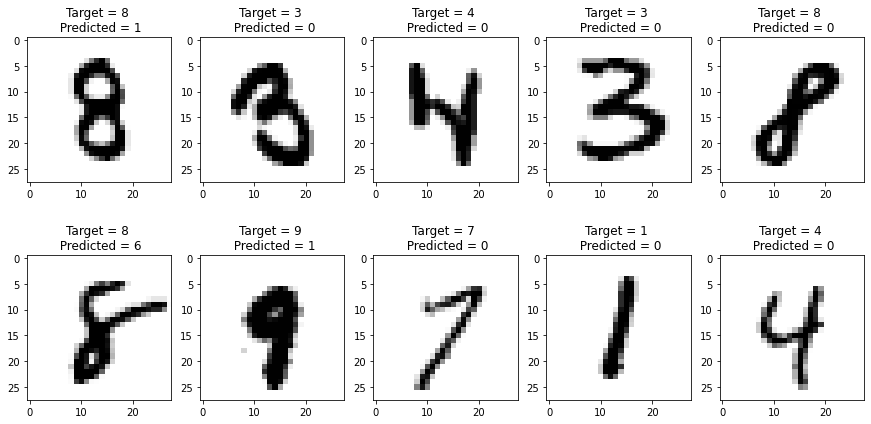

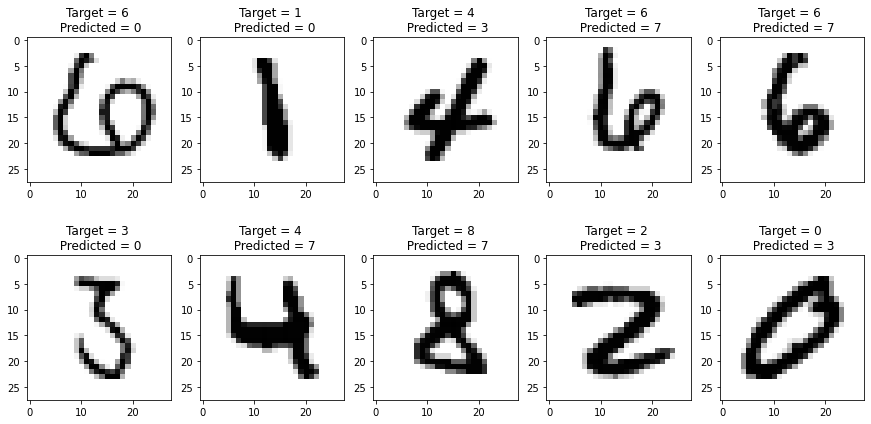

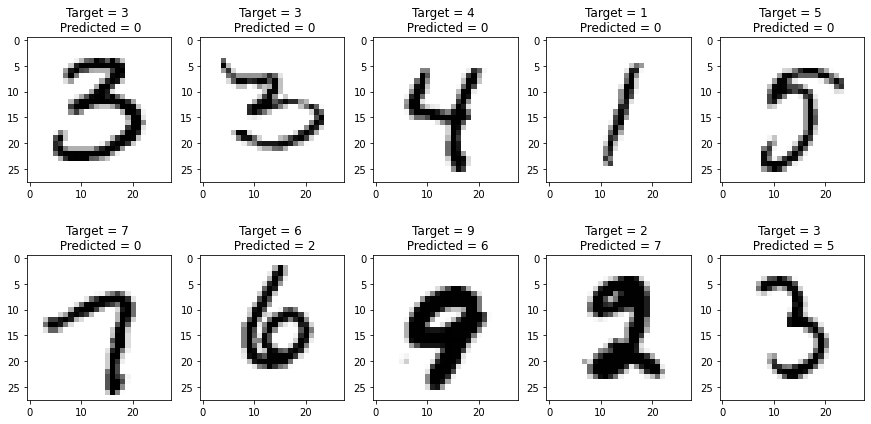

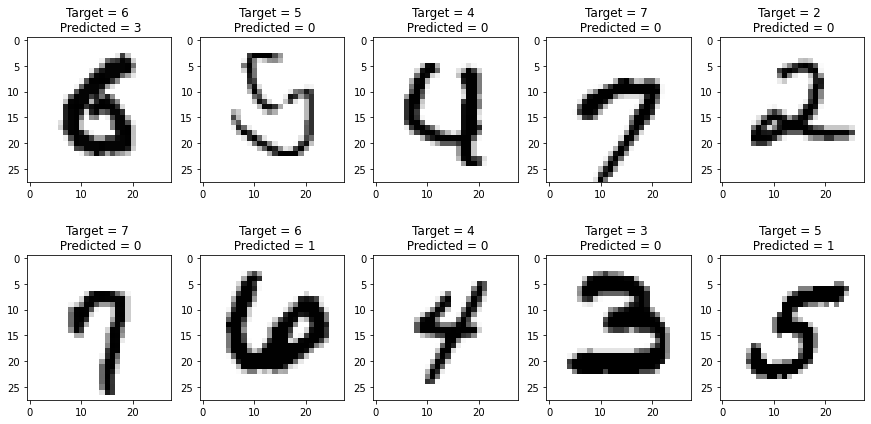

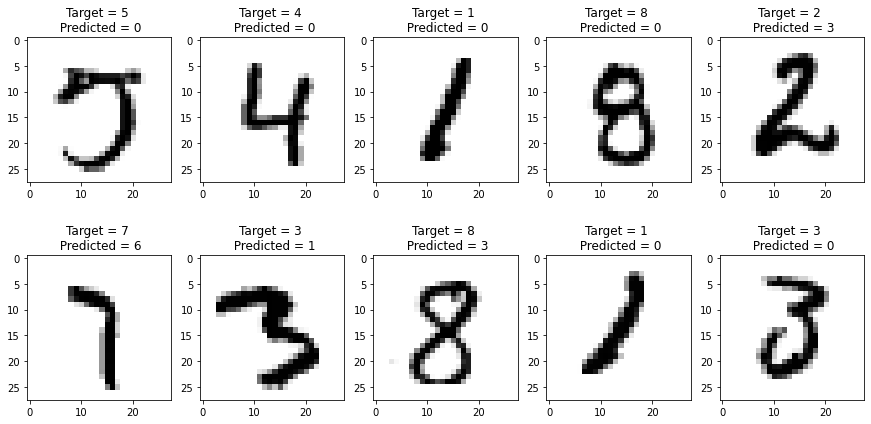

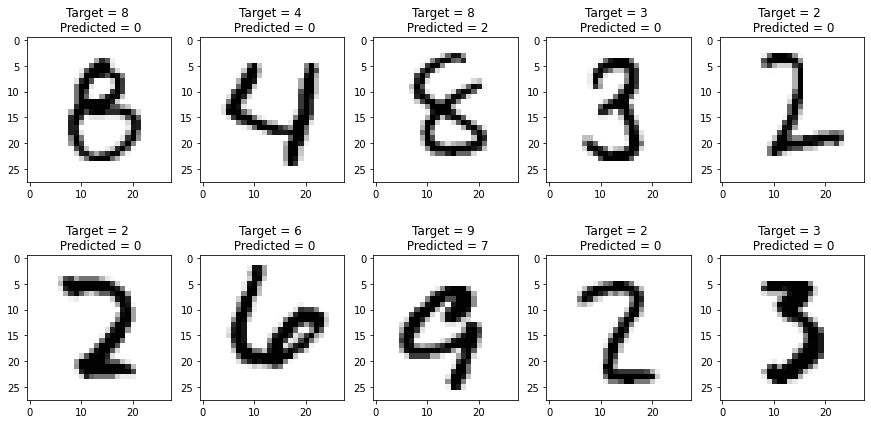

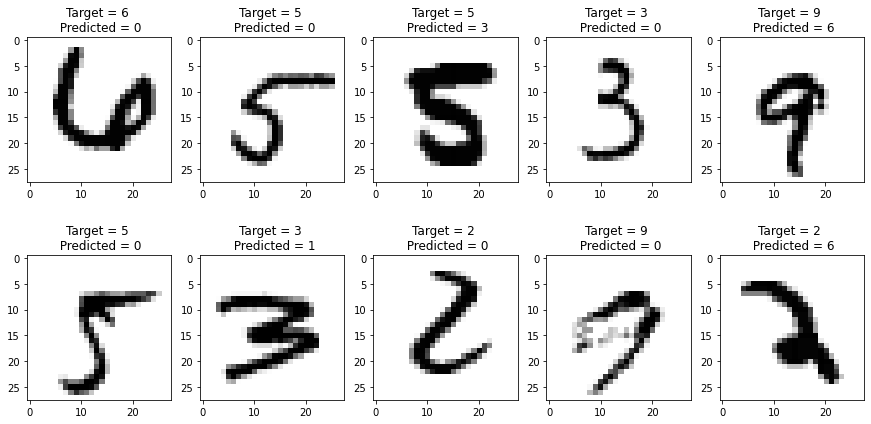

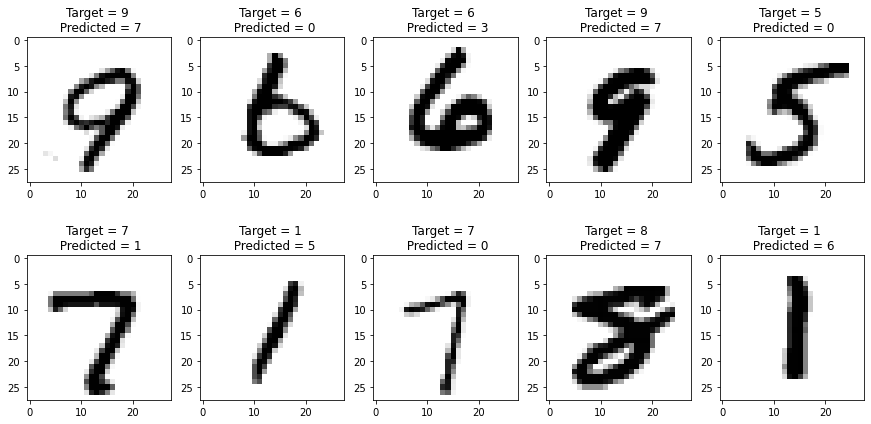

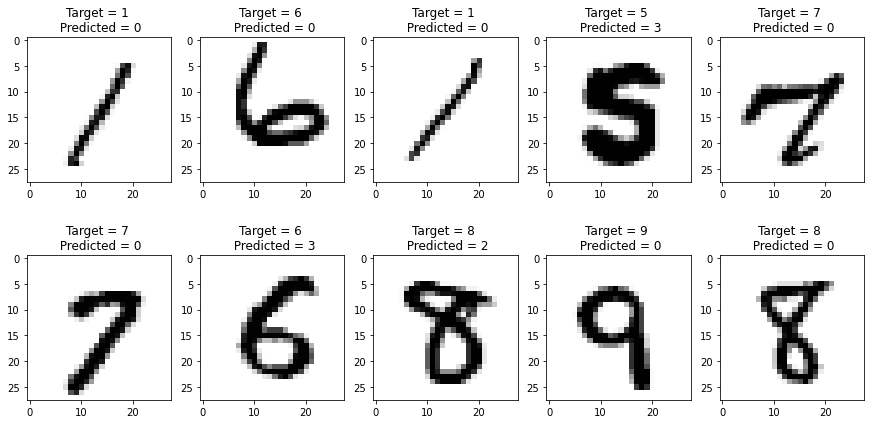

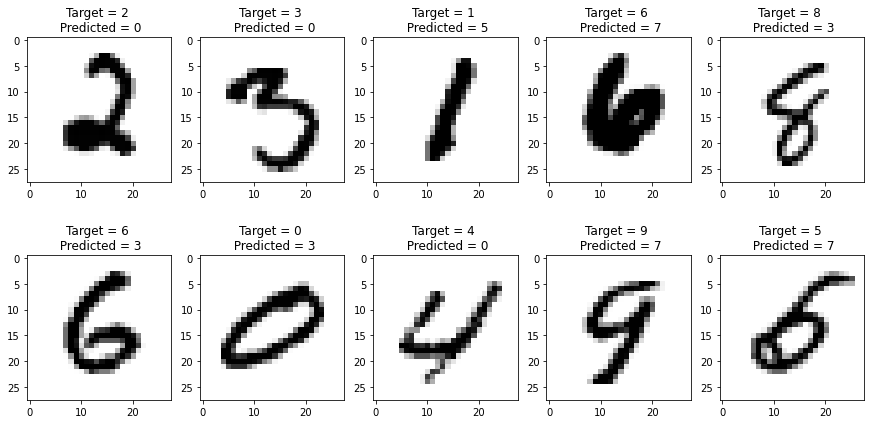

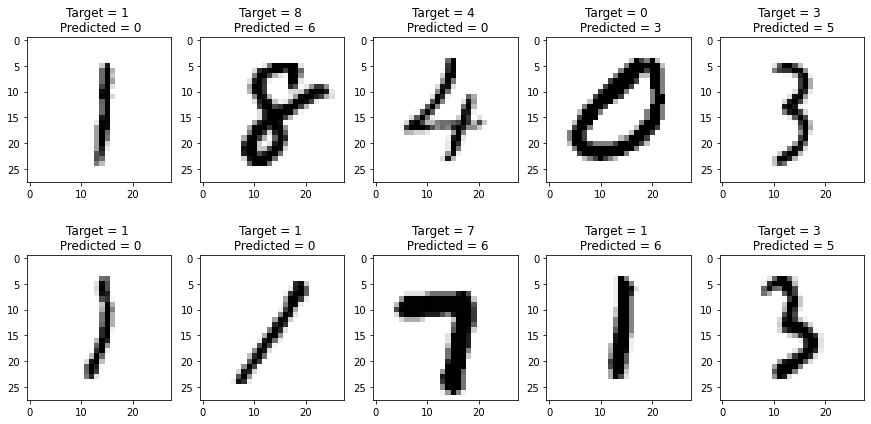

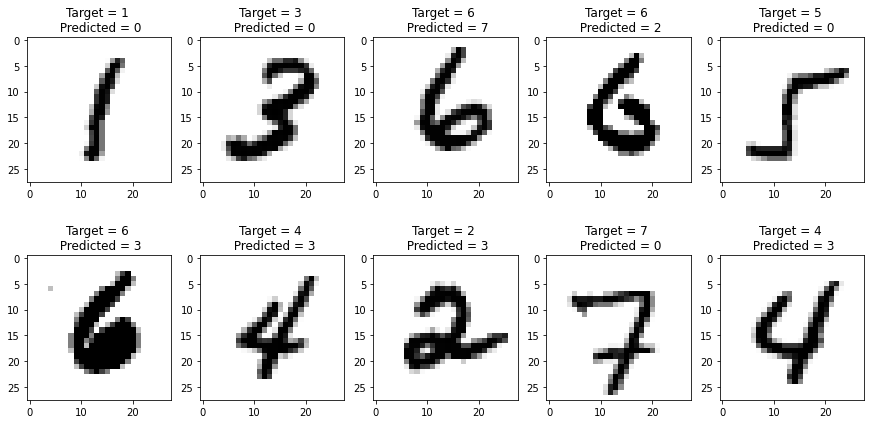

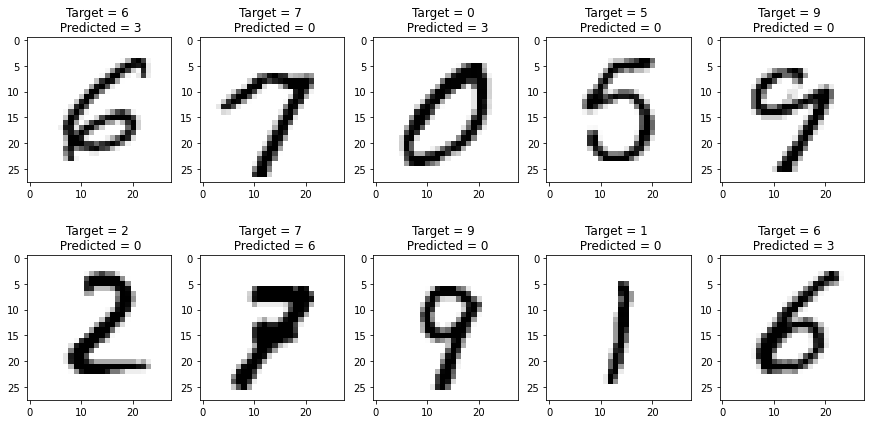

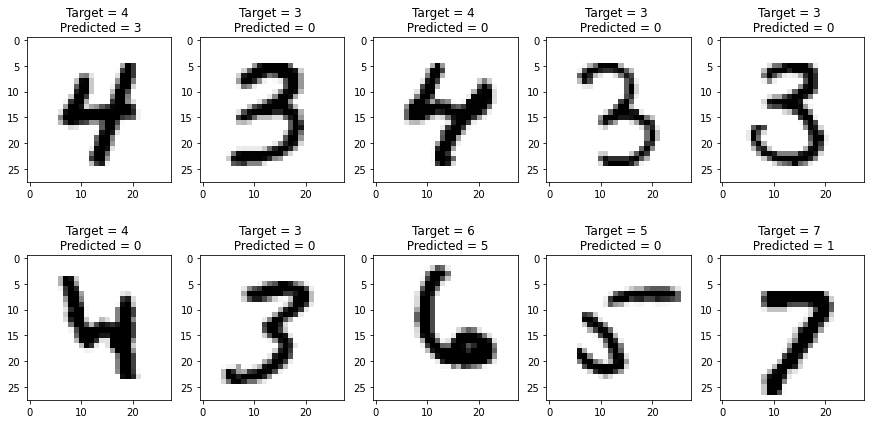

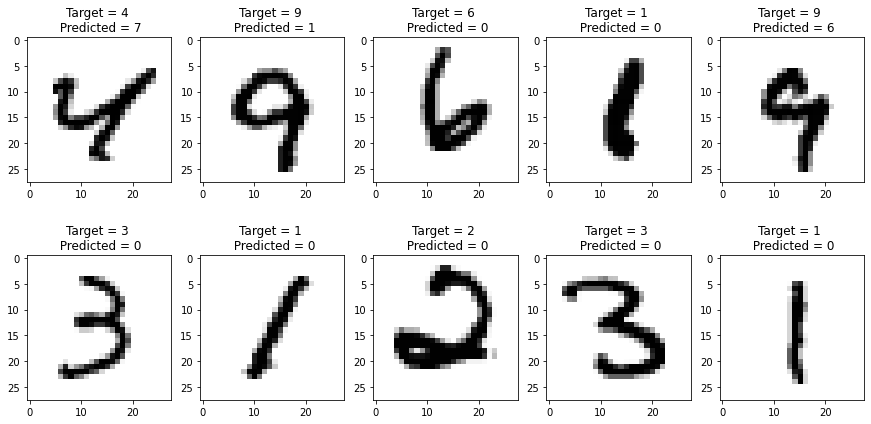

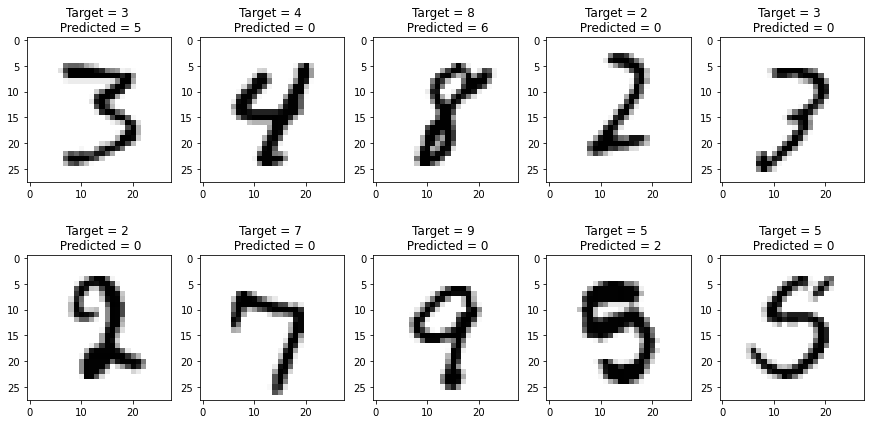

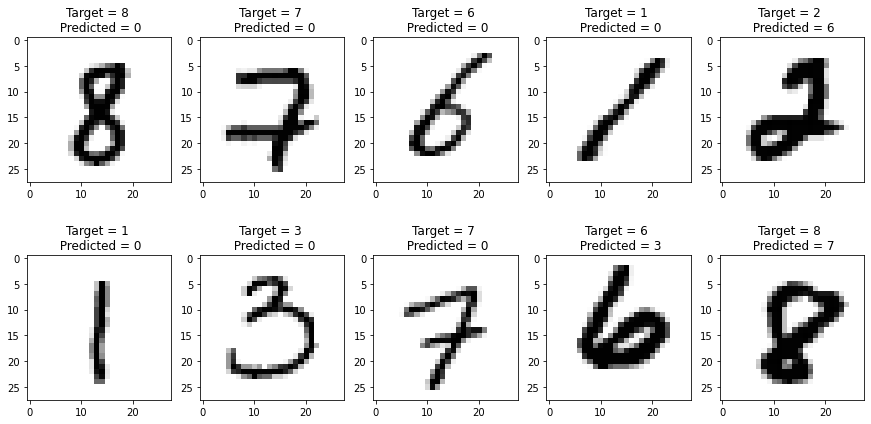

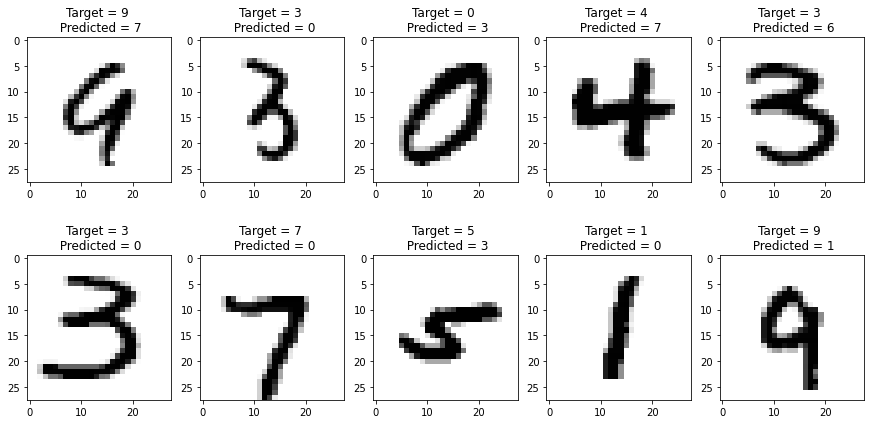

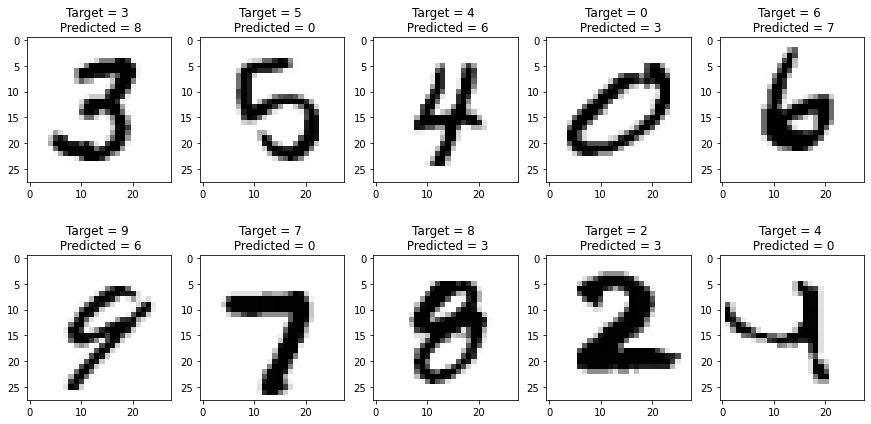

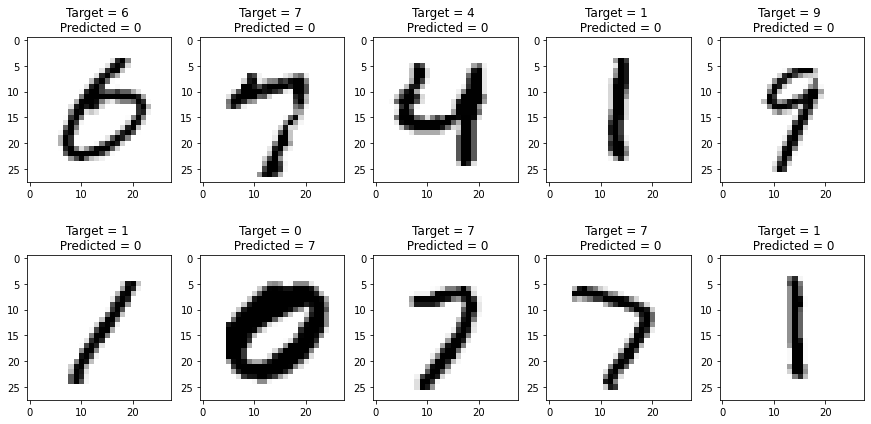

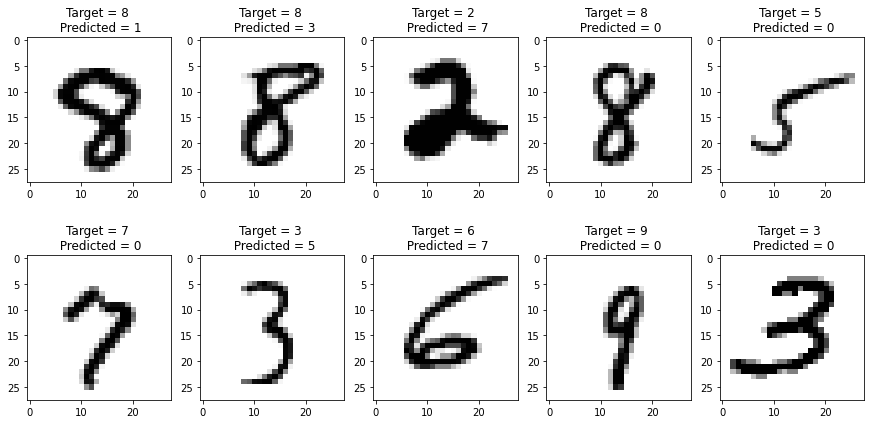

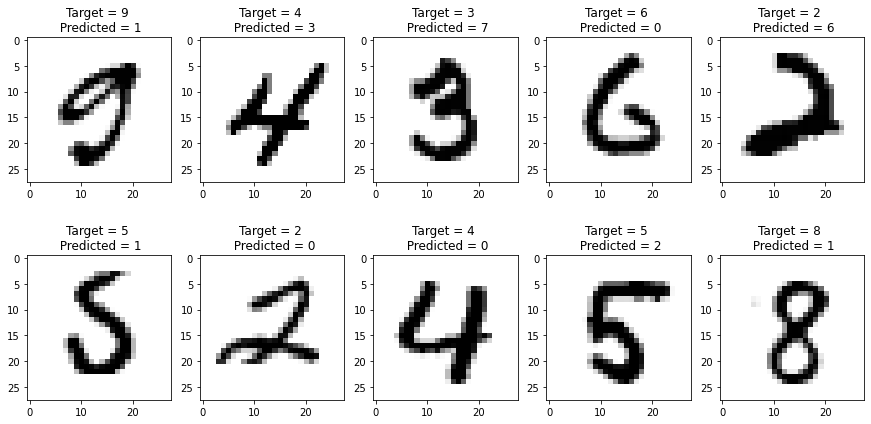

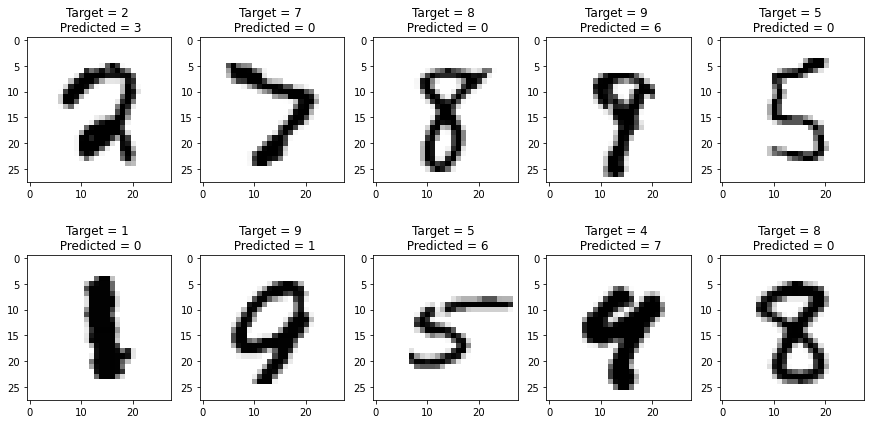

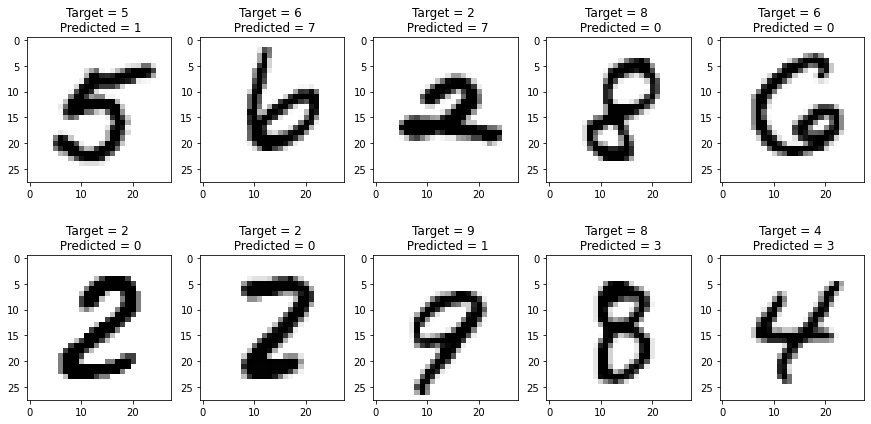

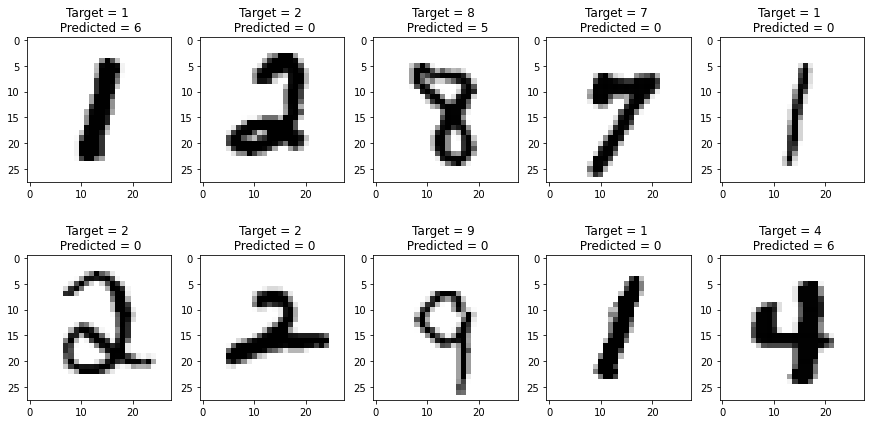

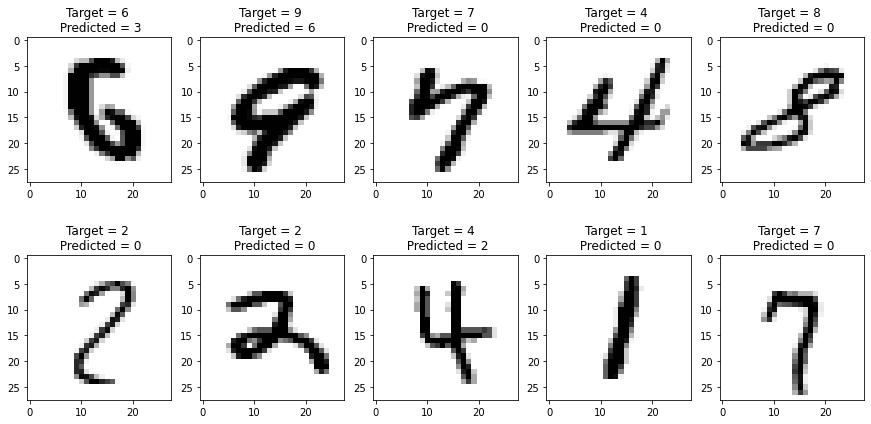

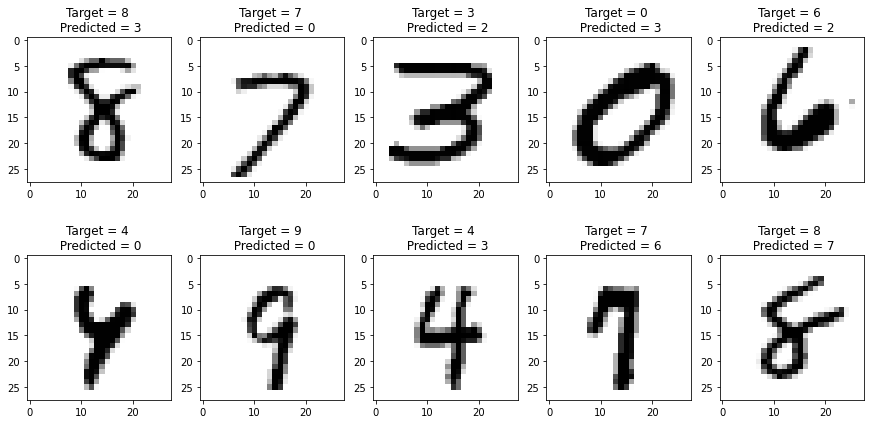

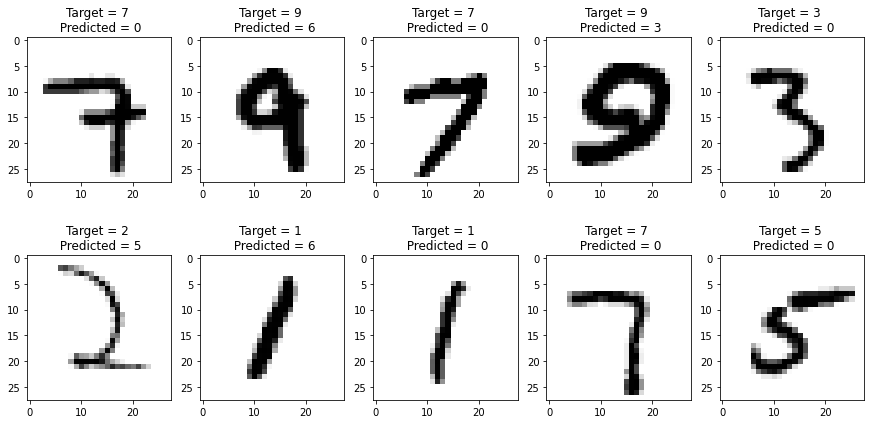

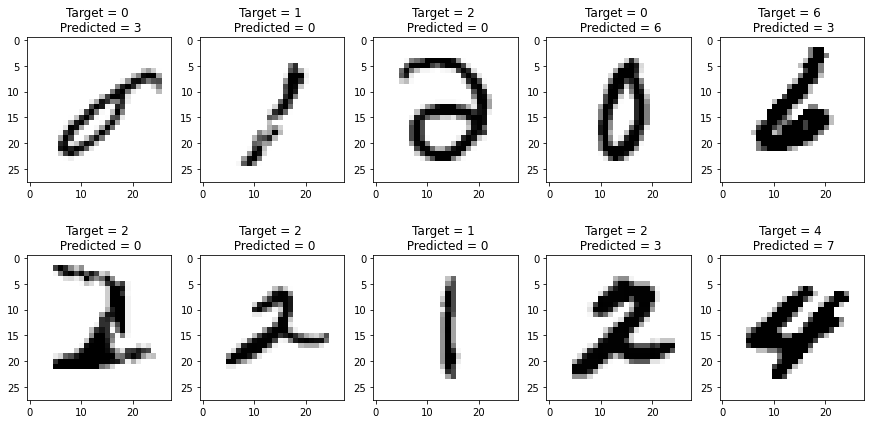

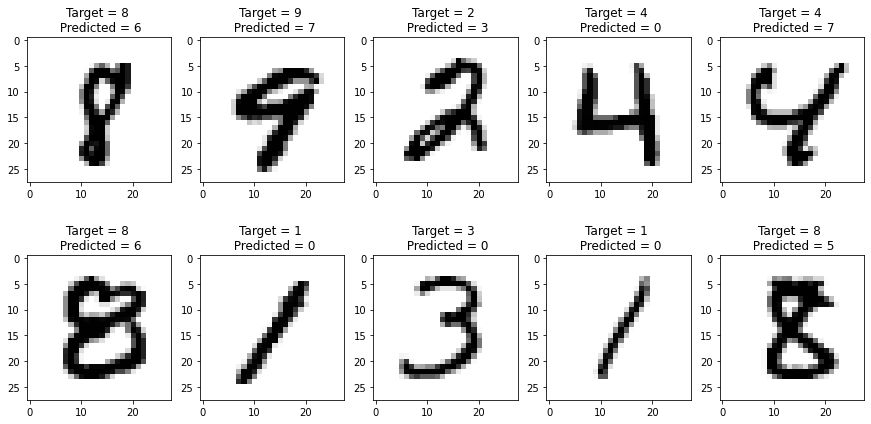

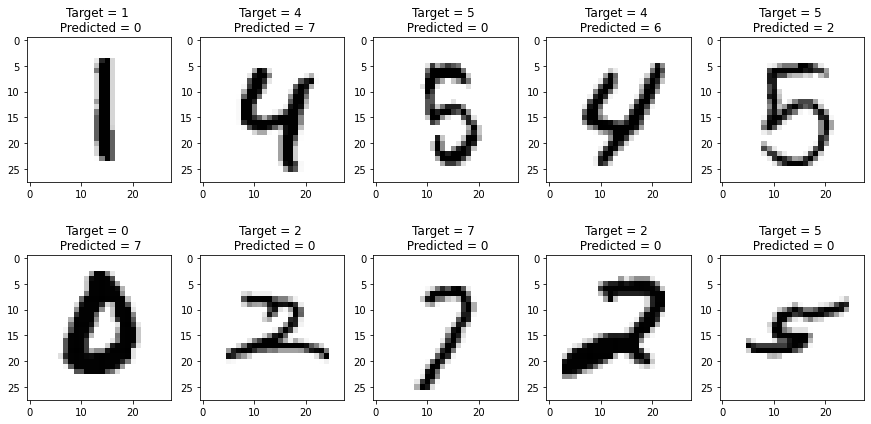

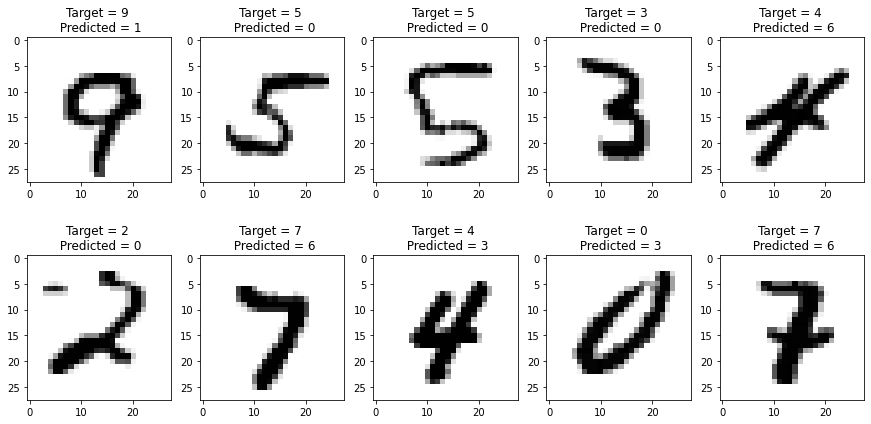

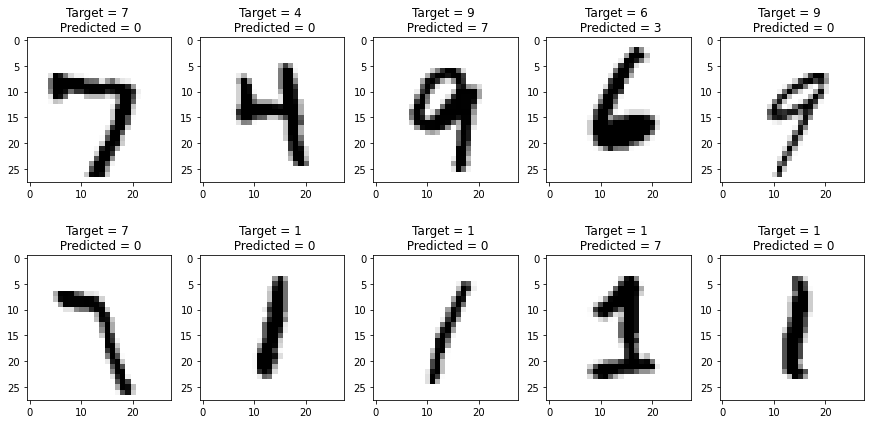

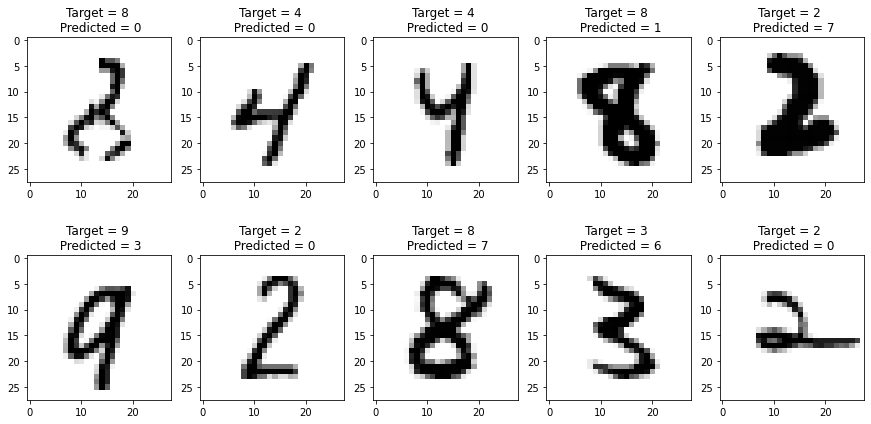

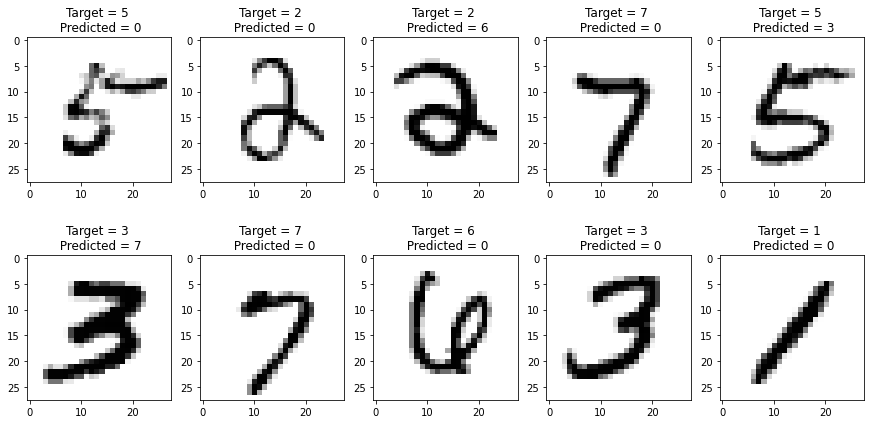

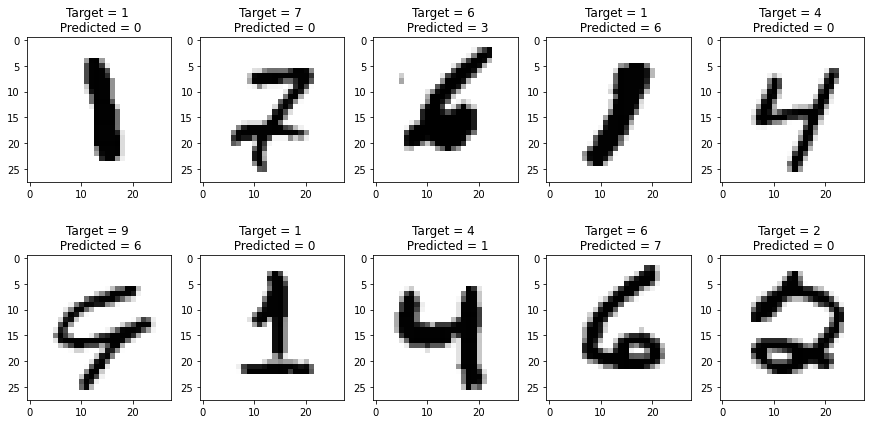

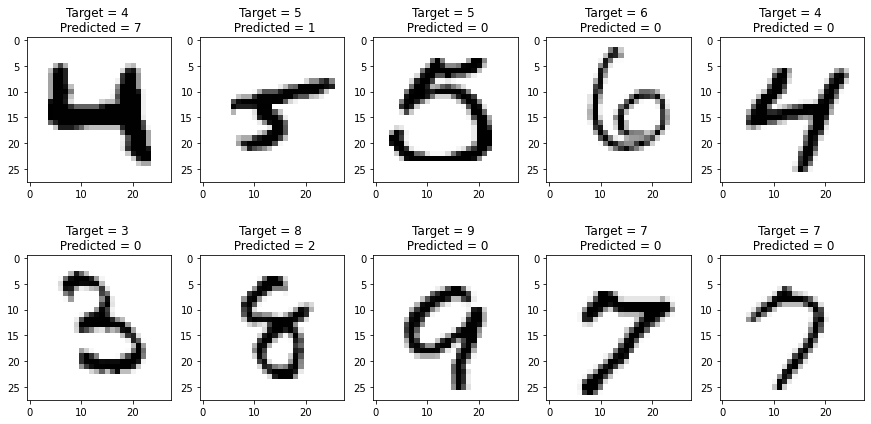

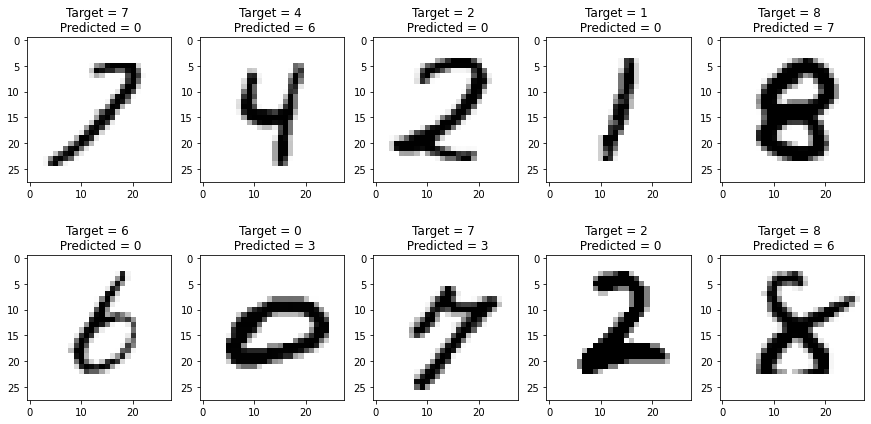

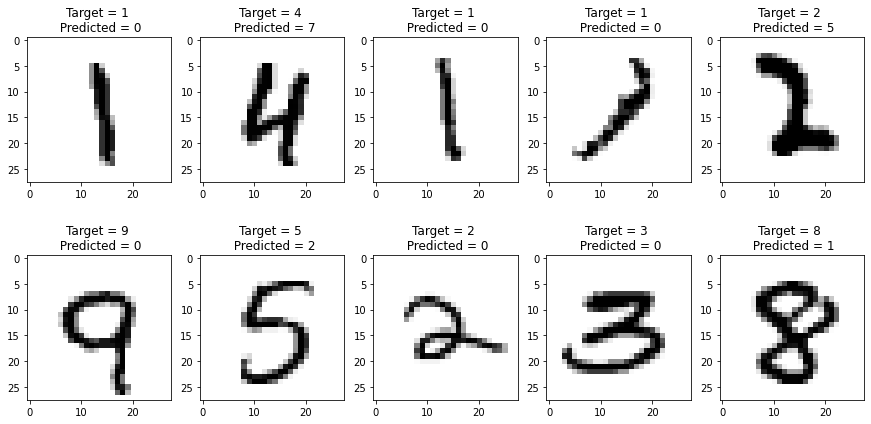

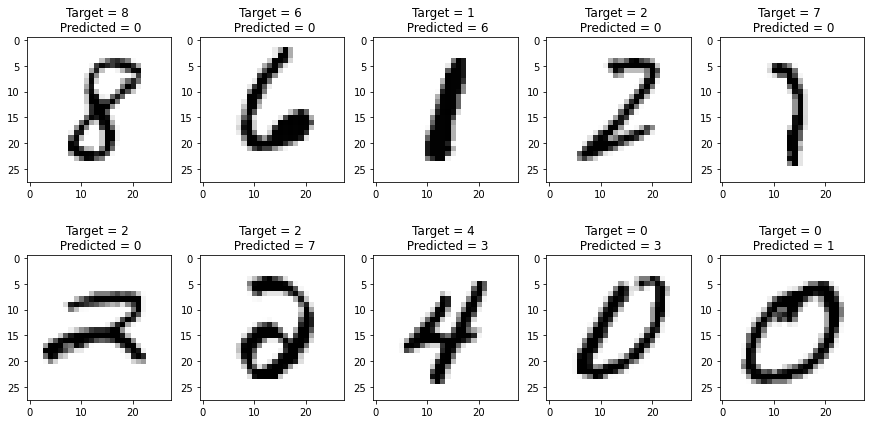

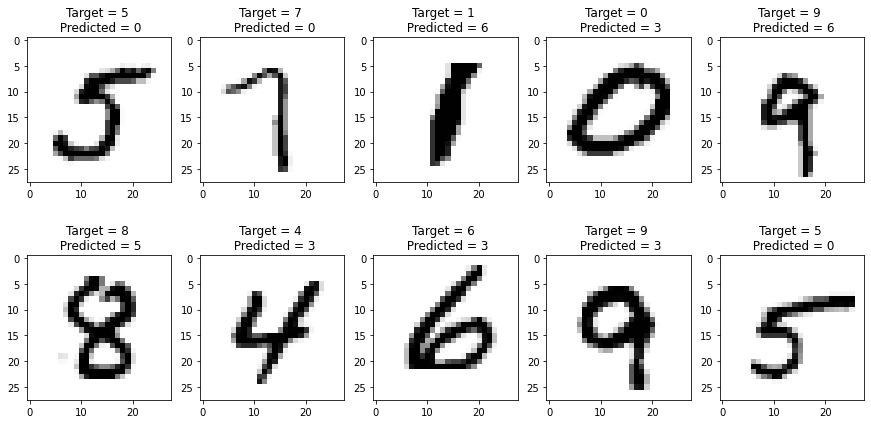

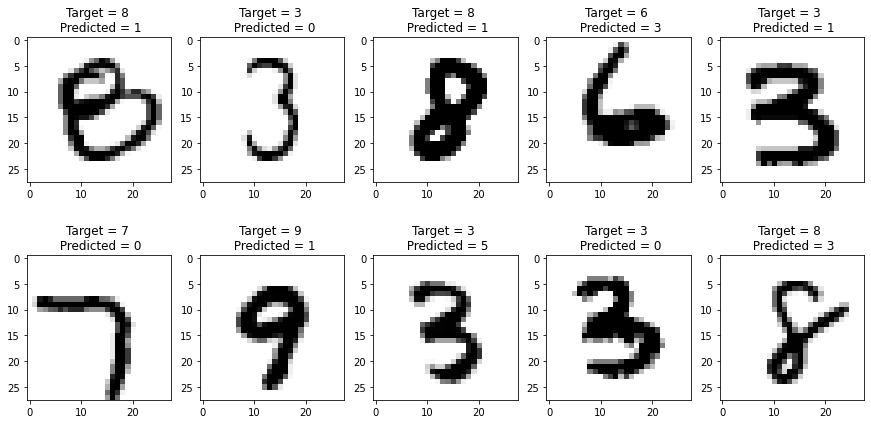

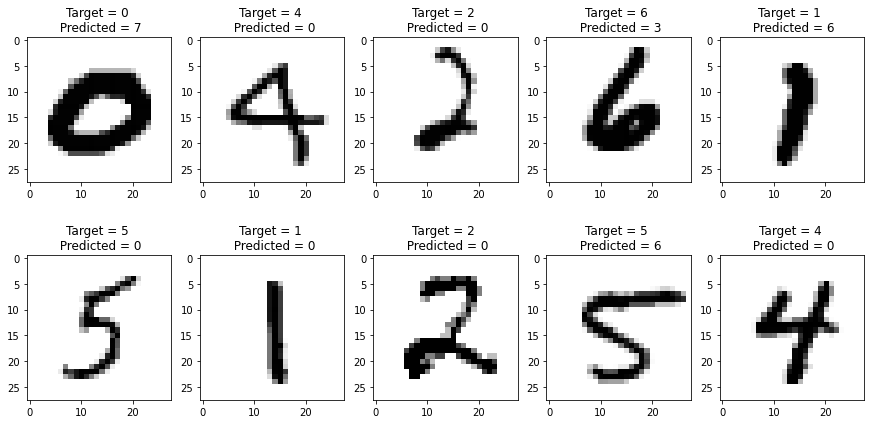

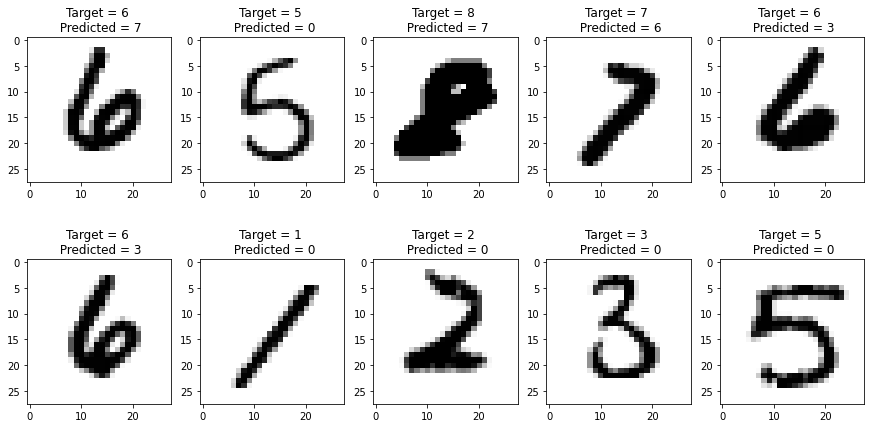

In [14]:
print(f"\nDisplay misclassified Files\n")

for ndx, norm in enumerate(norm_options):
  
  print(f"---------------------------------------------------------------")
  print(f"\nMisclassified files => Model with NormalizationType => { norm }\n")
  print(f"---------------------------------------------------------------")

  # Create model instance with required params
  model = Net(norm_type=norm).to(device)
  display_misclassified_images(model)